# Draft

Entrenar modelos tipo arbol (random forest, xgboost) para predecir turbiedad, presiones, cortes y demanda a partir de los datos operacionales y evaluar riesgo de las fuentes de agua por eventos hidrometereológicos

Información relativa a producción y calidad de agua es analizada en conjunto con las variables ambientales para evaluar el riesgo asociado a eventos meteorológicos extremos


## Variables candidatas a predecir
> __1. Turbiedad:__ Medida de la cantidad de particulas en suspensión del agua (algas, sedimentos en suspención, mat, organica y contaminantes pueden enturbiar el agua).
>
> __2. Presiones de suministro de agua potable:__ Pueden producir problemas para el calefont y otros artefactos.
>> - __Factores Relacionados:__ DBO, DQO, SST, CF,o CT, Turbiedad. 
>
> __3. Corte de suministro de agua potable o recolección de aguas servidas:__ Los cortes de suministro pueden ser programados o no programados que son aquellos que se producen generalmente por roturas de matrices de forma imprevista. Los cortes programados son a causa de una planificación, ya sea para mejorar o reparar el servicio, extensiones, interconexiones, etc. 
>> - __Factores Relacionados:__ Mala regulación de agua potable (cierre de válvulas, pérdidas considerables en la red, problemas en las fuentes de producción de la empresa)
>
> __4. Demanada de suministro de agua potable:__ El análisis de la demanda de agua potable urbana se refiere a la necesidad de agua para consumo humano principalmente en los nucleos urbanos de Chile abastecidos a través de las empresas sanitarias, reguladas por la SISS.
>> - __Factores Relacionados:__ Ingreso percápita, precio promedio m3, N° promedio de habitantes del sector, T° máxima promedio del sector, precipitación media anual
>
> __5. Riesgos por ventos hidrometeorológicos:__ Riesgos en la calidad de agua que se puedan generar a partir de eventos hidrometeorológicas debidas al cambio climatico.
>> - __Factores Relacionados:__ Fluviometría, Calidad de agua (Aspectos fisicoquimicos), meteorologia(Temperaturas, hidrometereologicos, Sedimentos).


- Archivos con sigla PR14 son muestras de agua potable. La SIS define los parámetros que hay que medir, la frecuencia, etc.
- Archivos con sigla PR18-2 son mediciones en la estación de agua cruda --> usar esto idealmente como entrada del modelo

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)
import seaborn as sn

from glob import glob
import re

#pd.set_option('display.max_rows', None)
from IPython.display import display, Markdown
from copy import copy
import statsmodels.tsa.stattools as ts

SEED = 15051991

In [2]:
def buildLaggedFeatures(s,lag=2,dropna=True):
    '''
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)
    
    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

# EDA

In [3]:
pr18_files = glob('modeloRiesgoAmbiental/DATOS INTERNOS TOTAL LOCALIDADES/Historial PR18-2 Muestras/*.csv')
#re_nombreMedicion_PR18 = re.compile(r'/\w+_(\w*)-?_PR182\.csv$')

In [4]:
df = pd.concat([pd.read_csv(file, index_col=0) for file in pr18_files], axis = 0)

In [5]:
df.sample(5)

codigoLocalidad  ServicioCalidad ObraCaptación  codigo_muestra  \
415              255            11104        101-17           49457   
145              255            11104         101-7           50599   
370               82            11102        201-14           75548   
2                 82            11102         101-1           46138   
166              255            11104         101-9           47208   

    fecha_muestra hora_muestra codigo_parametro signo   valor  observacion  \
415    2020-02-10        18:00               Fe     =   0.522          NaN   
145    2020-03-16        18:55        TURBIEDAD     =   1.000          NaN   
370    2022-02-07        07:45           E-COLI     =  49.000          NaN   
2      2019-11-04        11:22               CT     =  33.000          NaN   
166    2019-12-03        17:00        TURBIEDAD     =   1.300          NaN   

                               id_muestra  
415  735c7787-b486-42c9-8553-17e4083a38df  
145  8634dfc5-44f5-4ce0-b694-1599f5a01bc1  
370  a3fef8be-7709-43cf-9c69-fd669c735d64  
2    e107ab35-54fd-4700-b889-1012ab91d3bf  
166  6ed7a35c-f499-426c-b0ba-2435e737ce7b

In [6]:
df.isna().sum()

codigoLocalidad        0
ServicioCalidad        0
ObraCaptación          0
codigo_muestra         0
fecha_muestra          0
hora_muestra           0
codigo_parametro       0
signo                  0
valor                 32
observacion         2900
id_muestra             0
dtype: int64

In [7]:
df.codigoLocalidad.value_counts()

82     1134
255     895
62      327
257     202
256     199
55      143
Name: codigoLocalidad, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 304
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   codigoLocalidad   2900 non-null   int64  
 1   ServicioCalidad   2900 non-null   int64  
 2   ObraCaptación     2900 non-null   object 
 3   codigo_muestra    2900 non-null   int64  
 4   fecha_muestra     2900 non-null   object 
 5   hora_muestra      2900 non-null   object 
 6   codigo_parametro  2900 non-null   object 
 7   signo             2900 non-null   object 
 8   valor             2868 non-null   float64
 9   observacion       0 non-null      float64
 10  id_muestra        2900 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 271.9+ KB


In [9]:
df.codigo_parametro.value_counts()

COLOR VERD    457
Fe            440
CT            437
E-COLI        437
TURBIEDAD     394
PH            305
Mn            243
As            117
F-             70
Name: codigo_parametro, dtype: int64

In [10]:
df.fecha_muestra = pd.to_datetime(df.fecha_muestra, format = '%Y-%m-%d')

In [11]:
duplicated_dates = df[df.signo == '='].dropna(subset = ['valor'])
duplicated_dates = duplicated_dates[(duplicated_dates.fecha_muestra.isin(duplicated_dates.fecha_muestra.value_counts().loc[lambda x: x>1].index.astype('str')))]\
                                                                                .sort_values(by = 'fecha_muestra')

In [12]:
print('Cantidad total de veces que aparece una fecha repetida de muestreo para un parametro')
duplicated_dates.codigo_parametro.value_counts()

Cantidad total de veces que aparece una fecha repetida de muestreo para un parametro


Fe            360
COLOR VERD    324
CT            316
E-COLI        314
PH            301
TURBIEDAD     291
Mn            166
As              7
F-              2
Name: codigo_parametro, dtype: int64

In [13]:
grouped_parametros_by_date = df[df.signo == '='].dropna(subset = ['valor'])\
                        .groupby(by = ['codigo_parametro', 'fecha_muestra'])['valor'].agg(['min', 'max', 'mean','std', 'count'])\
                        .dropna().sort_values(by = ['codigo_parametro', 'fecha_muestra'], ascending = True)

In [14]:
grouped_parametros_by_date[:50]

min   max       mean        std  count
codigo_parametro fecha_muestra                                         
COLOR VERD       2019-10-07     10.0  10.0  10.000000   0.000000      2
                 2019-11-11     10.0  10.0  10.000000   0.000000      2
                 2019-11-18     10.0  10.0  10.000000   0.000000      2
                 2019-11-24     10.0  15.0  12.500000   3.535534      2
                 2019-11-25     15.0  15.0  15.000000   0.000000      2
                 2019-12-02     10.0  10.0  10.000000   0.000000      3
                 2019-12-09     12.0  15.0  13.500000   2.121320      2
                 2019-12-10     15.0  20.0  17.500000   3.535534      2
                 2019-12-17     10.0  20.0  15.000000   7.071068      2
                 2019-12-23     10.0  15.0  12.500000   3.535534      2
                 2020-01-06     10.0  20.0  15.000000   5.000000      3
                 2020-01-20     15.0  15.0  15.000000   0.000000      2
                 2020-01-27     10.0  10.0  10.000000   0.000000      2
                 2020-02-03     10.0  15.0  11.250000   2.500000      4
                 2020-02-10     10.0  10.0  10.000000   0.000000      4
                 2020-02-17     10.0  15.0  12.500000   3.535534      2
                 2020-02-24     10.0  15.0  12.500000   3.535534      2
                 2020-03-02     10.0  10.0  10.000000   0.000000      3
                 2020-03-16     15.0  15.0  15.000000   0.000000      2
                 2020-04-06     10.0  10.0  10.000000   0.000000      2
                 2020-04-20     10.0  25.0  16.666667   7.637626      3
                 2020-04-27     10.0  15.0  12.500000   3.535534      2
                 2020-05-04     15.0  25.0  20.000000   7.071068      2
                 2020-05-18     10.0  40.0  25.000000  15.000000      3
                 2020-06-08     15.0  20.0  17.500000   3.535534      2
                 2020-06-15     10.0  20.0  15.000000   7.071068      2
                 2020-06-22     10.0  15.0  12.500000   3.535534      2
                 2020-07-13     10.0  15.0  12.500000   3.535534      2
                 2020-07-14     15.0  15.0  15.000000   0.000000      2
                 2020-07-20     15.0  30.0  22.500000  10.606602      2
                 2020-07-21     15.0  15.0  15.000000   0.000000      2
                 2020-08-18     15.0  15.0  15.000000   0.000000      2
                 2020-08-24     10.0  20.0  15.000000   5.773503      4
                 2020-09-14     10.0  15.0  12.500000   3.535534      2
                 2020-09-15     10.0  15.0  12.500000   3.535534      2
                 2020-09-21     10.0  15.0  11.666667   2.886751      3
                 2020-09-28     15.0  25.0  20.000000   7.071068      2
                 2020-10-13     15.0  15.0  15.000000   0.000000      2
                 2020-10-20     15.0  15.0  15.000000   0.000000      3
                 2020-10-26     10.0  20.0  15.000000   7.071068      2
                 2020-11-09     10.0  10.0  10.000000   0.000000      2
                 2020-11-23     10.0  15.0  11.250000   2.500000      4
                 2020-11-24     10.0  10.0  10.000000   0.000000      2
                 2020-12-21     10.0  10.0  10.000000   0.000000      3
                 2020-12-28     10.0  15.0  13.750000   2.500000      4
                 2021-01-04     10.0  15.0  13.750000   2.500000      4
                 2021-01-05     15.0  15.0  15.000000   0.000000      2
                 2021-01-25     10.0  10.0  10.000000   0.000000      3
                 2021-02-22     10.0  15.0  12.500000   3.535534      2
                 2021-03-29     15.0  15.0  15.000000   0.000000      2

In [15]:
n_samples_per_dateAndParameter = df.reset_index().groupby(by = ['codigo_parametro'])\
                                    .agg({'fecha_muestra': 'count'}).sort_values(by = 'fecha_muestra', ascending = False)

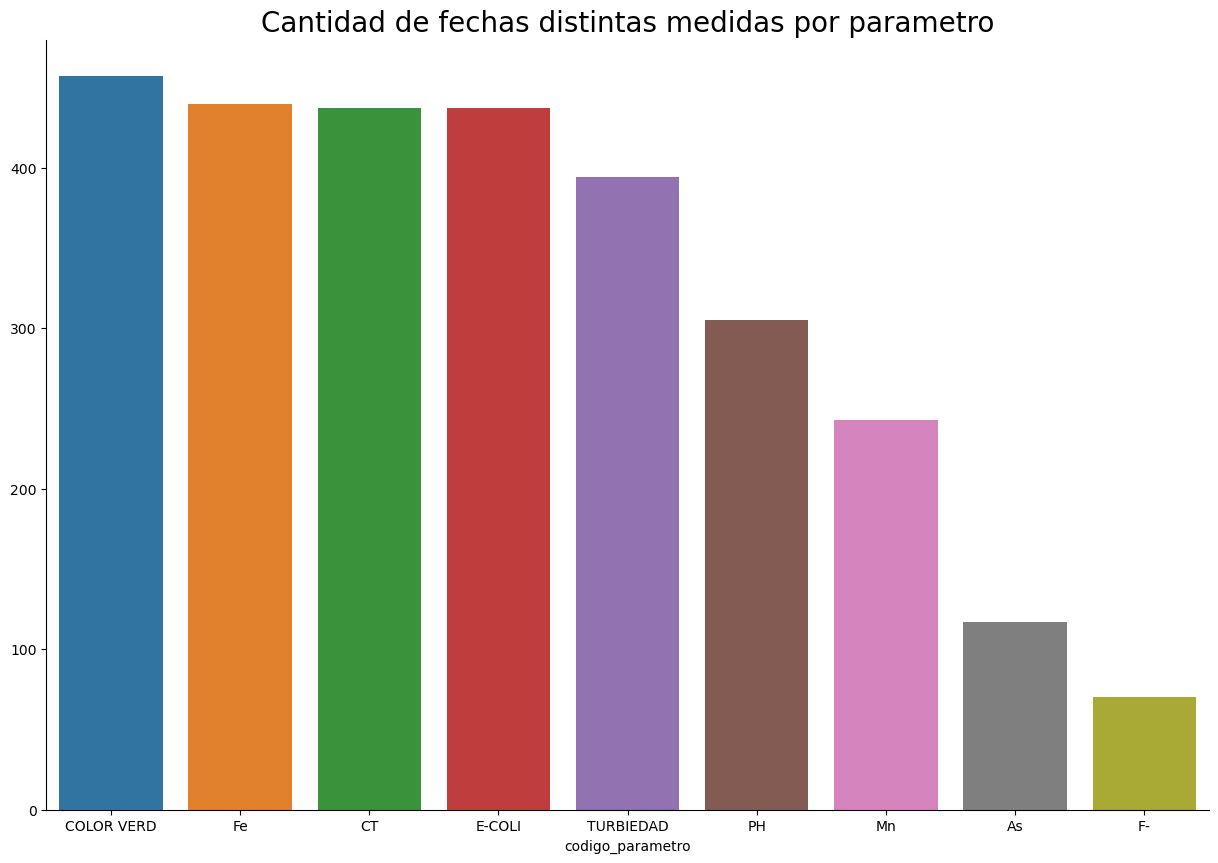

In [16]:
plt.title('Cantidad de fechas distintas medidas por parametro', fontsize = 20)
sn.barplot(x = n_samples_per_dateAndParameter.index,
          y = n_samples_per_dateAndParameter.values.ravel())
sn.despine()

In [17]:
n_samples_per_dateAndParameter

fecha_muestra
codigo_parametro               
COLOR VERD                  457
Fe                          440
CT                          437
E-COLI                      437
TURBIEDAD                   394
PH                          305
Mn                          243
As                          117
F-                           70

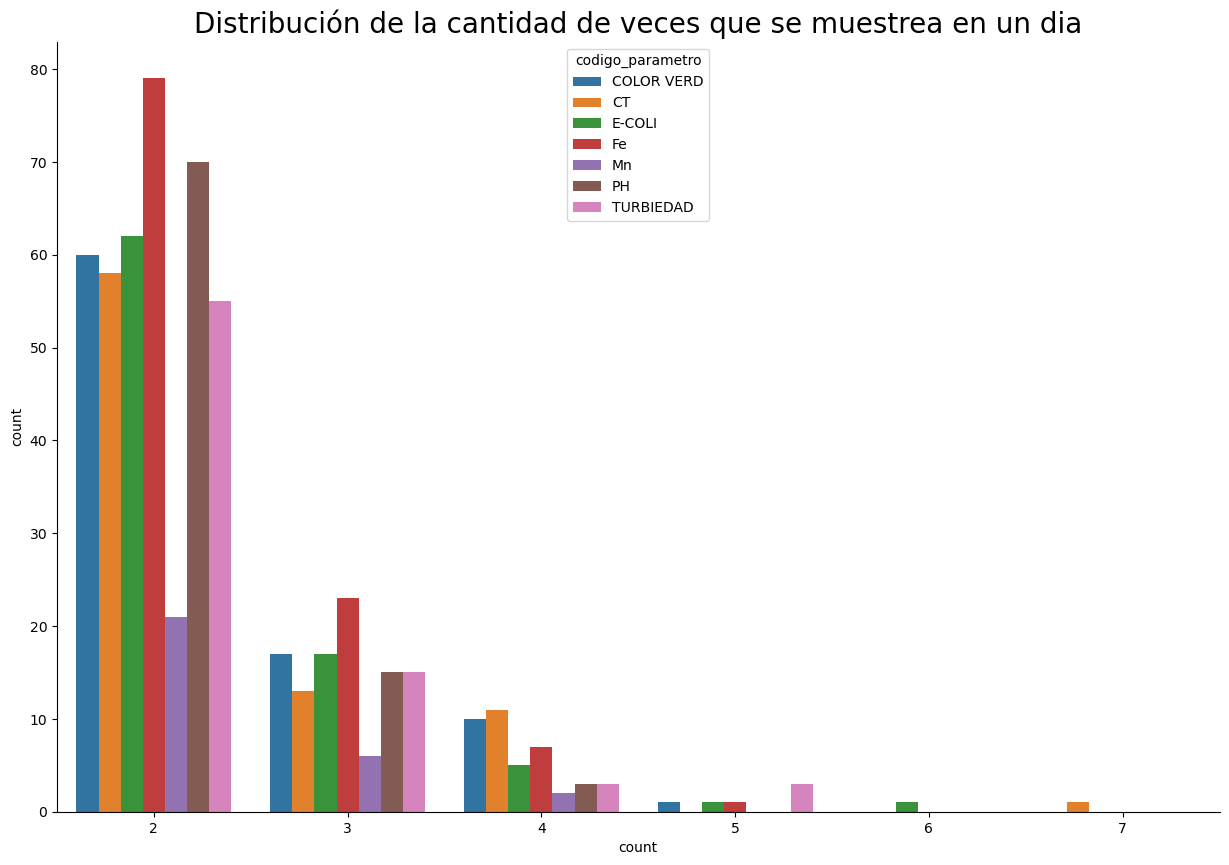

In [18]:
sn.countplot(x = 'count',data = grouped_parametros_by_date.reset_index(), hue = 'codigo_parametro')
plt.title('Distribución de la cantidad de veces que se muestrea en un dia', fontsize = 20)
sn.despine()

In [19]:
grouped_parametros_by_date['count'].value_counts()

2    405
3    106
4     41
5      6
7      1
6      1
Name: count, dtype: int64

El estándar parece ser muestrear entre 2 y 3 veces al día

## Turbiedad

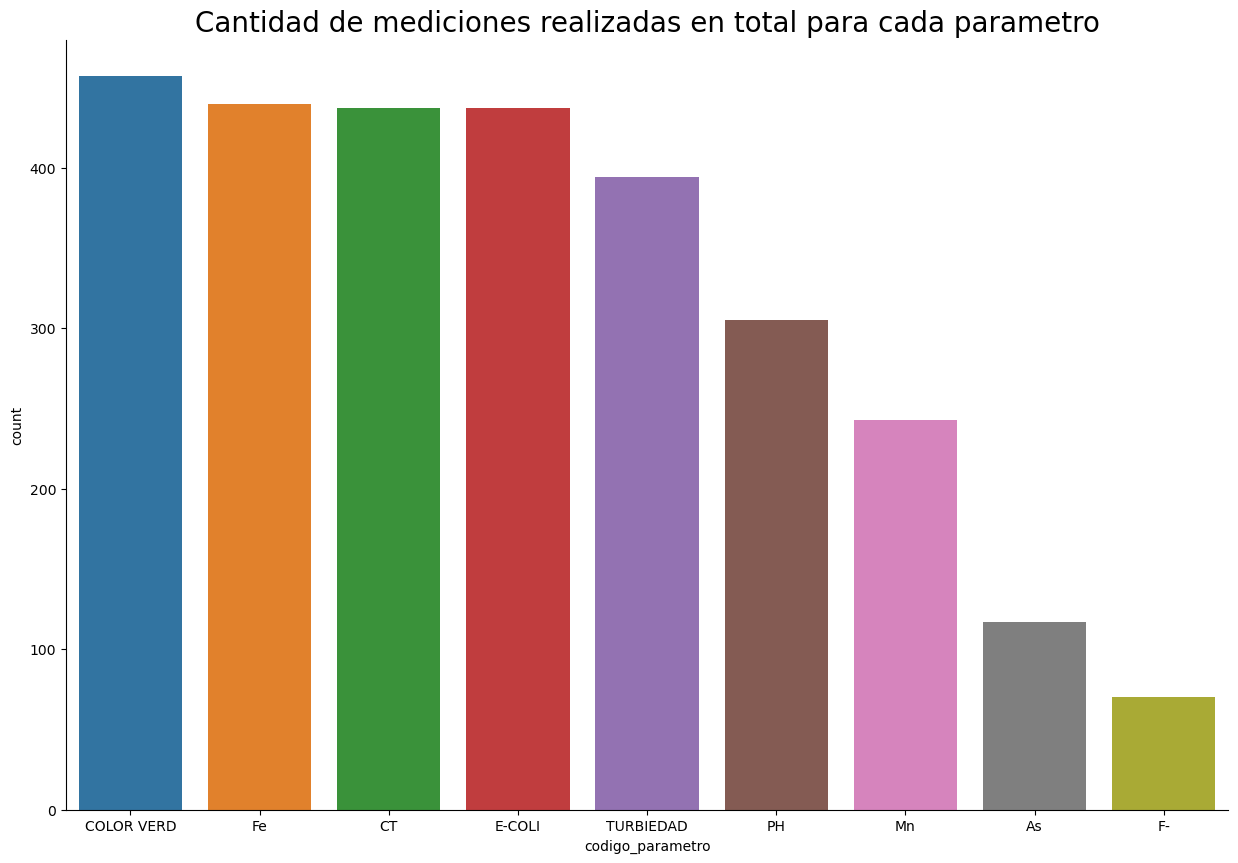

In [20]:
sn.countplot(x = 'codigo_parametro',  data =df, order = df.codigo_parametro.value_counts().index)
plt.title('Cantidad de mediciones realizadas en total para cada parametro', fontsize = 20)
sn.despine()

In [21]:
df.codigo_parametro.value_counts()

COLOR VERD    457
Fe            440
CT            437
E-COLI        437
TURBIEDAD     394
PH            305
Mn            243
As            117
F-             70
Name: codigo_parametro, dtype: int64

__Nota:__ Se especificó que aunque las mediciones de los parámetros se hagan en distintos días, si se debe de tener al menos una medición de cada parámetro a la semana, además, se mencionó que no habia mayor o menor importacia en las mediciones realizadas en una hora en específica por lo que es aceptable agregar los valores medidos para cada parámetro a la semana mediante la media.

### Distribución de cantidades entre los distintos elementos

In [22]:
df.dropna(subset = 'valor', inplace = True)

<AxesSubplot:xlabel='valor'>

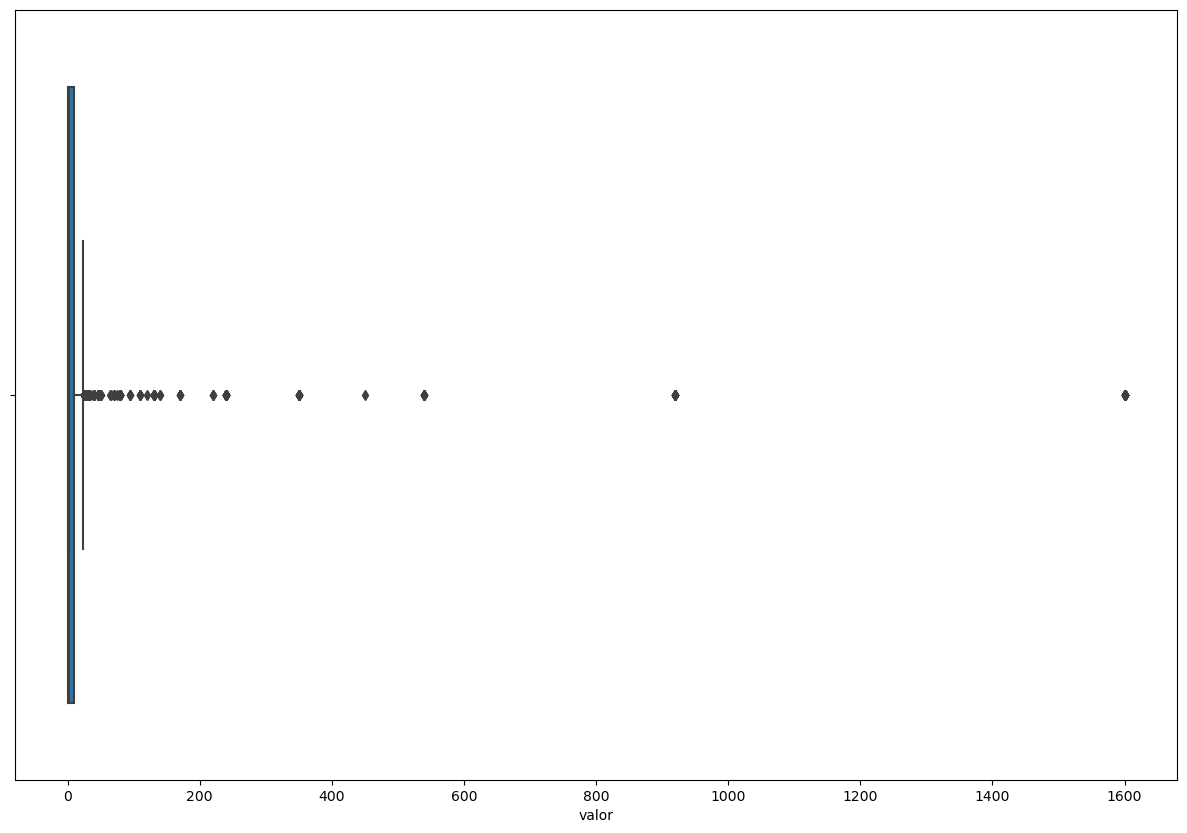

In [23]:
sn.boxplot(x = 'valor', data = df[df.valor <= 10000], hue = 'codigo_parametro')

## Agrupamiento por semana

In [24]:
df['Date'] = pd.to_datetime(df['fecha_muestra']) - pd.to_timedelta(7, unit='d')
weekly = df.groupby(['codigo_parametro', pd.Grouper(key='Date', freq='W-MON')])['valor']\
                                                                        .mean()\
                                                                        .reset_index()\
                                                                       .sort_values('Date')

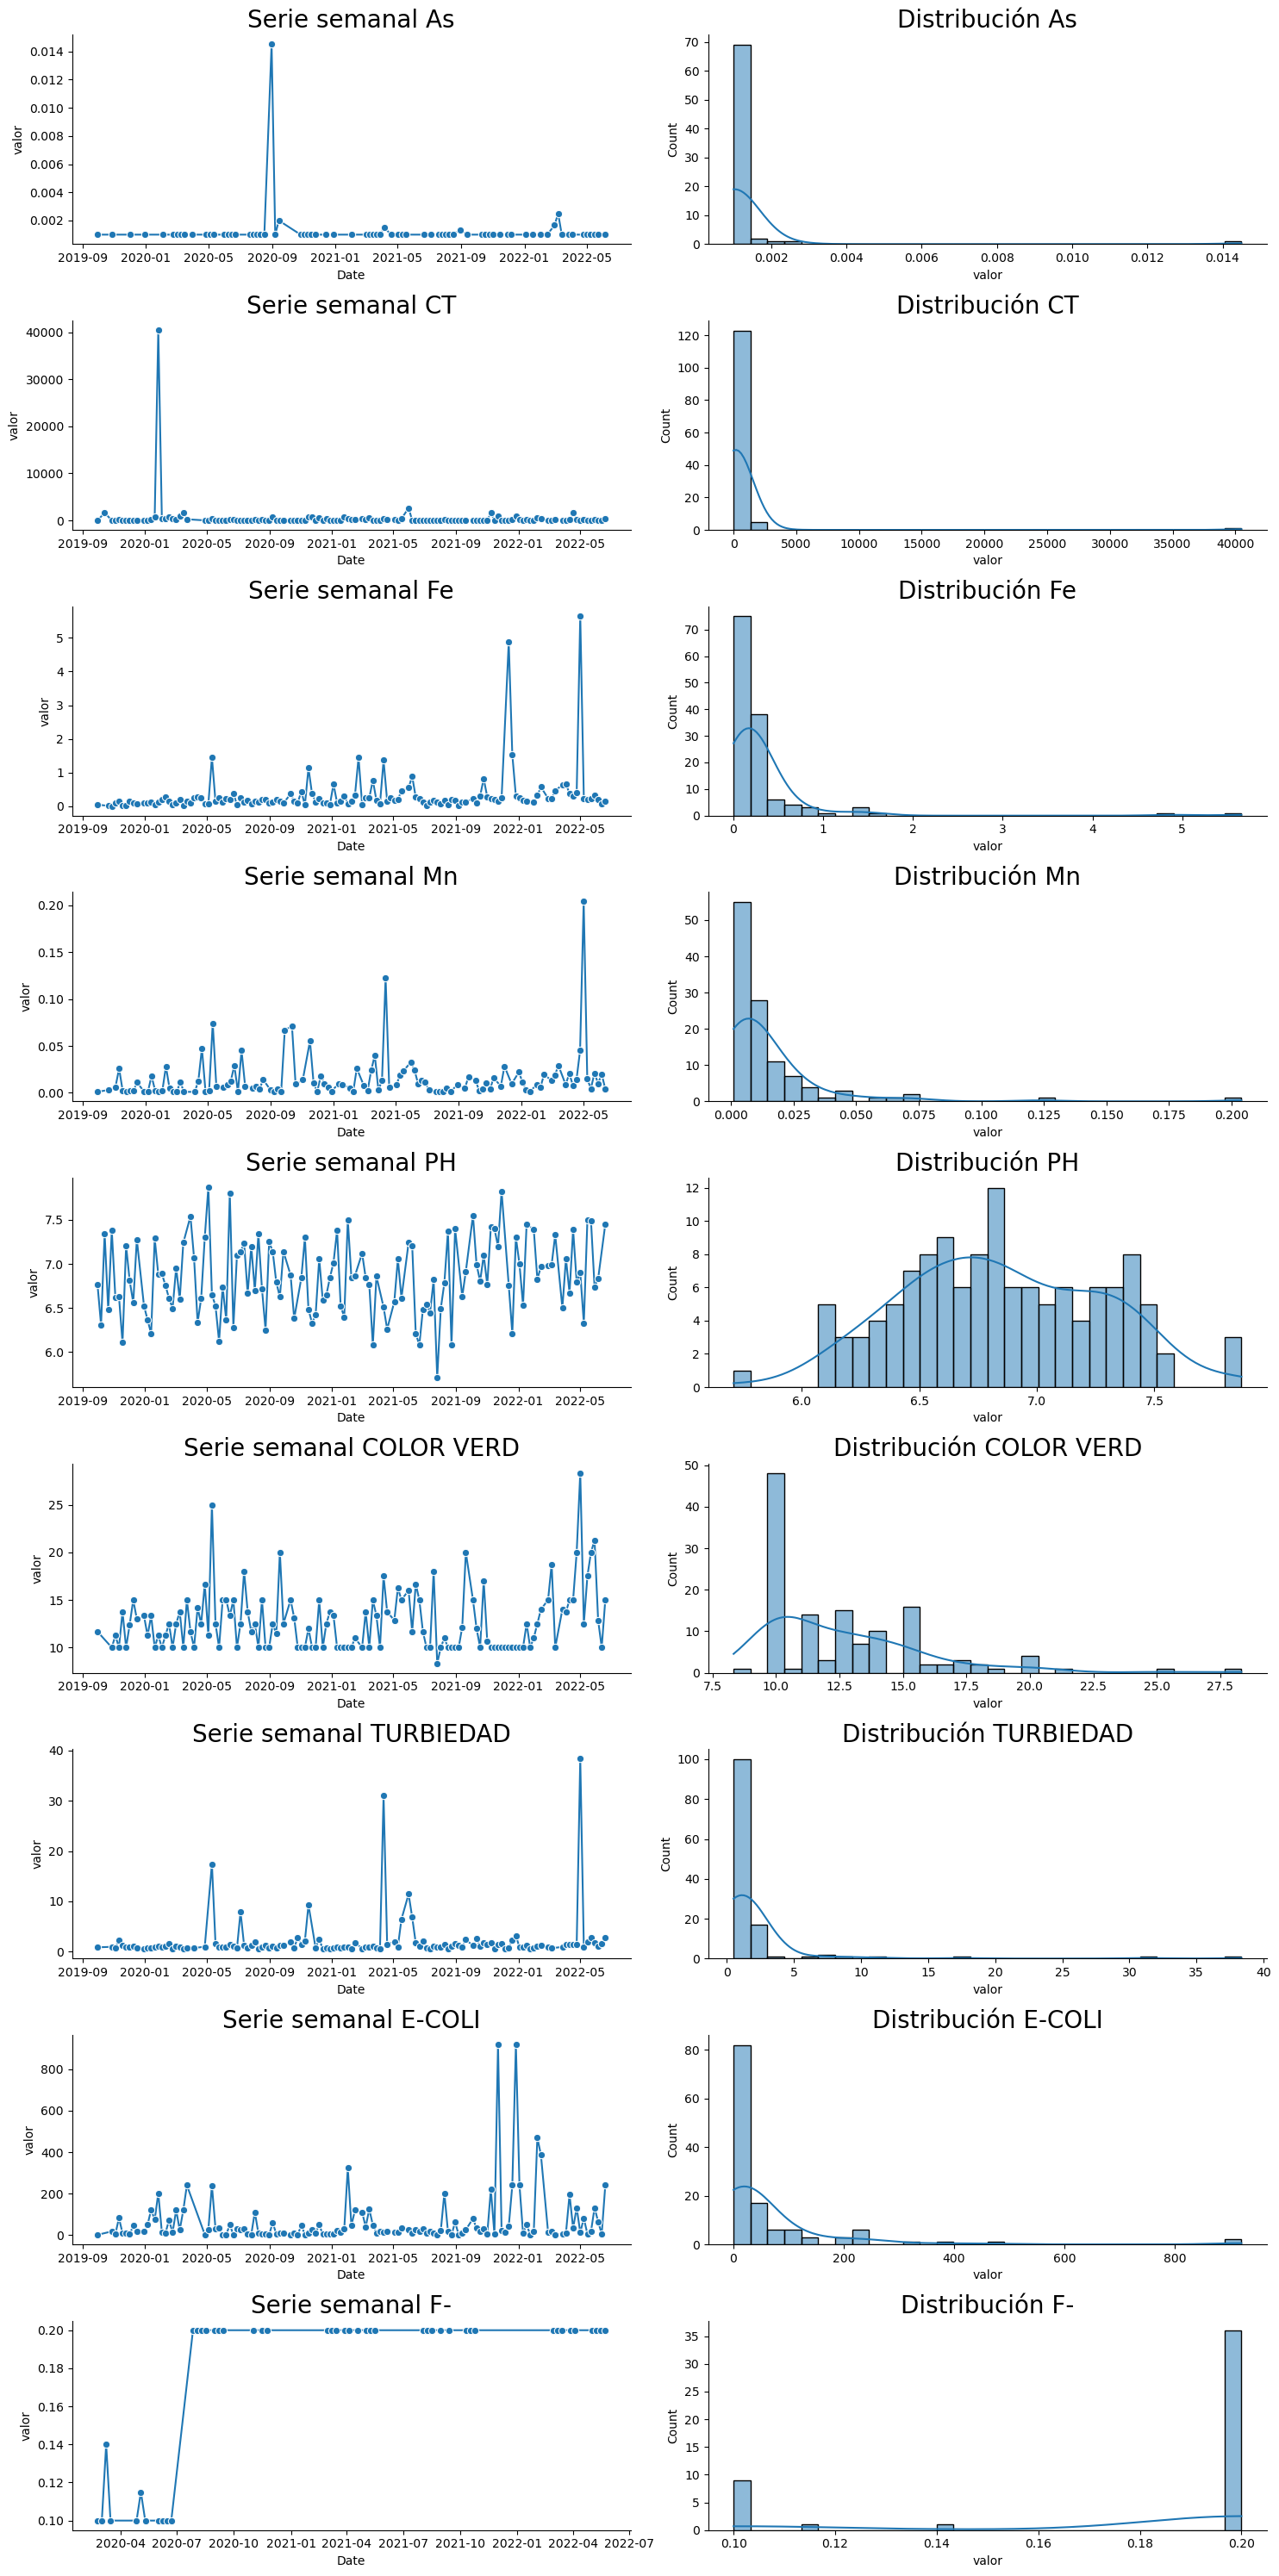

In [25]:
fig, ax = plt.subplots(weekly.codigo_parametro.nunique(), 2, figsize = (15,30))
for i, codigo in enumerate(weekly.codigo_parametro.unique()):#[x for x in test_df.codigo_parametro.unique() if x != 'CT']:
    sn.lineplot(x = 'Date', y = 'valor', data = weekly[weekly.codigo_parametro == codigo].reset_index(), ax = ax[i, 0], marker='o')
    sn.histplot(weekly[weekly.codigo_parametro == codigo].valor, ax = ax[i,1], bins = 30, kde = True)
    ax[i,0].set_title(f'Serie semanal {codigo}', fontsize = 20)
    ax[i,1].set_title(f'Distribución {codigo}', fontsize = 20)
    sn.despine()
plt.tight_layout()

In [26]:
weekly_pivoted = pd.pivot_table(data = weekly, index = 'Date', columns = 'codigo_parametro', values = 'valor')

In [27]:
weekly_pivoted.head(20)

codigo_parametro     As  COLOR VERD            CT      E-COLI  F-        Fe  \
Date                                                                          
2019-09-30        0.001   11.666667      5.533333    0.750000 NaN  0.046500   
2019-10-07          NaN         NaN           NaN         NaN NaN       NaN   
2019-10-14          NaN         NaN   1600.000000         NaN NaN       NaN   
2019-10-21          NaN         NaN           NaN         NaN NaN  0.010000   
2019-10-28        0.001   10.000000     17.400000   17.400000 NaN  0.002000   
2019-11-04          NaN   11.250000     32.133333    4.160000 NaN  0.085333   
2019-11-11          NaN   10.000000    123.933333   82.100000 NaN  0.145000   
2019-11-18          NaN   13.750000     23.000000    8.866667 NaN  0.020333   
2019-11-25          NaN   10.000000     14.900000    7.150000 NaN  0.031750   
2019-12-02        0.001   12.400000      5.280000    2.880000 NaN  0.150667   
2019-12-09          NaN   15.000000     64.000000   46.000000 NaN  0.107333   
2019-12-16          NaN   13.000000     23.000000   15.666667 NaN  0.058333   
2019-12-30        0.001   13.333333     42.920000   17.420000 NaN  0.096250   
2020-01-06          NaN   11.250000     88.500000   49.450000 NaN  0.099250   
2020-01-13          NaN   13.333333    122.933333  121.600000 NaN  0.117333   
2020-01-20          NaN   10.000000    803.900000   73.900000 NaN  0.037500   
2020-01-27          NaN   11.250000  40487.950000  201.575000 NaN  0.128333   
2020-02-03        0.001   10.000000    447.750000   13.950000 NaN  0.192333   
2020-02-10          NaN   11.250000    441.875000    8.400000 NaN  0.272500   
2020-02-17          NaN   12.500000    816.500000   71.500000 NaN  0.143333   

codigo_parametro        Mn        PH  TURBIEDAD  
Date                                             
2019-09-30        0.001000  6.767500   0.850000  
2019-10-07             NaN  6.308000        NaN  
2019-10-14             NaN  7.345000        NaN  
2019-10-21        0.003000  6.480000        NaN  
2019-10-28             NaN  7.380000   0.950000  
2019-11-04        0.006333  6.618333   0.725000  
2019-11-11        0.026000  6.633333   2.350000  
2019-11-18        0.002000  6.106000   1.166667  
2019-11-25        0.001500  7.207500   0.825000  
2019-12-02        0.002000  6.810000   0.880000  
2019-12-09        0.002500  6.560000   1.125000  
2019-12-16        0.011000  7.278000   0.783333  
2019-12-30        0.001000  6.525000   0.580000  
2020-01-06        0.001000  6.365000   0.675000  
2020-01-13        0.018000  6.210000   0.683333  
2020-01-20        0.002500  7.290000   0.850000  
2020-01-27        0.001000  6.880000   1.075000  
2020-02-03        0.002000  6.890000   0.925000  
2020-02-10        0.028000  6.756667   1.087500  
2020-02-17        0.005000  6.610000   1.550000

In [28]:
weekly_pivoted.describe()

codigo_parametro         As  COLOR VERD            CT      E-COLI         F-  \
count             74.000000  132.000000    129.000000  128.000000  47.000000   
mean               0.001236   12.729942    536.811055   64.708721   0.177766   
std                0.001580    3.264024   3567.547817  134.780194   0.041070   
min                0.001000    8.333333      1.800000    0.750000   0.100000   
25%                0.001000   10.000000     17.400000    7.157500   0.200000   
50%                0.001000   12.071429     51.400000   17.926667   0.200000   
75%                0.001000   14.375000    249.800000   49.512500   0.200000   
max                0.014500   28.333333  40487.950000  920.000000   0.200000   

codigo_parametro          Fe          Mn          PH   TURBIEDAD  
count             133.000000  115.000000  128.000000  126.000000  
mean                0.324579    0.015154    6.848865    2.113335  
std                 0.674812    0.025166    0.424484    4.681766  
min                 0.002000    0.001000    5.710000    0.500000  
25%                 0.107000    0.002833    6.528750    0.768750  
50%                 0.167000    0.008667    6.823750    1.012500  
75%                 0.264667    0.017500    7.201875    1.543750  
max                 5.658333    0.204000    7.870000   38.350000

In [29]:
print('Porcentaje de valores nulos para cada parámetro')
round((weekly_pivoted.isna().sum()/weekly_pivoted.shape[0]*100).sort_values(ascending = False), 2)

Porcentaje de valores nulos para cada parámetro


codigo_parametro
F-            65.69
As            45.99
Mn            16.06
TURBIEDAD      8.03
E-COLI         6.57
PH             6.57
CT             5.84
COLOR VERD     3.65
Fe             2.92
dtype: float64

In [30]:
weekly_pivoted.dropna().index

DatetimeIndex(['2020-02-24', '2020-03-02', '2020-03-09', '2020-03-16',
               '2020-04-27', '2020-05-11', '2020-06-01', '2020-06-08',
               '2020-06-15', '2020-06-22', '2020-07-27', '2020-08-03',
               '2020-08-10', '2020-08-17', '2020-08-31', '2020-09-07',
               '2020-09-14', '2020-11-02', '2020-11-16', '2021-03-01',
               '2021-03-08', '2021-03-15', '2021-03-29', '2021-04-19',
               '2021-05-03', '2021-05-10', '2021-05-17', '2021-08-02',
               '2021-08-09', '2021-08-16', '2021-08-30', '2021-09-13',
               '2021-10-11', '2021-10-18', '2021-10-25', '2022-02-28',
               '2022-03-07', '2022-03-28', '2022-04-04', '2022-05-02',
               '2022-05-09', '2022-05-16', '2022-05-23'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [31]:
weekly_pivoted.shape

(137, 9)

In [32]:
weekly_pivoted.dropna(subset = ['Fe', 'COLOR VERD', 'CT', 'PH', 'E-COLI', 'TURBIEDAD']).shape

(118, 9)

### Observaciones

Un modelamiento preliminar que se planeaba realizar era a-temporal considerando las mediciones de todos los parámetros medidos en una semana por la planta de aguas servidas para predecir uno o más parámetros de la planta de agua potable, sin embargo, se puede observar que no solo hay varios parámetros que no fueron medidos en todas las semanas, sino que algunos fueron medidos muy pocas fechas en total, lo que implica que tratar de conformar una martiz densa de datos es imposible sin perder 2/3 de los datos.
La solución más razonable (y con la que se realizará el primer modelamiento) es entrenar al modelo pero considerando una agrupación a nivel de día, de manera de mostrarle al modelo mayor cantidad de ejemplos, y luego evaluar en una agrupación semanal.

Otra solución es considerar solo aquellos parámetros con menor cantidad de fechas nulas y agregar como se mostró previamente a nivel de semana:

> - Fe
> - COLOR VERD
> - CT
> - PH
> - E-COLI
> - TURBIEDAD


Para los modelos que consideren el indice temporal de las variables se usarán agregadas a nivel de semana.

-----------

## Lectura de datos

In [33]:
def preproc_data_weekly2(data, target = 'valor', date_col = 'fecha_muestra',attr_col = 'codigo_parametro', localidad_col = 'codigoLocalidad',
                        user_classes = ['Fe', 'COLOR VERD', 'CT', 'PH', 'E-COLI', 'TURBIEDAD'], 
                        drop_NaN_classes = True, use_lag = False, lag = 3):
    df = copy(data) #@
    df.dropna(subset = target, inplace = True)
    
    # columna entregada en date_col debe seguir formato yyyy-mm-dd
    df.fecha_muestra = pd.to_datetime(df[date_col], format = '%Y-%m-%d')
    
    # Shift de 7 dias para que las mediciones aparezcan como tomadas al principio de la correspondiente semana
    df['Date'] = pd.to_datetime(df[date_col]) - pd.to_timedelta(7, unit='d') 
    
    weekly = df.groupby([
        attr_col, pd.Grouper(key='Date', freq='W-MON')])[target]\
                                                                        .mean()\
                                                                        .reset_index()\
                                                                       .sort_values('Date')
    weekly_pivoted = pd.pivot_table(data = weekly, index = 'Date', columns = attr_col, values = target)[user_classes]
    weekly_pivoted.columns.name =  None
    #weekly_pivoted[localidad_col] = weekly_pivoted[localidad_col].astype('O') # transformar columna de localidad a objeto para poder aplicar Dummy Encoding

    if drop_NaN_classes: # Para obtener una matriz de atributos siempre densa
        weekly_pivoted.dropna(inplace = True)
    
    return weekly_pivoted
    
    
    

Ingesta de datos de PR18-2 y PR14

In [34]:
pr14_files = glob('modeloRiesgoAmbiental/DATOS INTERNOS TOTAL LOCALIDADES/Historial PR14 Muestras/*.csv')
pr14 = pd.concat([pd.read_csv(file, index_col=0) for file in pr14_files], axis = 0)

In [35]:
pr14_processed = preproc_data_weekly2(pr14, drop_NaN_classes=False)

In [36]:
pr14_processed.shape

(275, 6)

In [37]:
pr14_processed.describe()

Fe    COLOR VERD           CT           PH  E-COLI   TURBIEDAD
count  213.000000    144.000000   269.000000   257.000000   274.0  274.000000
mean     0.095088    305.278356    18.049890   130.204907     0.0    9.352049
std      0.049919   1759.779798   126.090893   885.676826     0.0   74.916454
min      0.002000      5.000000     0.886364     6.691429     0.0    0.378421
25%      0.056000     10.000000     1.000000     6.936000     0.0    0.637231
50%      0.097000     10.000000     1.000000     7.020000     0.0    0.745666
75%      0.126333     10.000000     1.000000     7.130000     0.0    0.901140
max      0.304500  12500.000000  1000.000000  7175.000000     0.0  832.510526

In [434]:
pr18_files = glob('modeloRiesgoAmbiental/DATOS INTERNOS TOTAL LOCALIDADES/Historial PR18-2 Muestras/*.csv')
pr18 = pd.concat([pd.read_csv(file, index_col=0) for file in pr18_files], axis = 0)
pr18_processed = preproc_data_weekly2(pr18, drop_NaN_classes=False)

In [40]:
pr18_processed.shape

(137, 6)

In [41]:
pr18_processed.describe()

Fe  COLOR VERD            CT          PH      E-COLI  \
count  133.000000  132.000000    129.000000  128.000000  128.000000   
mean     0.324579   12.729942    536.811055    6.848865   64.708721   
std      0.674812    3.264024   3567.547817    0.424484  134.780194   
min      0.002000    8.333333      1.800000    5.710000    0.750000   
25%      0.107000   10.000000     17.400000    6.528750    7.157500   
50%      0.167000   12.071429     51.400000    6.823750   17.926667   
75%      0.264667   14.375000    249.800000    7.201875   49.512500   
max      5.658333   28.333333  40487.950000    7.870000  920.000000   

        TURBIEDAD  
count  126.000000  
mean     2.113335  
std      4.681766  
min      0.500000  
25%      0.768750  
50%      1.012500  
75%      1.543750  
max     38.350000

In [42]:
joined_processed_data_weekly = pr18_processed.join(other = pr14_processed, how = 'left', rsuffix = '_target')

In [43]:
joined_processed_data_weekly.head()

Fe  COLOR VERD           CT      PH  E-COLI  TURBIEDAD  \
Date                                                                     
2019-09-30  0.0465   11.666667     5.533333  6.7675    0.75       0.85   
2019-10-07     NaN         NaN          NaN  6.3080     NaN        NaN   
2019-10-14     NaN         NaN  1600.000000  7.3450     NaN        NaN   
2019-10-21  0.0100         NaN          NaN  6.4800     NaN        NaN   
2019-10-28  0.0020   10.000000    17.400000  7.3800   17.40       0.95   

            Fe_target  COLOR VERD_target  CT_target  PH_target  E-COLI_target  \
Date                                                                            
2019-09-30   0.056400                NaN        1.0   6.967143            0.0   
2019-10-07   0.029000                NaN        1.0   6.866667            0.0   
2019-10-14   0.056000               10.0        1.0   6.925000            0.0   
2019-10-21   0.023917                NaN        1.0   6.866000            0.0   
2019-10-28   0.013000                NaN        1.0   6.848571            0.0   

            TURBIEDAD_target  
Date                          
2019-09-30          0.673333  
2019-10-07          1.054444  
2019-10-14          0.670690  
2019-10-21          0.977742  
2019-10-28          1.061538

In [44]:
target_cols_weekly = joined_processed_data_weekly.loc[:, joined_processed_data_weekly.columns.str.contains('target')].reset_index()\
                                                                                    .drop(columns = ['Date'])
attr_cols_weekly = joined_processed_data_weekly.loc[:, joined_processed_data_weekly.columns.str.contains('target')].reset_index()\
                                                                                    .drop(columns = ['Date'])

### Chequeo de estacionalidad de las series

Antes de comenzar con el modelamiento vale la pena hacer una verificación de estacionalidad de la serie, si las series para cada localidad y parámetro son estacionales entonces un modelo sin parámetros dependientes de la historia tendrían un poco más de fundamento.

/Users/ignacio/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


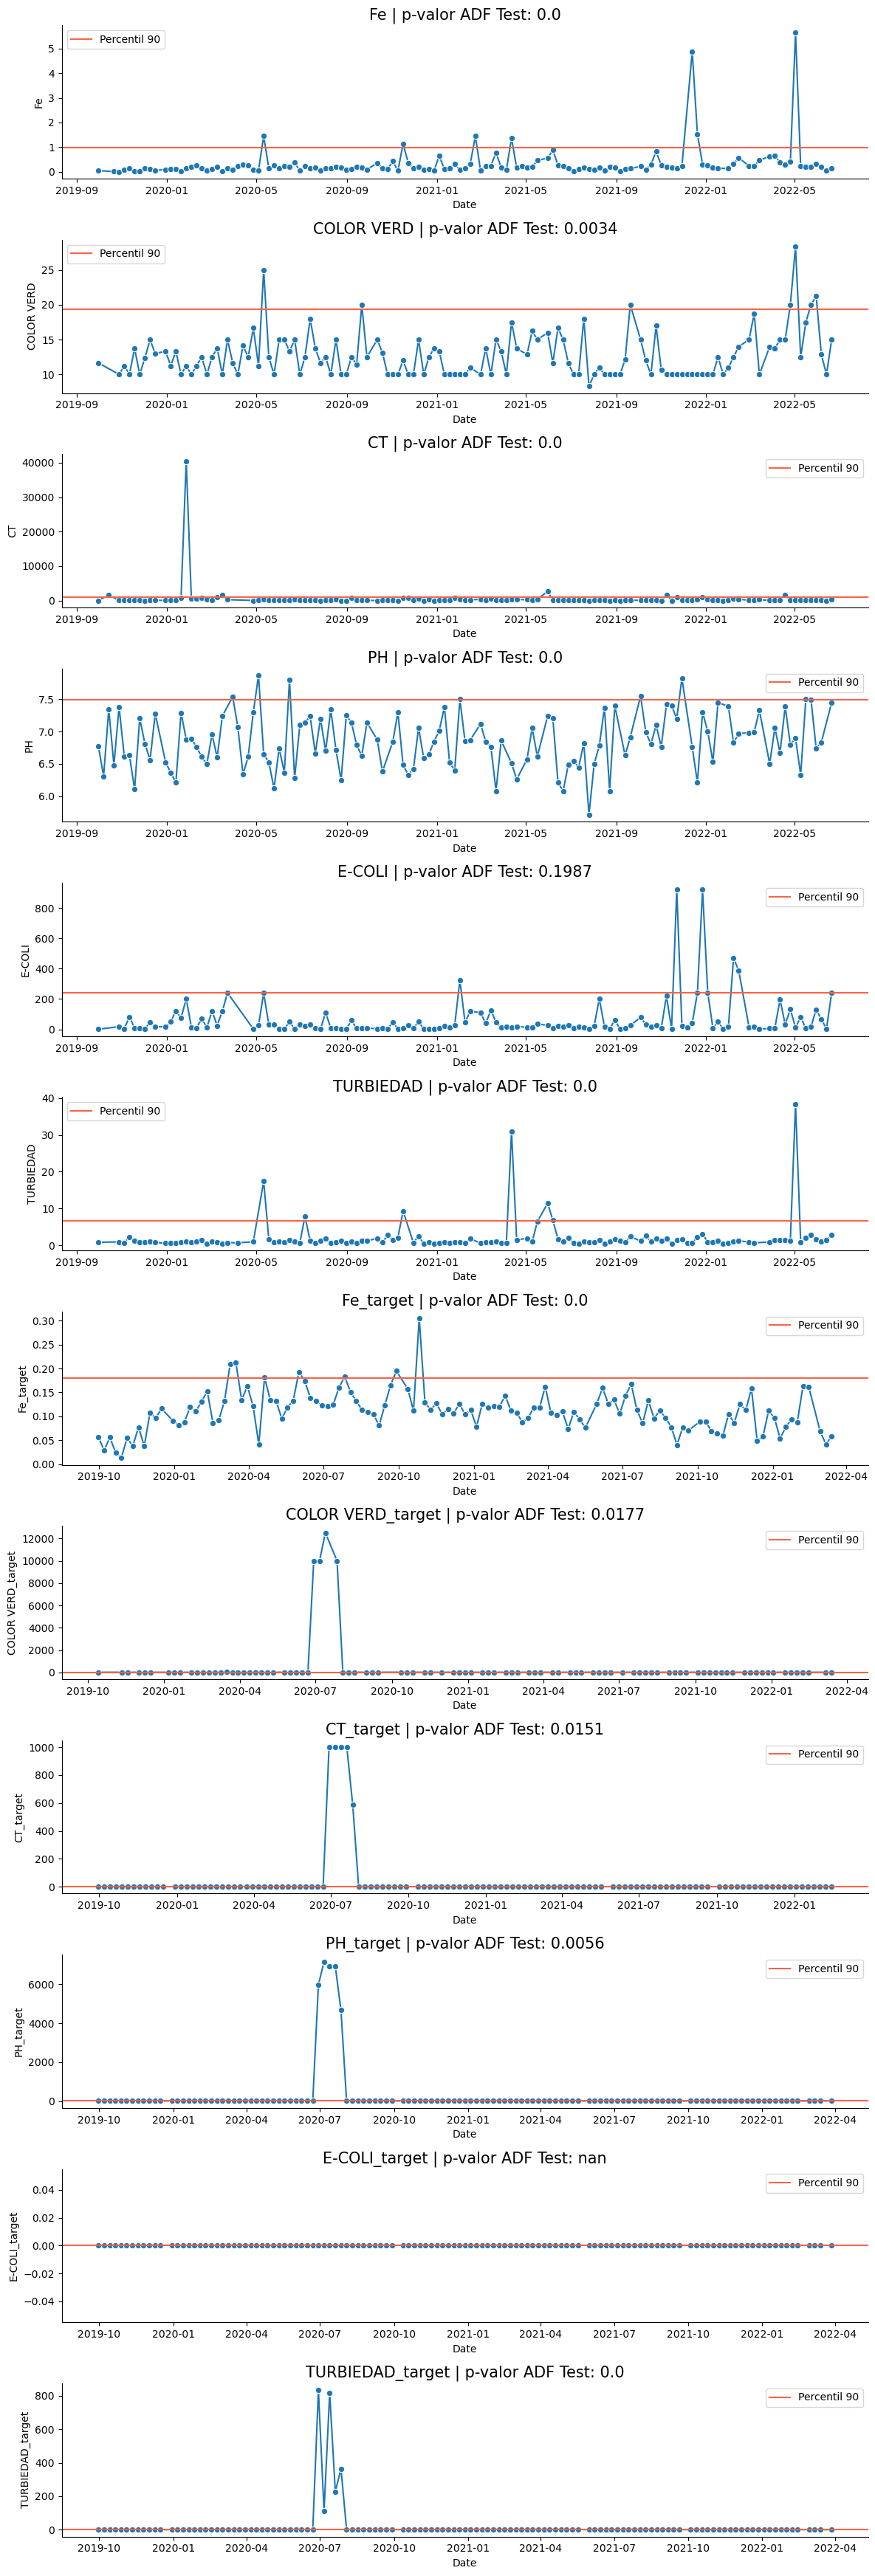

In [46]:
fig, ax = plt.subplots(joined_processed_data_weekly.shape[1], 1, figsize = (12,35))
for i, col_name in enumerate(joined_processed_data_weekly.columns):#[x for x in test_df.codigo_parametro.unique() if x != 'CT']:
    sn.lineplot(x = 'Date', y = col_name, data = joined_processed_data_weekly.reset_index(), ax = ax[i], marker='o')
    ax[i].axhline(joined_processed_data_weekly[col_name].quantile(0.95), color = 'tomato', label = 'Percentil 90')
    ax[i].set_title(col_name + f' | p-valor ADF Test: {round(ts.adfuller(joined_processed_data_weekly[col_name].dropna())[1],4)}', fontsize = 15)
    ax[i].legend()
    sn.despine()
plt.tight_layout()

Al parecer en gran parte de las series se puede rechazar la hipotesis nula (Hay no-estacionaridad) con suficiente confianza (> 95%) con la excepción de la serie de PH (medido en la planta de Aguas Servidas) donde al parecer si hay no-estacionaridad y E-COLI_target (Medida en la planta de Agua Potable) donde el valor de E-COLI que sale de la planta es siempre 0 por lo que no tiene sentido predecirlo.
Para la mayoría de las columnas tomar le percentil 90 parece un umbral razonable para eliminar valores extremos ya que claramente hubo algunos períodos que presentaron mediciones fuera de lo que parece ser la tendencia natural de la variable, antes de modelar se filtrarán todos aquellos valores mayores al percentil 90 (excepto para PH y COLOR-VERD donde estos valores se ven como parte del comportamiento natural de la variable).

Con esta informaión se estima que es de utilidad generar los siguientes modelos:

__Agnósticos al tiempo (PR182 --> PR14):__
> - __Target 1: Fe (PR14)__
>> - Attr1: Fe (PR18-2)
>> - Attr2: Todas desde PR18-2
> - __Target 2: PH (PR14)__
>> - Attr1: PH (PR18-2)
>> - Attr2: Todas desde PR18-2

__Considerando la historia (como serie de tiempo):__
> - __Target 1: E-COLI (PR18-2)__
>> - Propia historia (autoregresivo)
>> - Propia historia + resto de PR18-2
> - __Target 1: COLOR VERD (PR18-2)__
>> - Propia historia (autoregresivo)
>> - Propia historia + resto de PR18-2
> - __Target 1: TURBIEDAD (PR18-2)__
>> - Propia historia (autoregresivo)
>> - Propia historia + resto de PR18-2
> - __Target 2: Fe (PR14)__
>> - Attr1: Todas desde PR18-2 + propia historia
> - __Target 3: Fe (PR18-2)__
>> - Attr1: Propia historia
>> - Attr2: Propia historia + resto de variables de PR18.2



# Modelamiento

### Modelos agnósticos al tiempo

Los siguientes modelos predicen la cantidad de un parámetro que saldrá de la planta de agua potable a partir de las mediciones realizadas en la planta de aguas servidas para una misma semana:

In [257]:
attr_list = ['Fe', 'TURBIEDAD', 'CT', 'E-COLI', 'COLOR VERD']
target_cols = ['PH_target', 'Fe_target', 'E-COLI_target', 'TURBIEDAD_target']

In [48]:
def preproc_data_noHistory(data, target = 'valor', date_col = 'fecha_muestra', attr_col = 'codigo_parametro',
                        user_classes = ['Fe', 'COLOR VERD', 'CT', 'PH', 'E-COLI', 'TURBIEDAD'], 
                        drop_NaN_classes = True, date_freq = 'D'):
    df = copy(data) 
    df.dropna(subset = target, inplace = True)
    
    # columna entregada en date_col debe seguir formato yyyy-mm-dd
    df.fecha_muestra = pd.to_datetime(df[date_col], format = '%Y-%m-%d')
    
    grouped = df.groupby([
        attr_col, pd.Grouper(key=date_col, freq=date_freq)])[target]\
                                                                        .mean()\
                                                                        .reset_index()\
                                                                        .sort_values(by = date_col)

#    return pd.DataFrame(grouped)
    grouped_pivoted = pd.pivot_table(data = grouped, index = date_col, columns = attr_col, values = target)[user_classes]
    grouped_pivoted.columns.name =  None
    #weekly_pivoted[localidad_col] = weekly_pivoted[localidad_col].astype('O') # transformar columna de localidad a objeto para poder aplicar Dummy Encoding

    if drop_NaN_classes: # Para obtener una matriz de atributos siempre densa
        grouped_pivoted.dropna(inplace = True)
    
    return grouped_pivoted
    

In [49]:
pr14_daily_proc = preproc_data_noHistory(pr14)
pr18_daily_proc = preproc_data_noHistory(pr18)

In [243]:
pr14_daily_proc

Fe  COLOR VERD   CT        PH  E-COLI  TURBIEDAD
fecha_muestra                                                      
2017-03-08     0.1780         5.0  1.0  6.820000     0.0   0.635714
2017-04-11     0.1100        10.0  1.0  7.220000     0.0   0.966667
2017-04-17     0.0020         5.0  1.0  7.130000     0.0   0.641667
2017-04-26     0.0020         5.0  1.0  7.960000     0.0   0.405556
2017-05-17     0.2050        15.0  1.0  7.010000     0.0   0.850000
...               ...         ...  ...       ...     ...        ...
2022-02-01     0.0525        10.0  1.0  7.145000     0.0   0.670000
2022-02-14     0.1090        10.0  1.0  7.580000     0.0   0.625000
2022-02-21     0.2630        10.0  1.0  7.173333     0.0   0.804167
2022-02-23     0.0460        10.0  1.0  7.760000     0.0   0.680000
2022-02-24     0.0420        15.0  1.0  7.150000     0.0   0.590000

[204 rows x 6 columns]

In [241]:
noHistory_base_daily = pr18_daily_proc.reset_index().set_index('fecha_muestra').join(pr14_daily_proc.reset_index()\
                                                                                   .set_index('fecha_muestra'), lsuffix = '_target').reset_index()


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
model_list = [RandomForestRegressor(), AdaBoostRegressor(), SVR()]

In [57]:
noHistory_base_daily.describe()

Fe_target  COLOR VERD_target     CT_target   PH_target  E-COLI_target  \
count  168.000000         168.000000    168.000000  168.000000     168.000000   
mean     0.369247          13.426729    476.241528    6.837153      64.959036   
std      0.945637           4.633039   3163.153195    0.531446     139.033914   
min      0.002000           8.333333      1.800000    5.210000       0.750000   
25%      0.088625          10.000000     12.575000    6.507500       5.756250   
50%      0.175125          12.500000     43.766667    6.835000      13.000000   
75%      0.288375          15.000000    240.000000    7.242500      56.725000   
max      9.583667          50.000000  40487.950000    8.400000     920.000000   

       TURBIEDAD_target         Fe    COLOR VERD           CT           PH  \
count        168.000000  64.000000     64.000000    64.000000    64.000000   
mean           2.619670   0.131547    362.291667    32.228977   227.420318   
std            8.146136   0.081866   1983.493741   175.190893  1236.714609   
min            0.500000   0.039500     10.000000     1.000000     6.520000   
25%            0.700000   0.087000     10.000000     1.000000     6.937500   
50%            0.966667   0.117250     10.000000     1.000000     7.108750   
75%            1.512500   0.153375     10.000000     1.000000     7.251667   
max           75.000000   0.593000  12500.000000  1000.000000  7210.000000   

       E-COLI   TURBIEDAD  
count    64.0   64.000000  
mean      0.0   11.921669  
std       0.0   88.820820  
min       0.0    0.505000  
25%       0.0    0.657404  
50%       0.0    0.802083  
75%       0.0    0.925179  
max       0.0  711.383333

In [59]:
#y_base = noHistory_base_mat.loc[:,noHistory_base_mat.columns.str.contains('target')].drop(columns = ['ServicioCalidad_target'])
#x_base = noHistory_base_mat.loc[:,~noHistory_base_mat.columns.str.contains('target')].drop(columns = ['ServicioCalidad', 'fecha_muestra'])

train_results_daily = {target_name: {'data_shape': [], 'models':{type(x).__name__:{} for x in model_list}} for target_name in target_cols}

for param_target in target_cols:
#    aux_df = pd.concat([x_base,y_base[param_target]], axis = 1).dropna()
 #   aux_df.loc[:, aux_df.columns.str.contains('target')]
    aux_df = noHistory_base_daily[attr_list + [param_target]]\
                    .loc[noHistory_base_daily[param_target]<=noHistory_base_daily[param_target].quantile(0.9) ,:].dropna()
    x_train, x_test, y_train, y_test = train_test_split(aux_df[attr_list], aux_df[param_target], test_size = 0.3, random_state = SEED)
    train_results_daily[param_target]['data_shape'] = {'n_train': x_train.shape[0], 'n_test': x_test.shape[0]}
    for model in model_list:
        model.fit(x_train, y_train)
        train_results_daily[param_target]['models'][type(model).__name__]['MAE'] = np.round(mean_absolute_error(y_test, model.predict(x_test)), 3)
        train_results_daily[param_target]['models'][type(model).__name__]['MSE'] = np.round(mean_squared_error(y_test, model.predict(x_test)), 3)
        

In [61]:
train_results_daily

{'PH_target': {'data_shape': {'n_train': 41, 'n_test': 18},
  'models': {'RandomForestRegressor': {'MAE': 0.483, 'MSE': 0.398},
   'AdaBoostRegressor': {'MAE': 0.464, 'MSE': 0.349},
   'SVR': {'MAE': 0.46, 'MSE': 0.314}}},
 'Fe_target': {'data_shape': {'n_train': 40, 'n_test': 18},
  'models': {'RandomForestRegressor': {'MAE': 0.147, 'MSE': 0.034},
   'AdaBoostRegressor': {'MAE': 0.15, 'MSE': 0.035},
   'SVR': {'MAE': 0.118, 'MSE': 0.026}}},
 'E-COLI_target': {'data_shape': {'n_train': 38, 'n_test': 17},
  'models': {'RandomForestRegressor': {'MAE': 25.002, 'MSE': 1018.543},
   'AdaBoostRegressor': {'MAE': 27.951, 'MSE': 986.033},
   'SVR': {'MAE': 22.566, 'MSE': 698.658}}},
 'TURBIEDAD_target': {'data_shape': {'n_train': 38, 'n_test': 17},
  'models': {'RandomForestRegressor': {'MAE': 0.602, 'MSE': 0.483},
   'AdaBoostRegressor': {'MAE': 0.549, 'MSE': 0.442},
   'SVR': {'MAE': 0.549, 'MSE': 0.422}}}}

### Modelos Semanales

Estos modelos están entrenados de forma ingenua para utilizar las mediciones de una semana para predecir la siguiente

In [62]:
target_cols_weekly = joined_processed_data_weekly.loc[:, joined_processed_data_weekly.columns.str.contains('target')].reset_index()\
                                                                                    .drop(columns = ['Date'])
attr_cols_weekly = joined_processed_data_weekly.loc[:, ~joined_processed_data_weekly.columns.str.contains('target')].reset_index()\
                                                                                    .drop(columns = ['Date'])[attr_list]
noHistory_base_mat_weekly = pd.concat([attr_cols_weekly.shift(1), target_cols_weekly], axis = 1).loc[1:,:]

In [239]:
joined_processed_data_weekly.tail()

Fe  COLOR VERD          CT      PH      E-COLI  TURBIEDAD  \
Date                                                                         
2022-05-23  0.21200   20.000000   28.000000  7.4900   17.000000   2.800000   
2022-05-30  0.32625   21.250000  185.750000  6.7400  131.250000   1.725000   
2022-06-06  0.20150   12.857143   94.114286  6.8325   64.542857   1.135714   
2022-06-13  0.06350   10.000000    4.800000     NaN    4.800000   1.525000   
2022-06-20  0.15500   15.000000  350.000000  7.4500  240.000000   2.800000   

            Fe_target  COLOR VERD_target  CT_target  PH_target  E-COLI_target  \
Date                                                                            
2022-05-23        NaN                NaN        NaN        NaN            NaN   
2022-05-30        NaN                NaN        NaN        NaN            NaN   
2022-06-06        NaN                NaN        NaN        NaN            NaN   
2022-06-13        NaN                NaN        NaN        NaN            NaN   
2022-06-20        NaN                NaN        NaN        NaN            NaN   

            TURBIEDAD_target  
Date                          
2022-05-23               NaN  
2022-05-30               NaN  
2022-06-06               NaN  
2022-06-13               NaN  
2022-06-20               NaN

In [238]:
noHistory_base_mat_weekly

Fe  TURBIEDAD           CT      E-COLI  TURBIEDAD  COLOR VERD  \
1    0.04650   0.850000     5.533333    0.750000   0.850000   11.666667   
2        NaN        NaN          NaN         NaN        NaN         NaN   
3        NaN        NaN  1600.000000         NaN        NaN         NaN   
4    0.01000        NaN          NaN         NaN        NaN         NaN   
5    0.00200   0.950000    17.400000   17.400000   0.950000   10.000000   
..       ...        ...          ...         ...        ...         ...   
132  0.20400   1.966667    37.325000    5.075000   1.966667   17.500000   
133  0.21200   2.800000    28.000000   17.000000   2.800000   20.000000   
134  0.32625   1.725000   185.750000  131.250000   1.725000   21.250000   
135  0.20150   1.135714    94.114286   64.542857   1.135714   12.857143   
136  0.06350   1.525000     4.800000    4.800000   1.525000   10.000000   

     Fe_target  COLOR VERD_target  CT_target  PH_target  E-COLI_target  \
1     0.029000                NaN        1.0   6.866667            0.0   
2     0.056000               10.0        1.0   6.925000            0.0   
3     0.023917                NaN        1.0   6.866000            0.0   
4     0.013000                NaN        1.0   6.848571            0.0   
5     0.054833                NaN        1.0   6.787500            0.0   
..         ...                ...        ...        ...            ...   
132        NaN                NaN        NaN        NaN            NaN   
133        NaN                NaN        NaN        NaN            NaN   
134        NaN                NaN        NaN        NaN            NaN   
135        NaN                NaN        NaN        NaN            NaN   
136        NaN                NaN        NaN        NaN            NaN   

     TURBIEDAD_target  
1            1.054444  
2            0.670690  
3            0.977742  
4            1.061538  
5            0.680000  
..                ...  
132               NaN  
133               NaN  
134               NaN  
135               NaN  
136               NaN  

[136 rows x 12 columns]

In [63]:
#y_base = noHistory_base_mat.loc[:,noHistory_base_mat.columns.str.contains('target')].drop(columns = ['ServicioCalidad_target'])
#x_base = noHistory_base_mat.loc[:,~noHistory_base_mat.columns.str.contains('target')].drop(columns = ['ServicioCalidad', 'fecha_muestra'])

train_results_weekly1future = {target_name: {'data_shape': [], 'models':{type(x).__name__:{} for x in model_list}} for target_name in target_cols}

for param_target in target_cols:
#    aux_df = pd.concat([x_base,y_base[param_target]], axis = 1).dropna()
 #   aux_df.loc[:, aux_df.columns.str.contains('target')]
    aux_df = noHistory_base_mat_weekly[attr_list + [param_target]].loc[noHistory_base_mat_weekly[param_target]<=noHistory_base_mat_weekly[param_target]\
                                                                                                                                   .quantile(0.9) ,:].dropna()
    x_train, x_test, y_train, y_test = train_test_split(aux_df[attr_list], aux_df[param_target], test_size = 0.3, random_state = SEED)
    train_results_weekly1future[param_target]['data_shape'] = {'n_train': x_train.shape[0], 'n_test': x_test.shape[0]}
    for model in model_list:
        model.fit(x_train, y_train)
        train_results_weekly1future[param_target]['models'][type(model).__name__]['MAE'] = np.round(mean_absolute_error(y_test, model.predict(x_test)), 3)
        train_results_weekly1future[param_target]['models'][type(model).__name__]['MSE'] = np.round(mean_squared_error(y_test, model.predict(x_test)), 3)

In [64]:
train_results_weekly1future

{'PH_target': {'data_shape': {'n_train': 68, 'n_test': 30},
  'models': {'RandomForestRegressor': {'MAE': 0.085, 'MSE': 0.011},
   'AdaBoostRegressor': {'MAE': 0.083, 'MSE': 0.01},
   'SVR': {'MAE': 0.086, 'MSE': 0.01}}},
 'Fe_target': {'data_shape': {'n_train': 68, 'n_test': 30},
  'models': {'RandomForestRegressor': {'MAE': 0.024, 'MSE': 0.001},
   'AdaBoostRegressor': {'MAE': 0.026, 'MSE': 0.001},
   'SVR': {'MAE': 0.027, 'MSE': 0.001}}},
 'E-COLI_target': {'data_shape': {'n_train': 77, 'n_test': 33},
  'models': {'RandomForestRegressor': {'MAE': 0.0, 'MSE': 0.0},
   'AdaBoostRegressor': {'MAE': 0.0, 'MSE': 0.0},
   'SVR': {'MAE': 0.0, 'MSE': 0.0}}},
 'TURBIEDAD_target': {'data_shape': {'n_train': 70, 'n_test': 30},
  'models': {'RandomForestRegressor': {'MAE': 0.128, 'MSE': 0.027},
   'AdaBoostRegressor': {'MAE': 0.129, 'MSE': 0.03},
   'SVR': {'MAE': 0.129, 'MSE': 0.031}}}}

# Modelos Autorregresivos
Estos modelos apuntan a predecir a futuro la cantidad medida de un determinado parámetro a partir de lo medido en t pasos temporales hacia atrás, para efecto de este desarrollo se considerará como un paso temporal (lag) 1 semana.


In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import missingno

import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:>

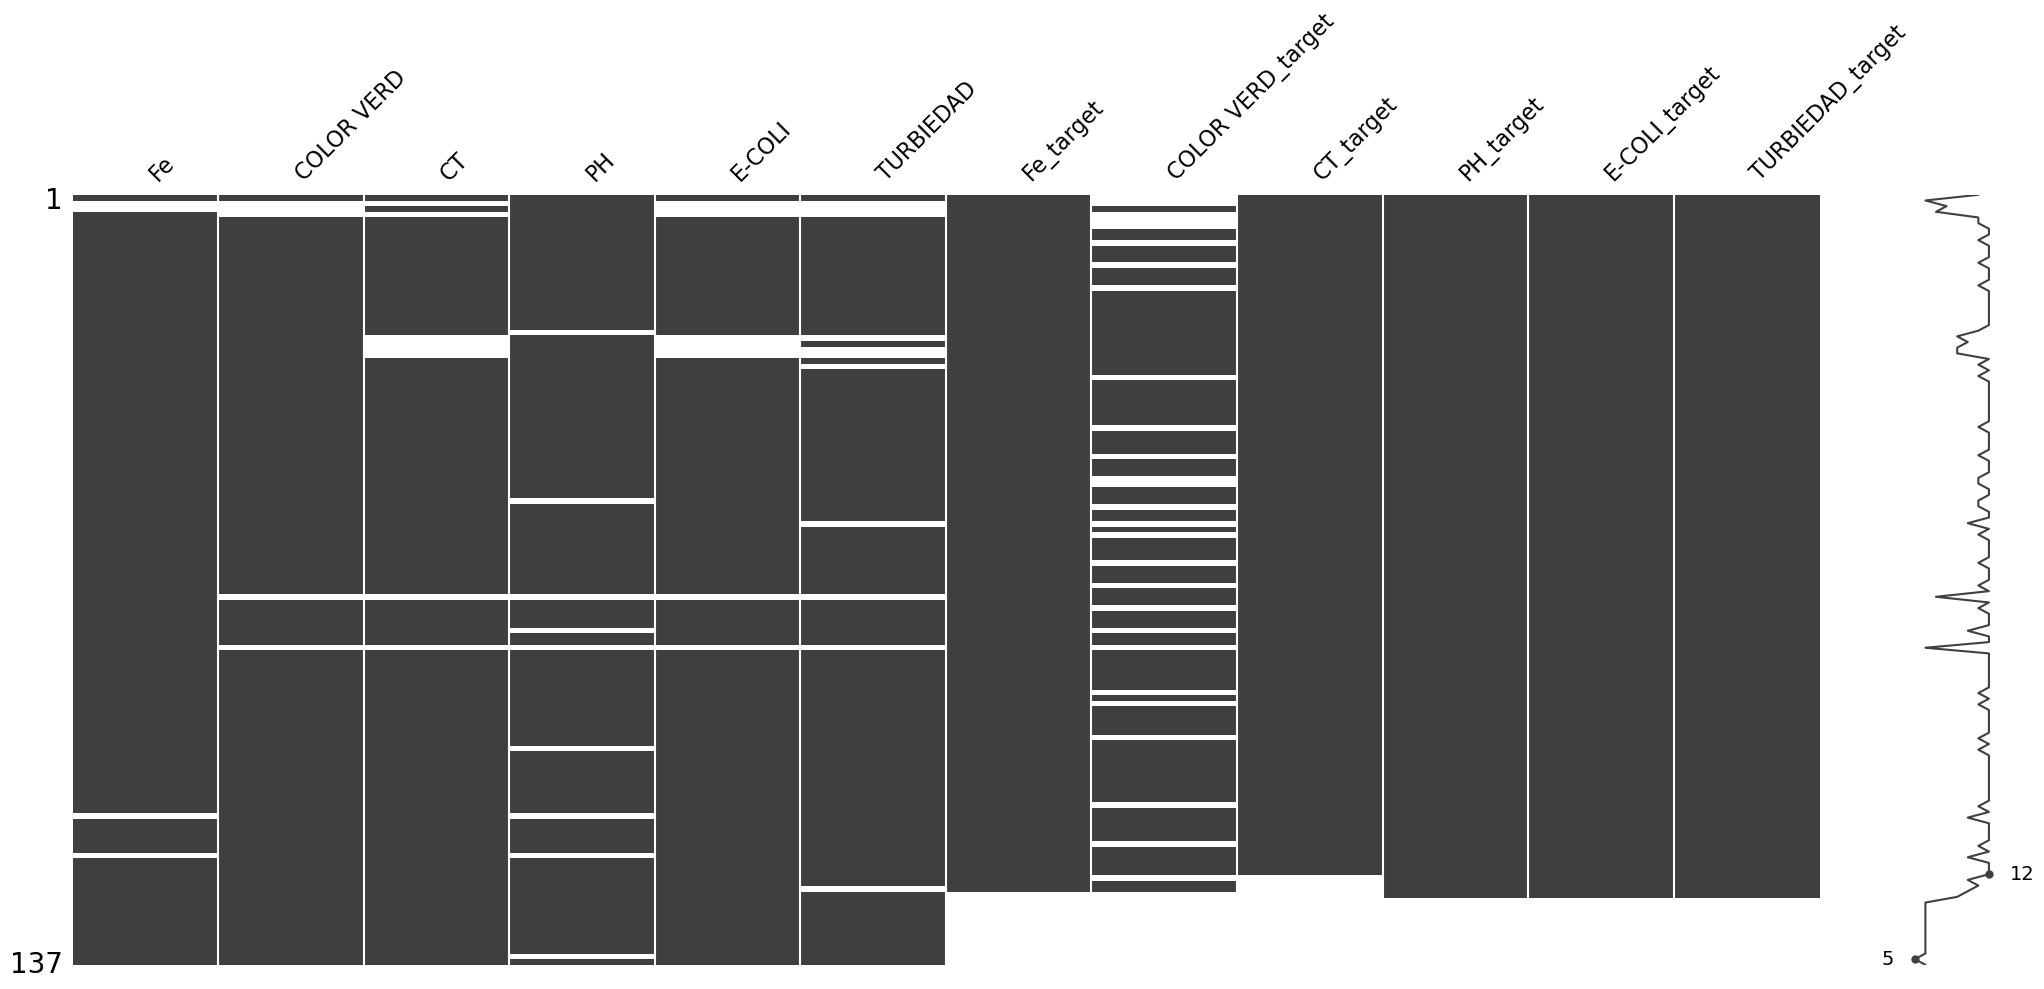

In [66]:
missingno.matrix(joined_processed_data_weekly)

las ultimas 8 semanas que se tenga de una medición como conjunto de test y el resto como entrenamiento

## E-COLI

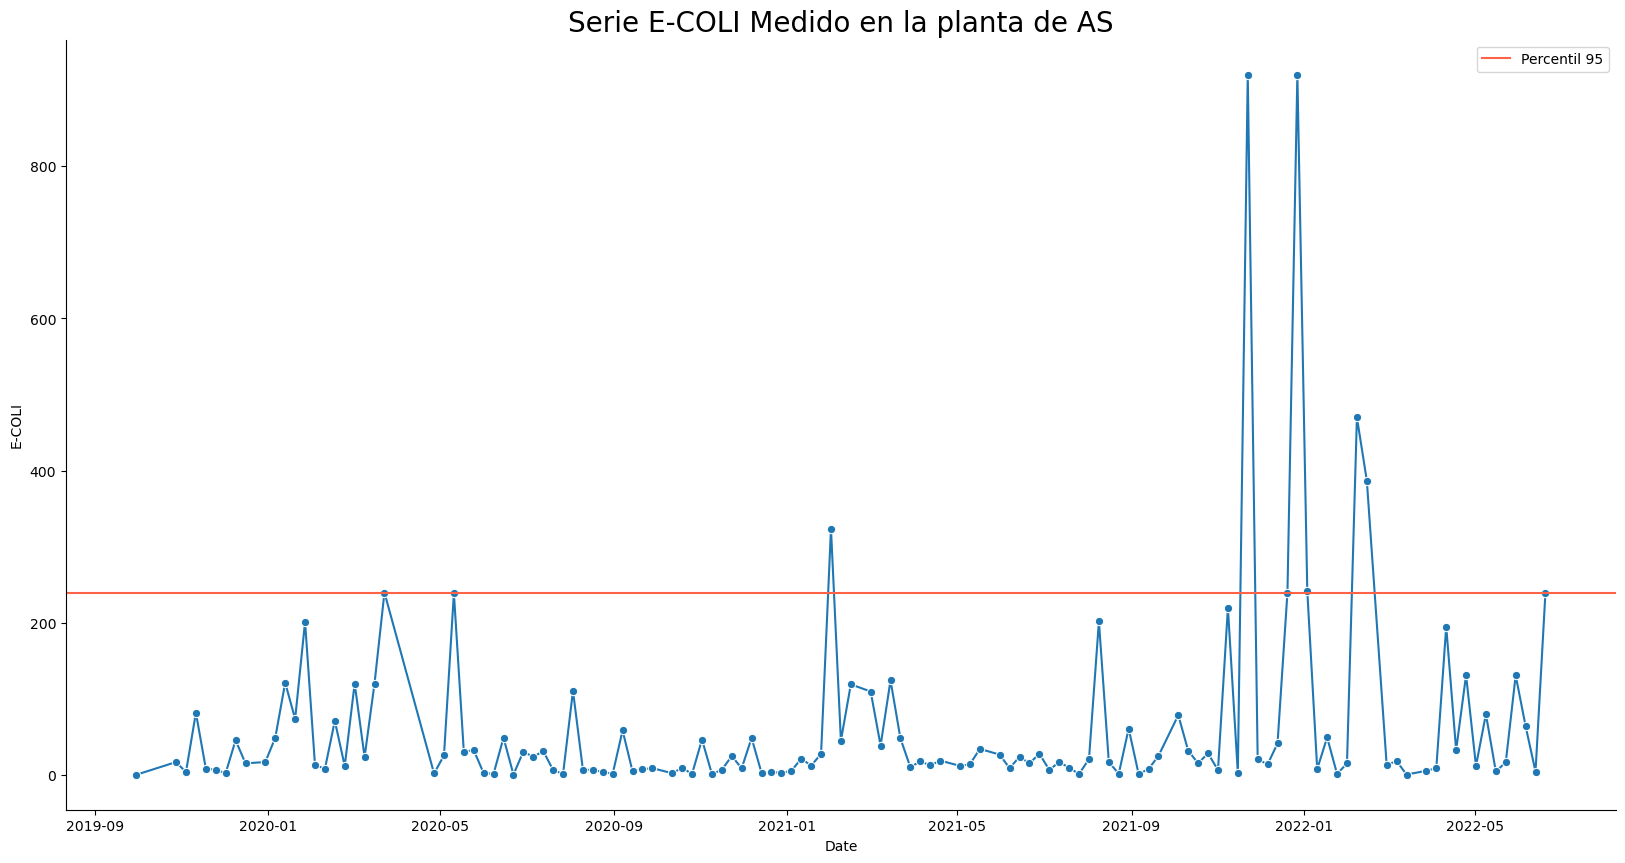

In [67]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
sn.lineplot(data = joined_processed_data_weekly['E-COLI'], marker = 'o')
plt.axhline(joined_processed_data_weekly['E-COLI'].quantile(.95), color = 'Tomato', label = 'Percentil 95')
plt.title('Serie E-COLI Medido en la planta de AS', fontsize = 20)
plt.legend()
sn.despine();

Se va a limitar los datos utilizados a solo aquellos que estén por bajo del percentil 95

In [68]:
ecoli_serie = pd.DataFrame(joined_processed_data_weekly[joined_processed_data_weekly['E-COLI'] <=  joined_processed_data_weekly['E-COLI']\
                                                        .quantile(.90)]['E-COLI'])#[:-10]

Forward-filling para las fechas que no se tienen:

In [69]:
ecoli_padded = ecoli_serie\
            .resample('W-MON')\
            .ffill()

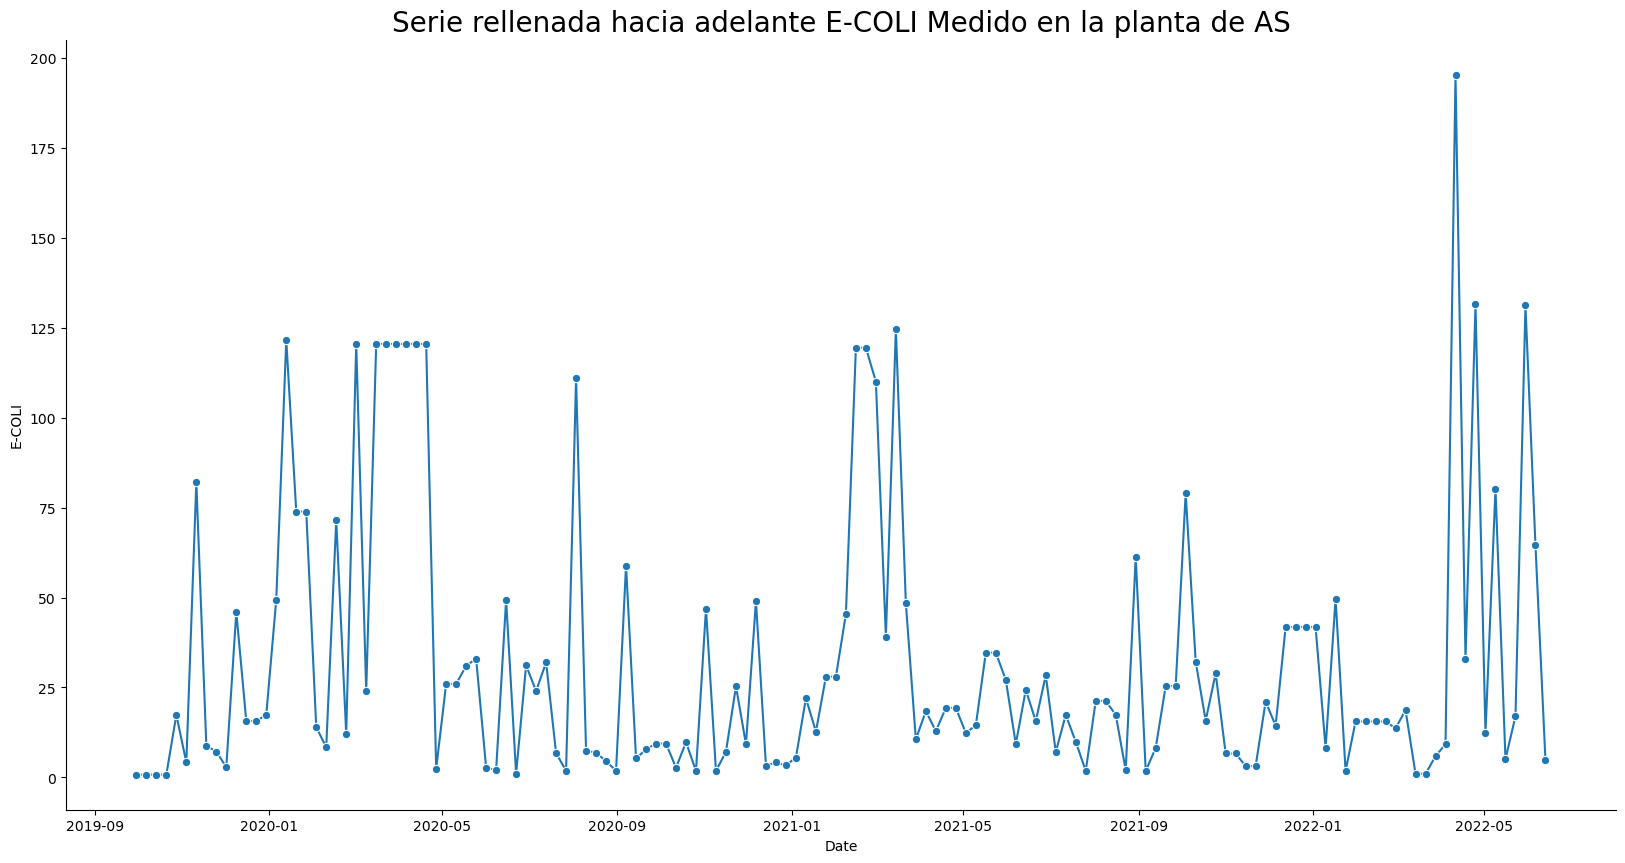

In [70]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
sn.lineplot(data = ecoli_padded['E-COLI'], marker = 'o')
plt.title('Serie rellenada hacia adelante E-COLI Medido en la planta de AS', fontsize = 20)
sn.despine();

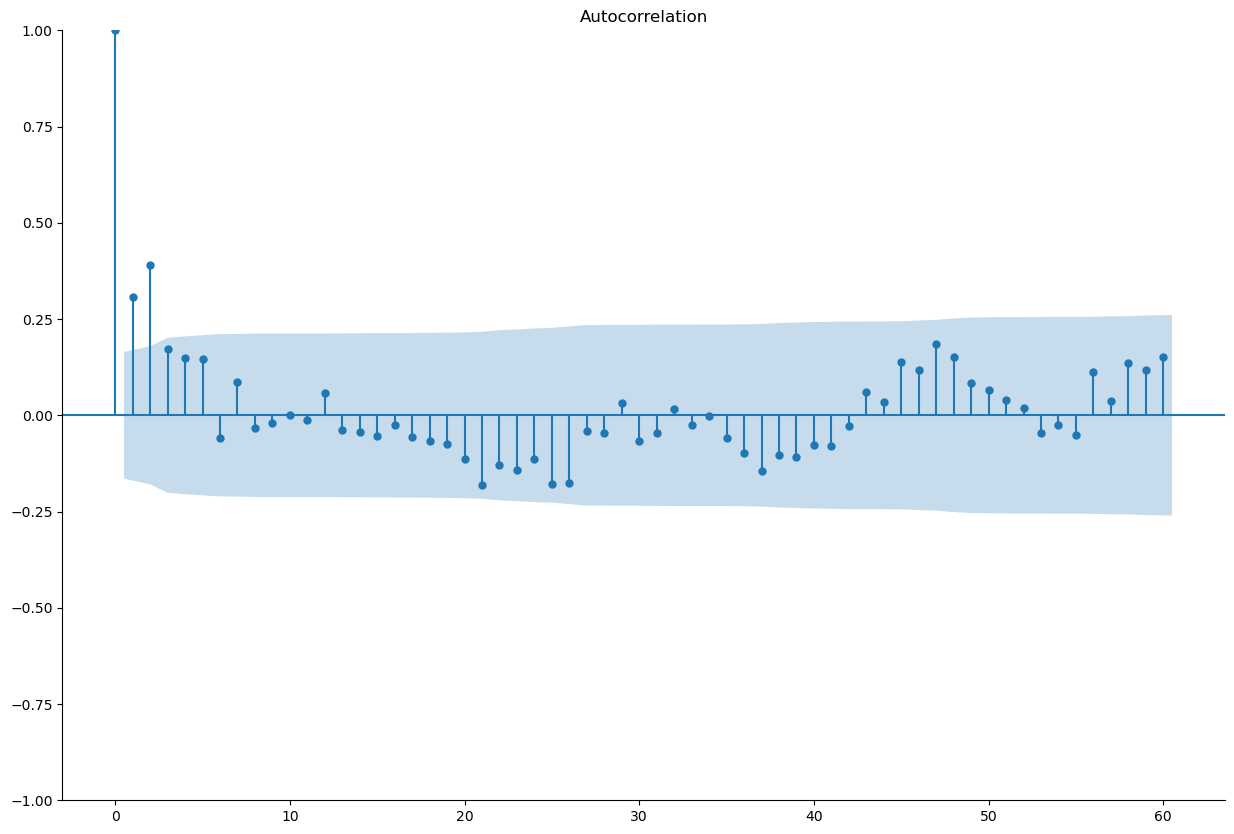

In [71]:
#plt.subplots(figsize = (30,7))
acf_ecoli_padded, acf_ecoli_padded_ic = acf(ecoli_padded['E-COLI'], alpha = .05)
plot_acf(ecoli_padded['E-COLI'], lags = 60)
sn.despine();

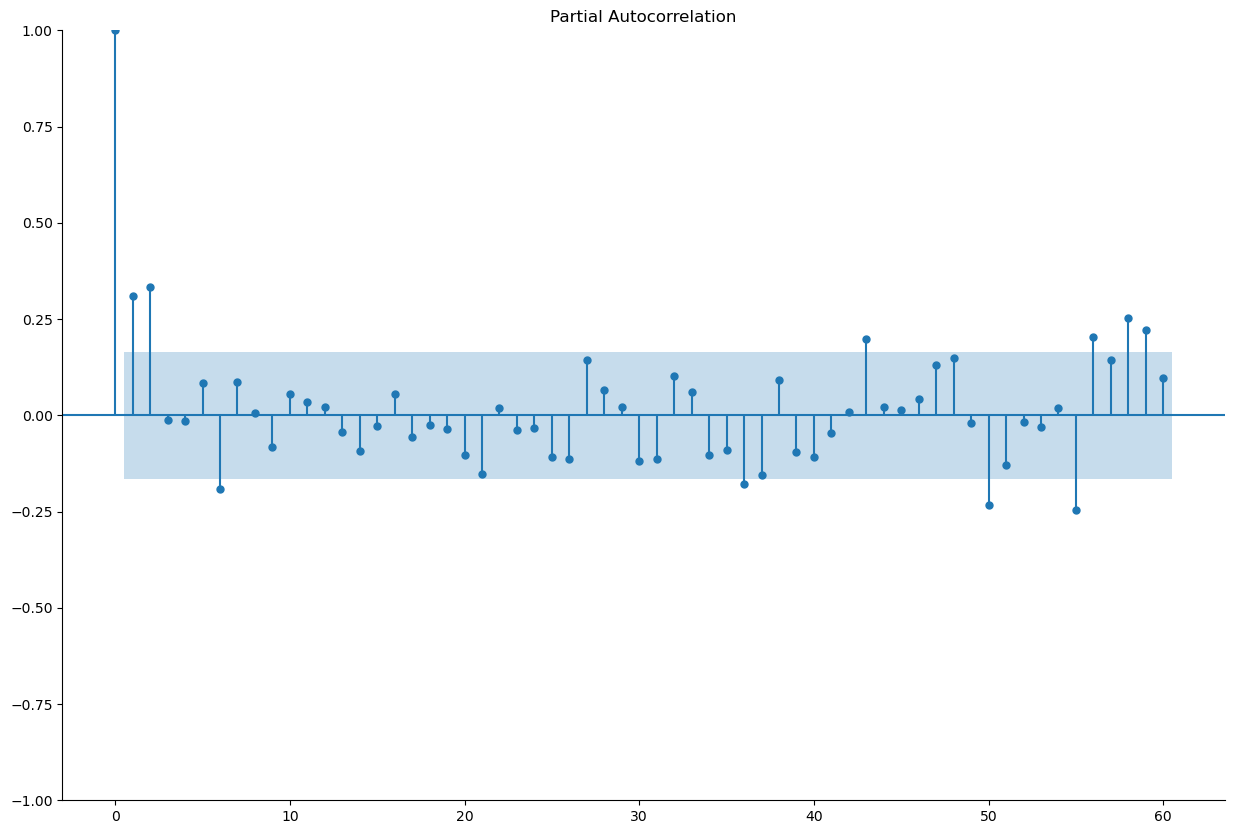

In [72]:
plot_pacf(ecoli_padded['E-COLI'], lags = 60)
sn.despine()

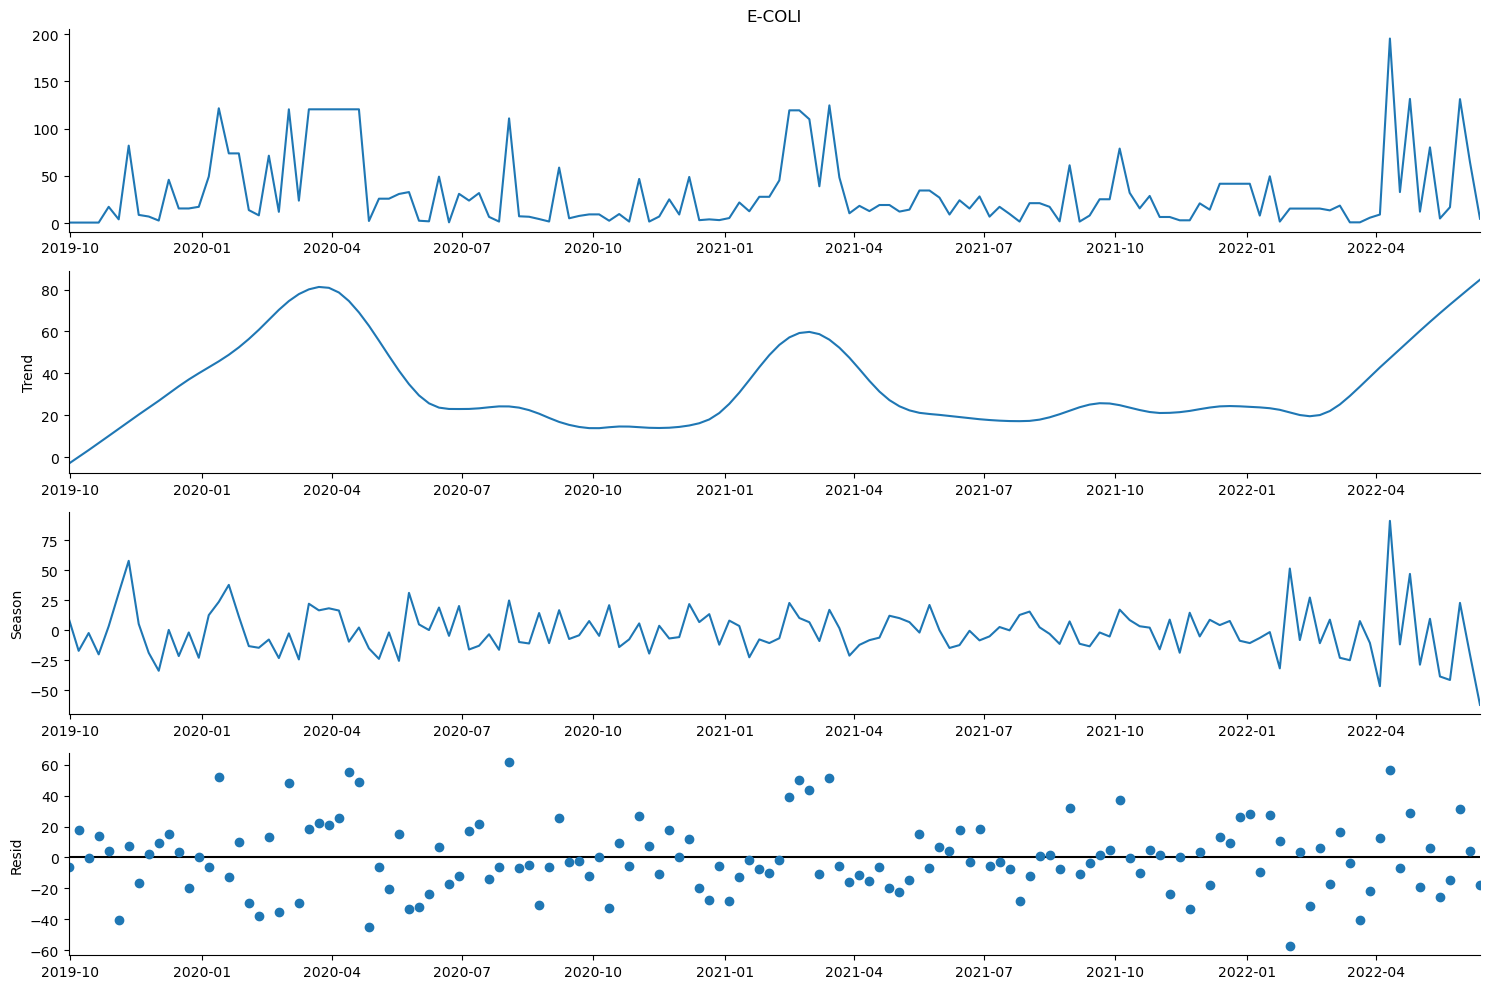

In [73]:
res = STL(ecoli_padded['E-COLI'],period = 10, seasonal = 7).fit()
res.plot()
sn.despine();

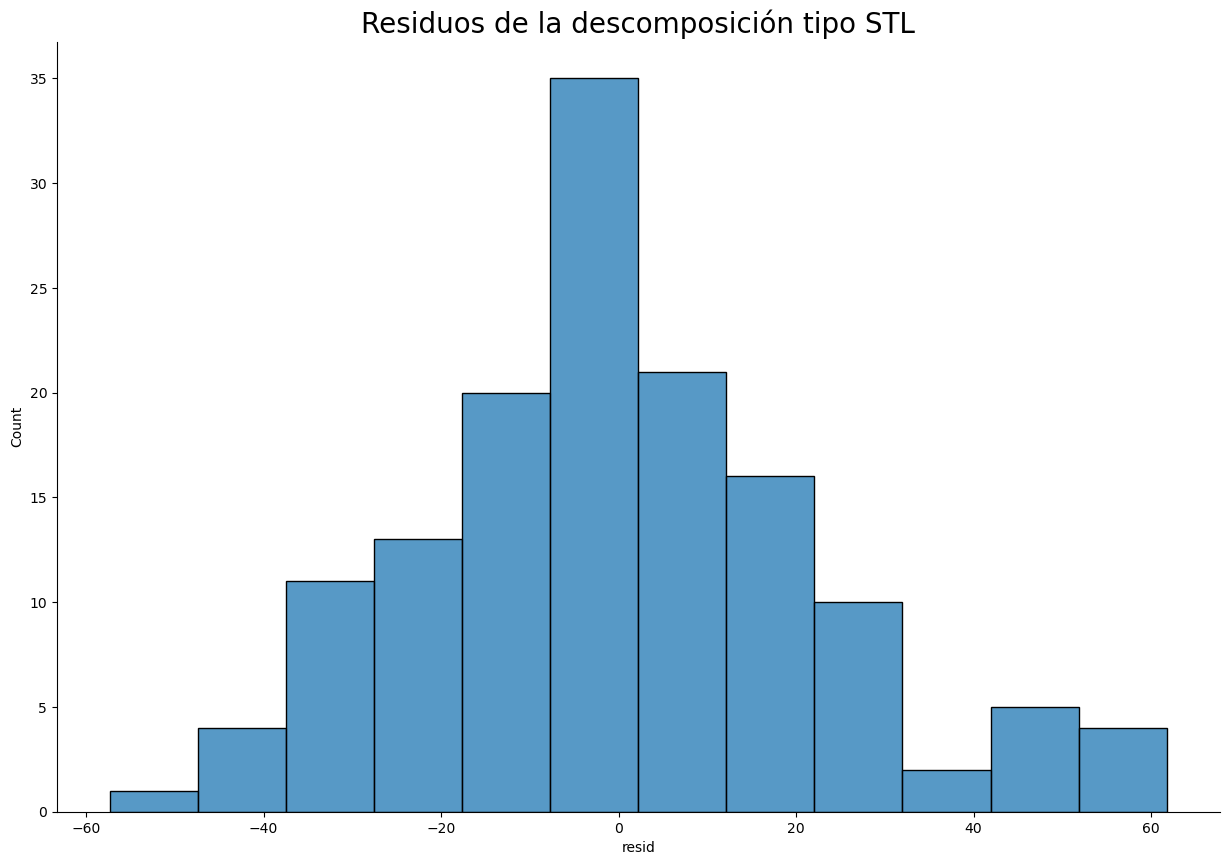

In [74]:
sn.histplot(res.resid)
plt.title('Residuos de la descomposición tipo STL', size = 20)
sn.despine()

Puesto que no se logró una descomposición satisfactoria se modelará basandose solamente en los lags observados en las funciones de autocorrelación/autocorrelación parcial

In [75]:
ecoli_stationarityTest = adfuller(ecoli_padded['E-COLI'], autolag = 'AIC')
print(f'Estadístico de contraste ADF: {ecoli_stationarityTest[0]}')
print(f'P-value Adfuller: {ecoli_stationarityTest[1]}')
for key, value in ecoli_stationarityTest[4].items():
    print('\t%s: %.3f' % (key, value))

Estadístico de contraste ADF: -4.939401633631003
P-value Adfuller: 2.9211615099087162e-05
	1%: -3.478
	5%: -2.882
	10%: -2.578


Serie es estacionaria con alta confianza (>99%)

In [76]:
ecoli_padded.describe()

E-COLI
count  142.000000
mean    32.378143
std     38.607640
min      0.750000
25%      6.947500
50%     17.200000
75%     41.800000
max    195.333333

### Solo Autorregresivo

In [77]:
ar_order = [1]
ma_order = [2]

diff_order = 1

In [79]:
arima_ecoli = ARIMA(ecoli_padded['E-COLI'],order = (ar_order, diff_order, ma_order))
arima_ecoli_results = arima_ecoli.fit()

In [80]:
arima_ecoli_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 E-COLI   No. Observations:                  142
Model:               ARIMA(1, 1, [2])   Log Likelihood                -707.681
Date:                Mon, 26 Sep 2022   AIC                           1421.362
Time:                        04:06:21   BIC                           1430.208
Sample:                    09-30-2019   HQIC                          1424.957
                         - 06-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7086      0.069    -10.254      0.000      -0.844      -0.573
ma.L2         -0.3692      0.096     -3.845      0.000      -0.557      -0.181
sigma2      1334.1190     85.804     15.548      0.000    1165.946    1502.292
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               193.19
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             1.25
Prob(H) (two-sided):                  0.98   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

p-valores de los coeficientes asociados a 1 y 2 semanas de lag para el modelo AR junto con 1 de lag para el modelo MA son estadísticamente significativos a un 95% de confianza por lo que se mantendran

#### Forecasting

In [177]:
%%time
test_size = 12
series = ecoli_padded['E-COLI']
rolling_predictions = []
for i in range(test_size):
    train = series[:-(test_size-i)]
#    res = STL(train, period = 15).fit()
#    train_deseasonaled = train - res.seasonal
    model = ARIMA(train,order = (ar_order, diff_order, ma_order))
    model_fit = model.fit(method = 'statespace')
    pred = model_fit.forecast(steps=1)# + res.seasonal[-1:].values
    rolling_predictions.append(pred.values[0])#.append(np.sqrt(pred.variance.values[-1,:][0]))

CPU times: user 2.76 s, sys: 82.7 ms, total: 2.84 s
Wall time: 518 ms


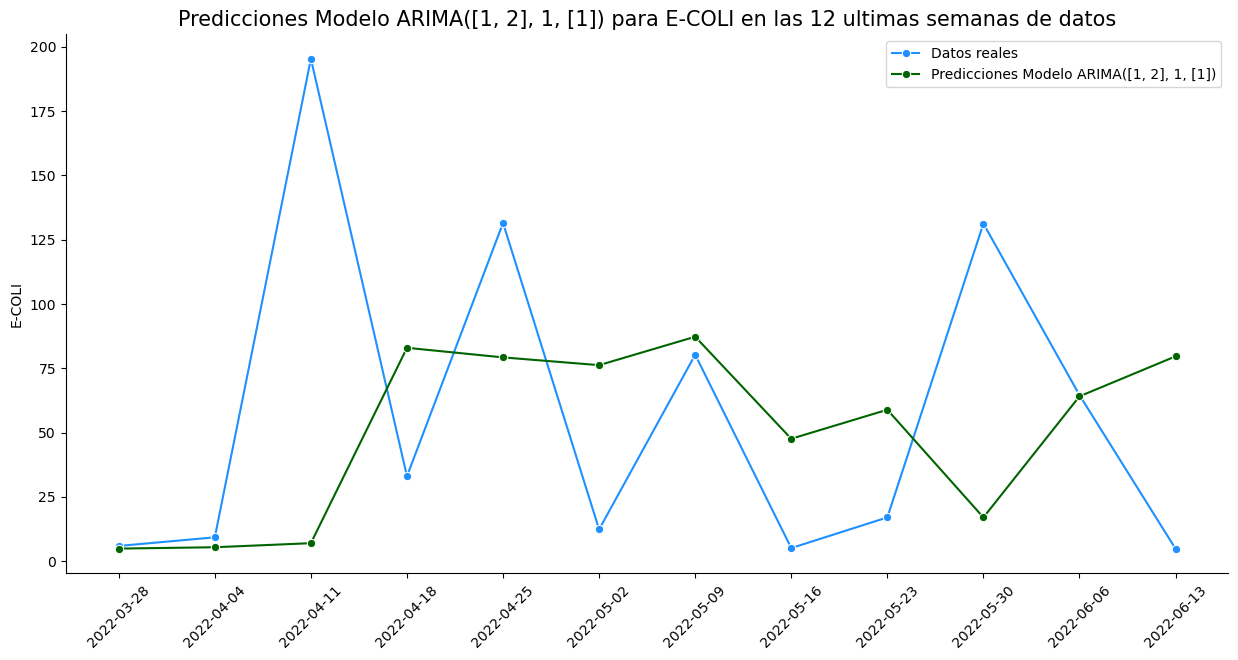

In [178]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo ARIMA([1, 2], 1, [1]) para E-COLI en las {test_size} ultimas semanas de datos', size = 15)
sn.lineplot(data = ecoli_padded['E-COLI'].iloc[-test_size:].reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = rolling_predictions, color = 'darkgreen', label = 'Predicciones Modelo ARIMA([1, 2], 1, [1])', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(ecoli_padded.index[-test_size:].date), rotation = 45)
sn.despine();

In [179]:
print(f'MAE:{mean_absolute_error(ecoli_padded["E-COLI"].iloc[-test_size:], rolling_predictions)}')
print(f'MSE: {mean_squared_error(ecoli_padded["E-COLI"].iloc[-test_size:], rolling_predictions)}')

MAE:53.35532439611705
MSE: 5588.645853836129


### AdaBoost

In [1090]:
from sklearn.preprocessing import StandardScaler

In [1093]:
lagged_features_ecoli = buildLaggedFeatures(ecoli_padded['E-COLI'], lag = 5)
x = lagged_features_ecoli.drop(columns = ['lag_0'])
y = lagged_features_ecoli['lag_0']


std_autoreg = StandardScaler()

x_train = x.iloc[:-test_size, :]
x_test = x.iloc[-test_size:, :]

x_train = std_autoreg.fit_transform(x_train)
x_test = std_autoreg.transform(x_test)

y_train = y.iloc[:-test_size]
y_test = y.iloc[-test_size:]

In [1094]:
ada = AdaBoostRegressor().fit(x_train, y_train)

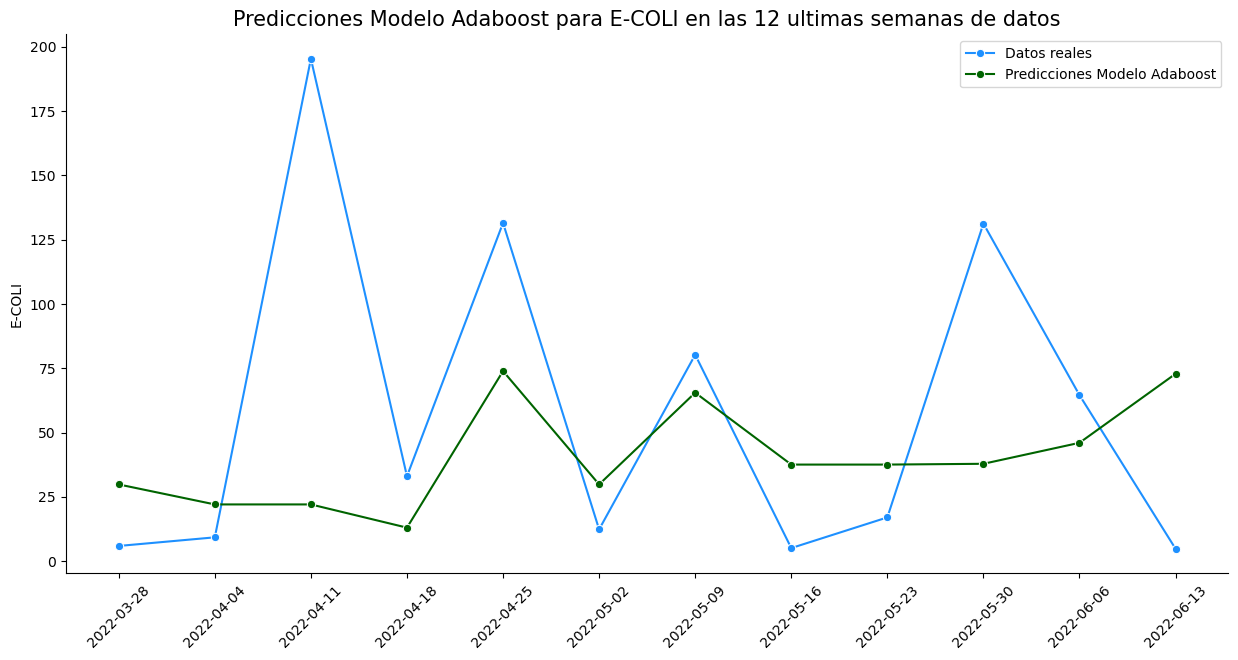

In [1095]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo Adaboost para E-COLI en las {test_size} ultimas semanas de datos', size = 15)
sn.lineplot(data = ecoli_padded['E-COLI'].iloc[-test_size:].reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = ada.predict(x_test), color = 'darkgreen', label = 'Predicciones Modelo Adaboost', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(ecoli_padded.index[-test_size:].date), rotation = 45)
sn.despine();

In [1096]:
print(f'MAE:{mean_absolute_error(ecoli_padded["E-COLI"].iloc[-test_size:], ada.predict(x_test))}')
print(f'MSE: {mean_squared_error(ecoli_padded["E-COLI"].iloc[-test_size:], ada.predict(x_test))}')

MAE:46.067607232895966
MSE: 4181.517741063442


### Regresión Lineal

In [1097]:
linreg = LinearRegression().fit(x_train, y_train)

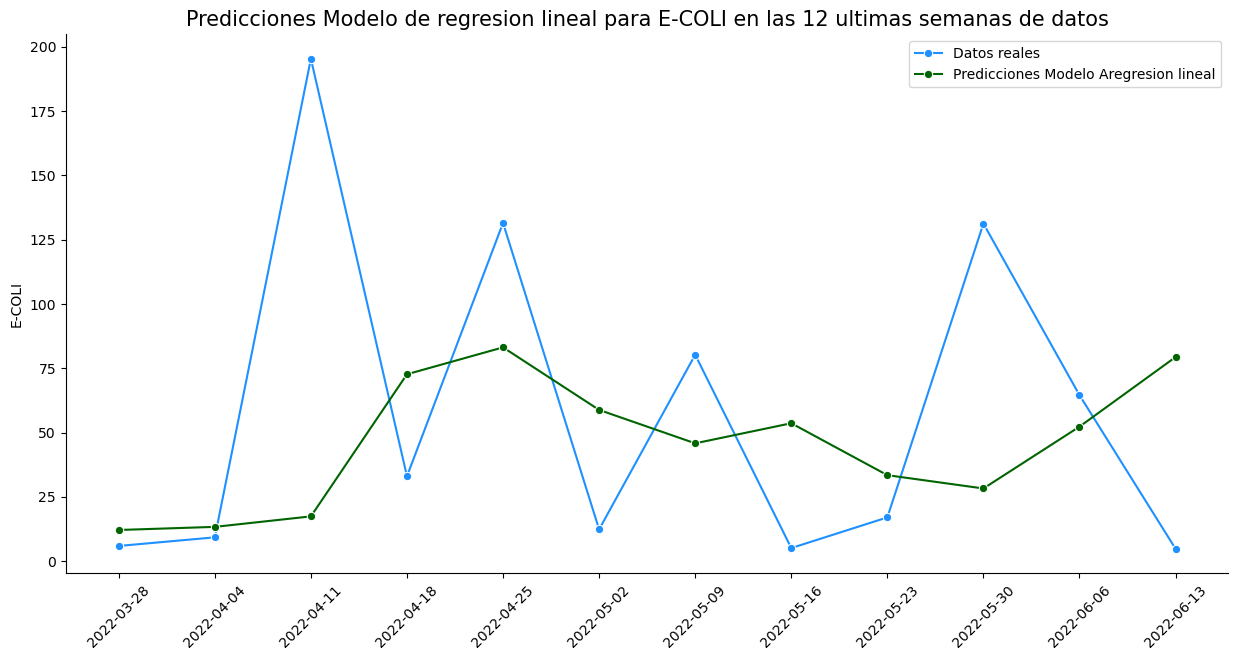

In [1098]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo de regresion lineal para E-COLI en las {test_size} ultimas semanas de datos', size = 15)
sn.lineplot(data = ecoli_padded['E-COLI'].iloc[-test_size:].reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = linreg.predict(x_test), color = 'darkgreen', label = 'Predicciones Modelo Aregresion lineal', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(ecoli_padded.index[-test_size:].date), rotation = 45)
sn.despine();

In [1099]:
print(f'MAE:{mean_absolute_error(ecoli_padded["E-COLI"].iloc[-test_size:], linreg.predict(x_test))}')
print(f'MSE: {mean_squared_error(ecoli_padded["E-COLI"].iloc[-test_size:], linreg.predict(x_test))}')

MAE:50.994951129879105
MSE: 4826.540831786755


### SVR - Linear Kernel

In [1100]:
svr_linear = SVR(kernel = 'linear').fit(x_train, y_train)

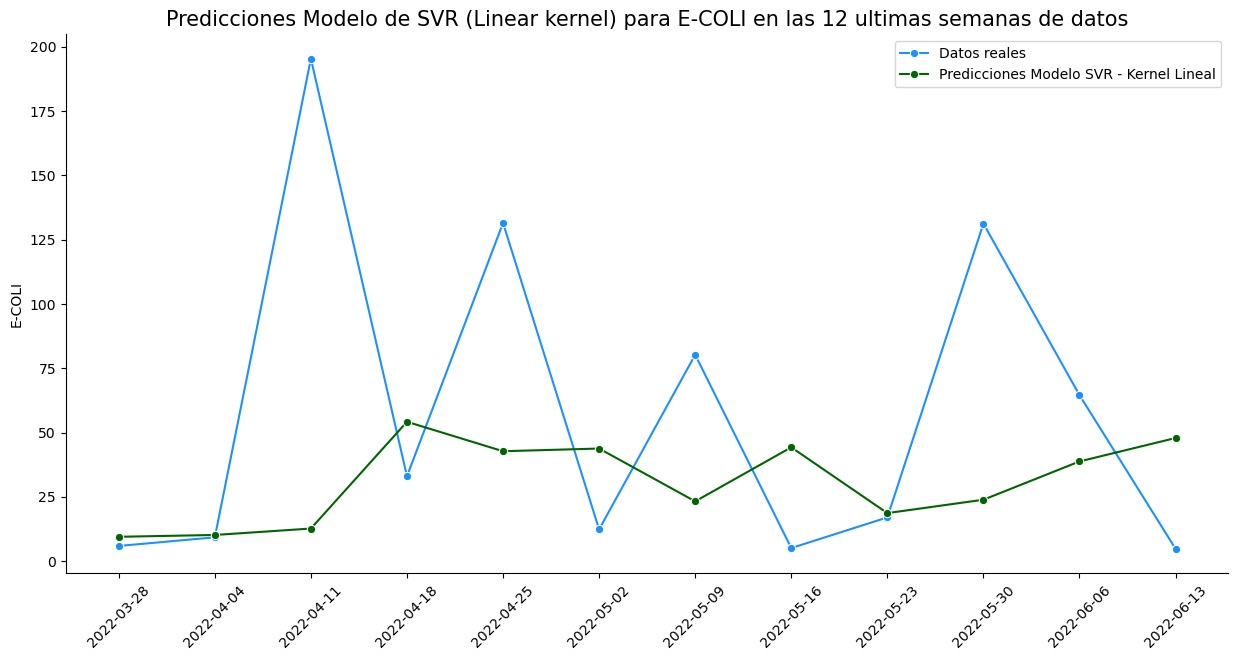

In [1101]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo de SVR (Linear kernel) para E-COLI en las {test_size} ultimas semanas de datos', size = 15)
sn.lineplot(data = ecoli_padded['E-COLI'].iloc[-test_size:].reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = svr_linear.predict(x_test), color = 'darkgreen', label = 'Predicciones Modelo SVR - Kernel Lineal', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(ecoli_padded.index[-test_size:].date), rotation = 45)
sn.despine();

In [1102]:
print(f'MAE:{mean_absolute_error(ecoli_padded["E-COLI"].iloc[-test_size:], svr_linear.predict(x_test))}')
print(f'MSE: {mean_squared_error(ecoli_padded["E-COLI"].iloc[-test_size:], svr_linear.predict(x_test))}')

MAE:50.21930931790359
MSE: 5127.819346977427


### SVR - RBG Kernel

In [1103]:
svr_rbf = SVR(kernel = 'rbf').fit(x_train, y_train)

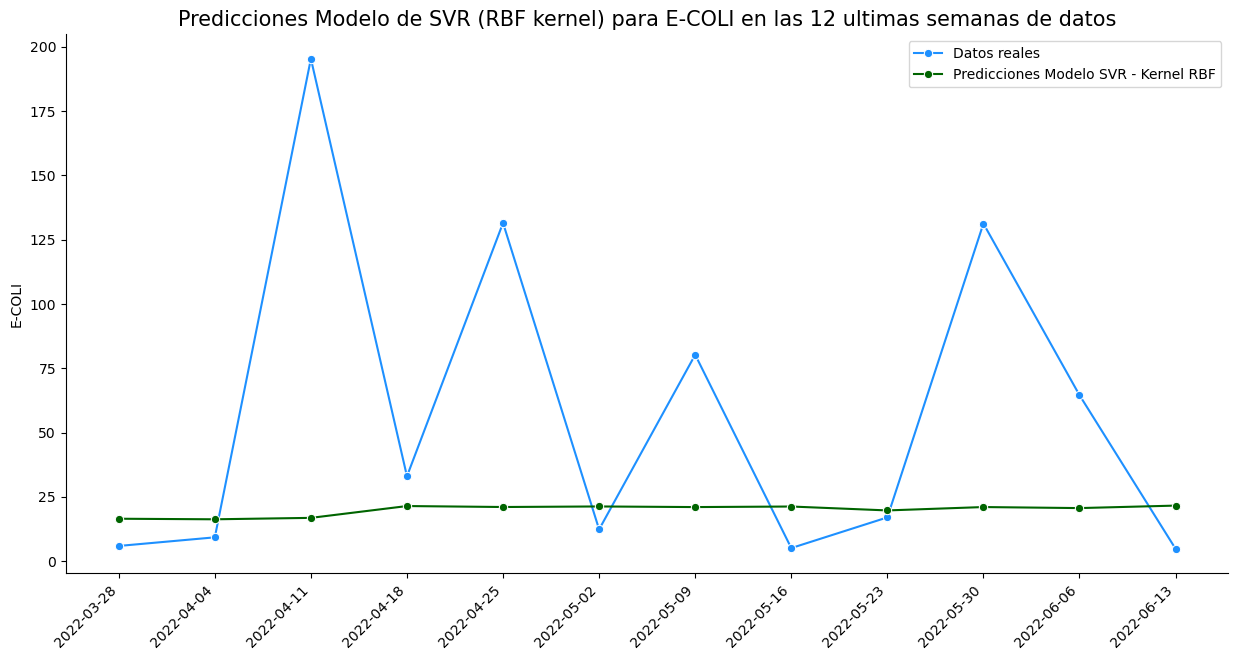

In [1104]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo de SVR (RBF kernel) para E-COLI en las {test_size} ultimas semanas de datos', size = 15)
sn.lineplot(data = ecoli_padded['E-COLI'].iloc[-test_size:].reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = svr_rbf.predict(x_test), color = 'darkgreen', label = 'Predicciones Modelo SVR - Kernel RBF', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(ecoli_padded.index[-test_size:].date), rotation = 45, ha = 'right')
sn.despine();

In [1106]:
print(f'MAE:{mean_absolute_error(ecoli_padded["E-COLI"].iloc[-test_size:], svr_rbf.predict(x_test))}')
print(f'MSE: {mean_squared_error(ecoli_padded["E-COLI"].iloc[-test_size:], svr_rbf.predict(x_test))}')

MAE:48.00939433312339
MSE: 5214.985871020496


### XGBoost

In [1107]:
import xgboost as xgb

In [1108]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10).fit(x_train,y_train)

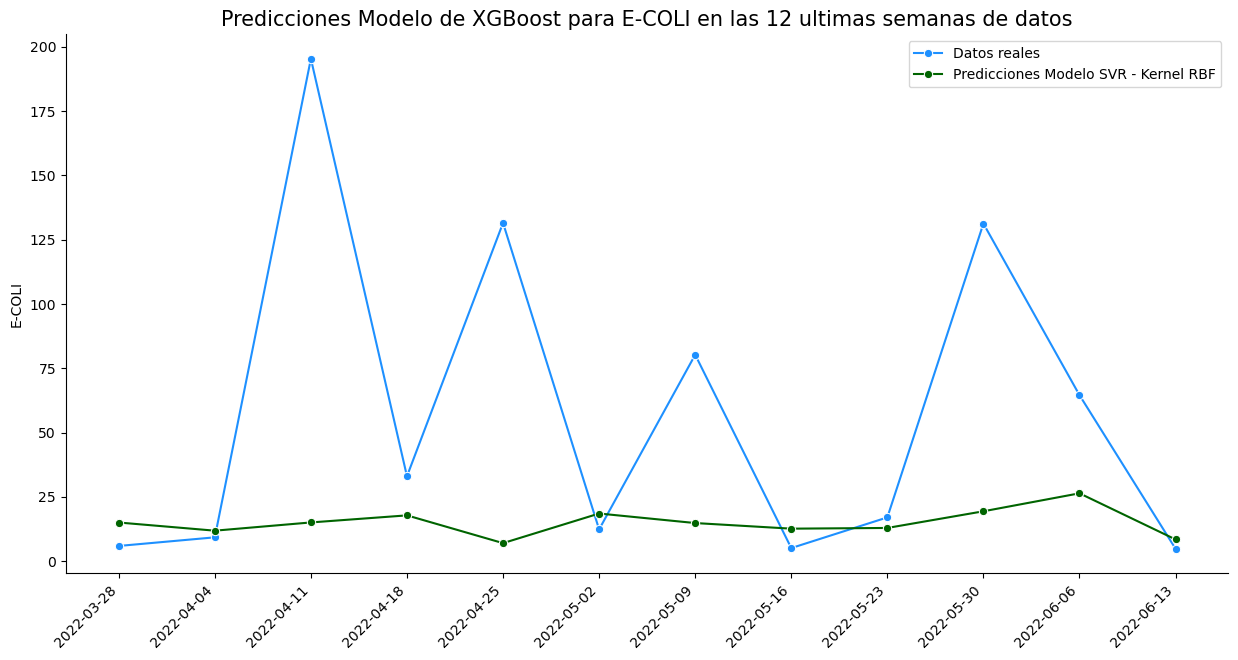

In [1109]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo de XGBoost para E-COLI en las {test_size} ultimas semanas de datos', size = 15)
sn.lineplot(data = ecoli_padded['E-COLI'].iloc[-test_size:].reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = xg_reg.predict(x_test), color = 'darkgreen', label = 'Predicciones Modelo SVR - Kernel RBF', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(ecoli_padded.index[-test_size:].date), rotation = 45, ha = 'right')
sn.despine();

In [1110]:
print(f'MAE:{mean_absolute_error(ecoli_padded["E-COLI"].iloc[-test_size:], xg_reg.predict(x_test))}')
print(f'MSE: {mean_squared_error(ecoli_padded["E-COLI"].iloc[-test_size:], xg_reg.predict(x_test))}')

MAE:47.387251621200924
MSE: 5558.993906184714


------

# Incorporación de variables exógenas

In [575]:
precip_file_paths = glob('precip_data/diarias/CR2/*.xlsx')
temp_file_paths = glob('temperaturasMedias/diarias/CR2/*.xlsx')

In [1209]:

preproc_data_noHistory(pr18, drop_NaN_classes = False)

Fe  COLOR VERD          CT        PH      E-COLI  \
fecha_muestra                                                           
2019-10-02     0.077000   15.000000         NaN       NaN         NaN   
2019-10-07     0.016000   10.000000    5.533333  6.767500    0.750000   
2019-10-08          NaN         NaN         NaN  6.290000         NaN   
2019-10-09          NaN         NaN         NaN  5.610000         NaN   
2019-10-14          NaN         NaN         NaN  6.546667         NaN   
...                 ...         ...         ...       ...         ...   
2022-06-06     0.349000   23.333333  167.666667  6.536667  167.666667   
2022-06-07     0.184000   10.000000   14.000000  7.500000   14.000000   
2022-06-13     0.207333   14.000000  126.160000  6.610000   84.760000   
2022-06-20     0.063500   10.000000    4.800000       NaN    4.800000   
2022-06-22     0.155000   15.000000  350.000000  7.450000  240.000000   

               TURBIEDAD  
fecha_muestra             
2019-10-02           NaN  
2019-10-07         0.850  
2019-10-08           NaN  
2019-10-09           NaN  
2019-10-14           NaN  
...                  ...  
2022-06-06         1.700  
2022-06-07         0.650  
2022-06-13         1.330  
2022-06-20         1.525  
2022-06-22         2.800  

[263 rows x 6 columns]

In [1231]:
def full_preproc_exgenas_noLocalidad(pr18, df_precipitaciones, df_temperaturas, target_col, test_size = 12, lag = 3,
                                     attr_list = ['Fe', 'TURBIEDAD', 'CT', 'E-COLI', 'COLOR VERD', 'precipitacion', 'temperatura']):
    
    """
    DOCSTRING:
        ...
        
        Params:
            - pr18_file_paths (list of str):
            - precip_file_paths (list of str):
            - temp_file_paths (list of str):
            - target_col (str):
            - test_size (int):
            - lag (int): 
            - attr_list (list of str): 
        
        Return (dict):
            - 
            
    """
    def getDataFrame_from_CR2Source(file_path, variable_name):
        nombre_localidad = localidad_re.findall(file_path)[0]
        precip_data = pd.read_excel(file_path)
        precip_data['fecha_muestra'] = pd.to_datetime(list(map(lambda row: f"{int(row[1]['agno'])}/{int(row[1]['mes'])}/{int(row[1]['dia'])}",
                                                               precip_data.iterrows())))
        
        # insertar una columna constante con el codigo de la localidad para despues hacer el join
        precip_data['codigoLocalidad'] = codigoLocalidad_dict[nombre_localidad] 
        precip_data.rename({'valor': variable_name}, axis = 1, inplace = True)
        
        return precip_data[['fecha_muestra', 'codigoLocalidad', variable_name]]

    def preproc_data_noHistory(data, target = 'valor', date_col = 'fecha_muestra', attr_col = 'codigo_parametro',
                        user_classes = ['Fe', 'COLOR VERD', 'CT', 'PH', 'E-COLI', 'TURBIEDAD'], 
                        drop_NaN_classes = True, date_freq = 'D'):
        df = copy(data) 
        df.dropna(subset = target, inplace = True)
        
        # columna entregada en date_col debe seguir formato yyyy-mm-dd
        df.fecha_muestra = pd.to_datetime(df[date_col], format = '%Y-%m-%d')
        
        grouped = df.groupby([
            attr_col, pd.Grouper(key=date_col, freq=date_freq)])[target].mean().reset_index().sort_values(by = date_col)
    
        grouped_pivoted = pd.pivot_table(data = grouped, index = date_col, columns = attr_col, values = target)[user_classes]
        grouped_pivoted.columns.name =  None
    
        if drop_NaN_classes: # Para obtener una matriz de atributos siempre densa
            grouped_pivoted.dropna(inplace = True)
        
        return grouped_pivoted
    
    def buildLaggedFeatures(s,lag=2,dropna=True):
        '''
        Builds a new DataFrame to facilitate regressing over all possible lagged features
        '''
        if type(s) is pd.DataFrame:
            new_dict={}
            for col_name in s:
                new_dict[col_name]=s[col_name]
                # create lagged Series
                for l in range(1,lag+1):
                    new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
            res=pd.DataFrame(new_dict,index=s.index)
        
        elif type(s) is pd.Series:
            the_range=range(lag+1)
            res=pd.concat([s.shift(i) for i in the_range],axis=1)
            res.columns=['lag_%d' %i for i in the_range]
        else:
            print('Only works for DataFrame or Series')
            return None
        if dropna:
            return res.dropna()
        else:
            return res 
    
    
    ############## Datos Precipitaciones y Temperaturas (CR2) ##############
    
    # Ingesta archivos de precipitaciones y temperaturas, se espera que tengan formato de nombre: 
    # <NombreLocalidad>_<precipitaciones|temperaturaMedia>_<NombreLugarEspecifico>.xlsx
    
    #df_precipitaciones = pd.DataFrame(pd.concat([getDataFrame_from_CR2Source(file_path, 'precipitacion') for file_path in precip_file_paths], axis = 0))
    #df_temperaturas = pd.DataFrame(pd.concat([getDataFrame_from_CR2Source(file_path, 'temperatura') for file_path in temp_file_paths], axis = 0))
    

#    df_temperaturas.rename({'fecha_muestra': 'Date'}, axis = 1, inplace = True)
#    df_precipitaciones.rename({'fecha_muestra': 'Date'}, axis = 1, inplace = True)
    df_temperaturas['fecha_muestra'] = pd.to_datetime(df_temperaturas['fecha_muestra']) - pd.to_timedelta(7, unit='d')
    df_precipitaciones['fecha_muestra'] = pd.to_datetime(df_precipitaciones['fecha_muestra']) - pd.to_timedelta(7, unit='d')
    
    # Agrupacion semanal de precipitaciones y temperaturas
    weekly_precipitaciones = df_precipitaciones.groupby([
        'codigoLocalidad', pd.Grouper(key='fecha_muestra', freq='W-MON')]).mean().reset_index()
#    weekly_precipitaciones.rename({'Date': 'fecha_muestra'}, axis = 1, inplace = True)
    weekly_precipitaciones = weekly_precipitaciones.groupby(['codigoLocalidad', 'fecha_muestra']).mean()
    
    weekly_temperaturas = df_temperaturas.groupby([
            'codigoLocalidad', pd.Grouper(key='fecha_muestra', freq='W-MON')]).mean().reset_index()
#    weekly_temperaturas.rename({'Date': 'fecha_muestra'}, axis = 1, inplace = True)
    weekly_temperaturas = weekly_temperaturas.groupby(['codigoLocalidad', 'fecha_muestra']).mean()
    
    # ForwardFilling
    weekly_precipitaciones_noLocalidad = weekly_precipitaciones.reset_index()\
                                    .drop(columns = ['codigoLocalidad']).groupby(by = 'fecha_muestra').mean().resample('W-MON').ffill()
    weekly_temperaturas_noLocalidad = weekly_temperaturas.reset_index()\
                                    .drop(columns = ['codigoLocalidad']).groupby(by = 'fecha_muestra').mean().resample('W-MON').ffill()
    
    
    ############## PR18 ##############
    # Ingesta PR18
#    pr18 = pd.concat([pd.read_csv(file, index_col=0) for file in pr18_file_paths], axis = 0) # Estas dos lineas son reemplazables por otra forma de ingesta de esta info
    
    # Preproc general para pr18
    pr18_processed = preproc_data_noHistory(pr18, drop_NaN_classes=False, date_freq = 'W-MON')
    
    # Join de datos de temperatura y precip con conjunto de datos de RP18 + forward filling para las fechas que no calcen
    data_exogena_padded = pr18_processed.join(weekly_precipitaciones_noLocalidad).join(weekly_temperaturas_noLocalidad)[attr_list]#\
                                                                                                        #.resample('W-MON').fillna(method = 'ffill')
    for col_name, col in data_exogena_padded.iteritems():
        data_exogena_padded[col_name] = data_exogena_padded[col_name].fillna(method = 'ffill')
    
    
    # Construccion de las matrices de entrenamiento y pruebas
    
    X = buildLaggedFeatures(data_exogena_padded, lag=lag).drop(columns = [target_col])
    Y = data_exogena_padded[target_col].iloc[lag:]
    
    std_exogen = StandardScaler()
    
    x_train = X.iloc[:-test_size, :]
    x_test = X.iloc[-test_size:, :]
    
    x_train = std_exogen_ecoli.fit_transform(x_train)
    x_test = std_exogen_ecoli.transform(x_test)
    
    y_train = Y.iloc[:-test_size]
    y_test = Y.iloc[-test_size:]
    
    return {'data': (x_train, x_test, y_train, y_test), 'std_scaler': std_exogen}
    

In [1232]:
def getDataFrame_from_CR2Source(file_path, variable_name):
    print(file_path)
    nombre_localidad = localidad_re.findall(file_path)[0]
    precip_data = pd.read_excel(file_path)
    precip_data['fecha_muestra'] = pd.to_datetime(list(map(lambda row: f"{int(row[1]['agno'])}/{int(row[1]['mes'])}/{int(row[1]['dia'])}", precip_data.iterrows())))
    precip_data['codigoLocalidad'] = codigoLocalidad_dict[nombre_localidad] # insertar una columna constante con el codigo de la localidad para despues hacer el join
    precip_data.rename({'valor': variable_name}, axis = 1, inplace = True)
    return precip_data[['fecha_muestra', 'codigoLocalidad', variable_name]]

In [1233]:
df_precipitaciones = pd.DataFrame(pd.concat([getDataFrame_from_CR2Source(file_path, 'precipitacion') for file_path in precip_file_paths], axis = 0))
df_temperaturas = pd.DataFrame(pd.concat([getDataFrame_from_CR2Source(file_path, 'temperatura') for file_path in temp_file_paths], axis = 0))

precip_data/diarias/CR2/PuertoAysen_precipitaciones_PuertoAysenAd.xlsx
precip_data/diarias/CR2/Coyhaique_precipitaciones_EscuelaAgricula.xlsx
precip_data/diarias/CR2/Cochrane_precipitaciones_Cochrane.xlsx
precip_data/diarias/CR2/PuertoIbanez_precipitaciones_RioIbaezEnDesembocadura.xlsx
precip_data/diarias/CR2/PuertoCisnes_precipitaciones_PuertoCisnes.xlsx
precip_data/diarias/CR2/Balmaceda_precipitaciones_AeropuertoBalmaceda.xlsx
precip_data/diarias/CR2/ChileChico_precipitaciones_AerodromoChileChico.xlsx
temperaturasMedias/diarias/CR2/PuertoAysen_temperaturaMedia_PuertoAysenAd.xlsx
temperaturasMedias/diarias/CR2/Coyhaique_temperaturaMedia_AeropuertoCoyhaique.xlsx
temperaturasMedias/diarias/CR2/PuertoIbanez_temperaturaMedia_RioIbaezEnDesembocadura.xlsx
temperaturasMedias/diarias/CR2/ChileChico_temperaturaMedia_AerodromoChileChico.xlsx
temperaturasMedias/diarias/CR2/Cochrane_temperaturaMedia_Cochrane.xlsx
temperaturasMedias/diarias/CR2/Balmaceda_temperaturaMedia_AeropuertoBalmaceda.xlsx


In [1234]:
full_preproc_exgenas_noLocalidad(pr18, df_precipitaciones, df_temperaturas, target_col = 'E-COLI')

{'data': (array([[-0.54336726, -0.46216757, -0.45522213, ..., -0.18531394,
           0.19661635, -0.25141007],
         [-0.5591977 , -0.53446946, -0.45522213, ..., -0.1836429 ,
          -0.18637786,  0.20298922],
         [-0.3942973 , -0.55031646, -0.52750272, ...,  0.40889833,
          -0.18470705, -0.18030245],
         ...,
         [-0.10209381, -0.09471546,  0.58195491, ...,  0.51502705,
           0.77667989,  1.0421799 ],
         [ 0.35896769, -0.09273459, -0.08787828, ...,  0.50200322,
           0.51386336,  0.78350328],
         [ 0.68250225,  0.36880903, -0.08589799, ...,  0.06469709,
           0.50084138,  0.52048263]]),
  array([[ 0.73810667,  0.69268191,  0.37550965, -0.08280333, -0.10106109,
          -0.26630787, -0.33627012, -0.33670456, -0.14634833, -0.15289881,
          -0.08956874, -0.13943695, -0.45569353, -0.49090641, -0.36242194,
           0.52059057,  0.61987678, -0.85289625,  2.43922155, -0.94901281,
           0.81509185,  0.33132241, -0.70868809, -0.

In [863]:
df_temperaturas.rename({'fecha_muestra': 'Date'}, axis = 1, inplace = True)
df_precipitaciones.rename({'fecha_muestra': 'Date'}, axis = 1, inplace = True)

In [864]:
df_temperaturas['Date'] = pd.to_datetime(df_temperaturas['Date']) - pd.to_timedelta(7, unit='d')
df_precipitaciones['Date'] = pd.to_datetime(df_precipitaciones['Date']) - pd.to_timedelta(7, unit='d')

In [896]:
weekly_precipitaciones = df_precipitaciones.groupby([
        'codigoLocalidad', pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index()
weekly_precipitaciones.rename({'Date': 'fecha_muestra'}, axis = 1, inplace = True)
weekly_precipitaciones = weekly_precipitaciones.groupby(['codigoLocalidad', 'fecha_muestra']).mean()

weekly_temperaturas = df_temperaturas.groupby([
        'codigoLocalidad', pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index()
weekly_temperaturas.rename({'Date': 'fecha_muestra'}, axis = 1, inplace = True)
weekly_temperaturas = weekly_temperaturas.groupby(['codigoLocalidad', 'fecha_muestra']).mean()

In [906]:
weekly_precipitaciones_noLocalidad = weekly_precipitaciones.reset_index().drop(columns = ['codigoLocalidad']).groupby(by = 'fecha_muestra').mean().resample('W-MON').ffill()
weekly_temperaturas_noLocalidad = weekly_temperaturas.reset_index().drop(columns = ['codigoLocalidad']).groupby(by = 'fecha_muestra').mean().resample('W-MON').ffill()

In [961]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

LAG = 3
attr_list = ['Fe', 'TURBIEDAD', 'CT', 'E-COLI', 'COLOR VERD', 'precipitacion', 'temperatura']

ar_order = [1]
ma_order = [2]

diff_order = 1
test_size = 12

In [962]:
data_exogena_padded = joined_processed_data_weekly.join(weekly_precipitaciones_noLocalidad).join(weekly_temperaturas_noLocalidad)[attr_list].resample('W-MON').fillna(method = 'ffill')
for col_name, col in data_exogena_padded.iteritems():
    data_exogena_padded[col_name] = data_exogena_padded[col_name].fillna(method = 'ffill')

In [963]:
data_exogena_padded

Fe  TURBIEDAD           CT      E-COLI  COLOR VERD  \
Date                                                                  
2019-09-30  0.04650   0.850000     5.533333    0.750000   11.666667   
2019-10-07  0.04650   0.850000     5.533333    0.750000   11.666667   
2019-10-14  0.04650   0.850000  1600.000000    0.750000   11.666667   
2019-10-21  0.01000   0.850000  1600.000000    0.750000   11.666667   
2019-10-28  0.00200   0.950000    17.400000   17.400000   10.000000   
...             ...        ...          ...         ...         ...   
2022-05-23  0.21200   2.800000    28.000000   17.000000   20.000000   
2022-05-30  0.32625   1.725000   185.750000  131.250000   21.250000   
2022-06-06  0.20150   1.135714    94.114286   64.542857   12.857143   
2022-06-13  0.06350   1.525000     4.800000    4.800000   10.000000   
2022-06-20  0.15500   2.800000   350.000000  240.000000   15.000000   

            precipitacion  temperatura  
Date                                    
2019-09-30       0.966190     6.871429  
2019-10-07       0.922222     8.769048  
2019-10-14       1.135714    10.861111  
2019-10-21       1.989683     9.096429  
2019-10-28       2.901190     9.104127  
...                   ...          ...  
2022-05-23       0.043537     1.248571  
2022-05-30       2.217687     0.544762  
2022-06-06       2.383673     2.579286  
2022-06-13       1.041497     3.556190  
2022-06-20       1.641224    -1.709524  

[143 rows x 7 columns]

# E-COLI

In [1224]:
X_ecoli = buildLaggedFeatures(data_exogena_padded, lag=LAG).drop(columns = ['E-COLI'])
Y_ecoli = data_exogena_padded['E-COLI'].iloc[LAG:]

std_exogen_ecoli = StandardScaler()

x_train_ecoli = X_ecoli.iloc[:-test_size, :]
x_test_ecoli = X_ecoli.iloc[-test_size:, :]

x_train_ecoli = std_exogen_ecoli.fit_transform(x_train_ecoli)
x_test_ecoli = std_exogen_ecoli.transform(x_test_ecoli)

y_train_ecoli = Y_ecoli.iloc[:-test_size]
y_test_ecoli = Y_ecoli.iloc[-test_size:]

## Regresión Lineal - Regularizada con Ridge

In [1225]:
linreg_ridge = RidgeCV(cv = 5).fit(x_train_ecoli, y_train_ecoli)

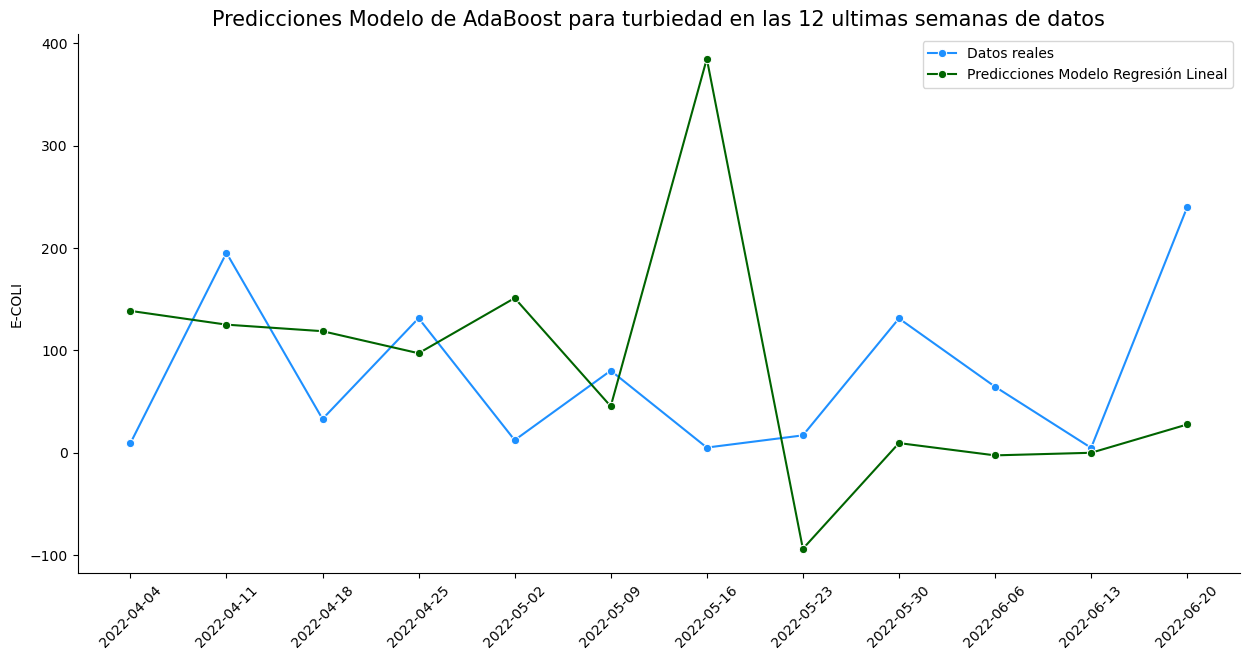

In [1226]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo de AdaBoost para turbiedad en las {test_size} ultimas semanas de datos', size = 15)
sn.lineplot(data = y_test_ecoli.reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = linreg_ridge.predict(x_test_ecoli), color = 'darkgreen', label = 'Predicciones Modelo Regresión Lineal', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(Y_ecoli.index[-test_size:].date), rotation = 45)
sn.despine();

In [1179]:
print(f'MAE:{mean_absolute_error(y_test_ecoli, linreg_ridge.predict(x_test_ecoli))}')
print(f'MSE: {mean_squared_error(y_test_ecoli, linreg_ridge.predict(x_test_ecoli))}')

MAE:115.83738296973938
MSE: 22646.202242047646


## AdaBoost - Mejor desempeñó + visual

In [1180]:
ada_ecoli_exogen = AdaBoostRegressor().fit(x_train_ecoli, y_train_ecoli)

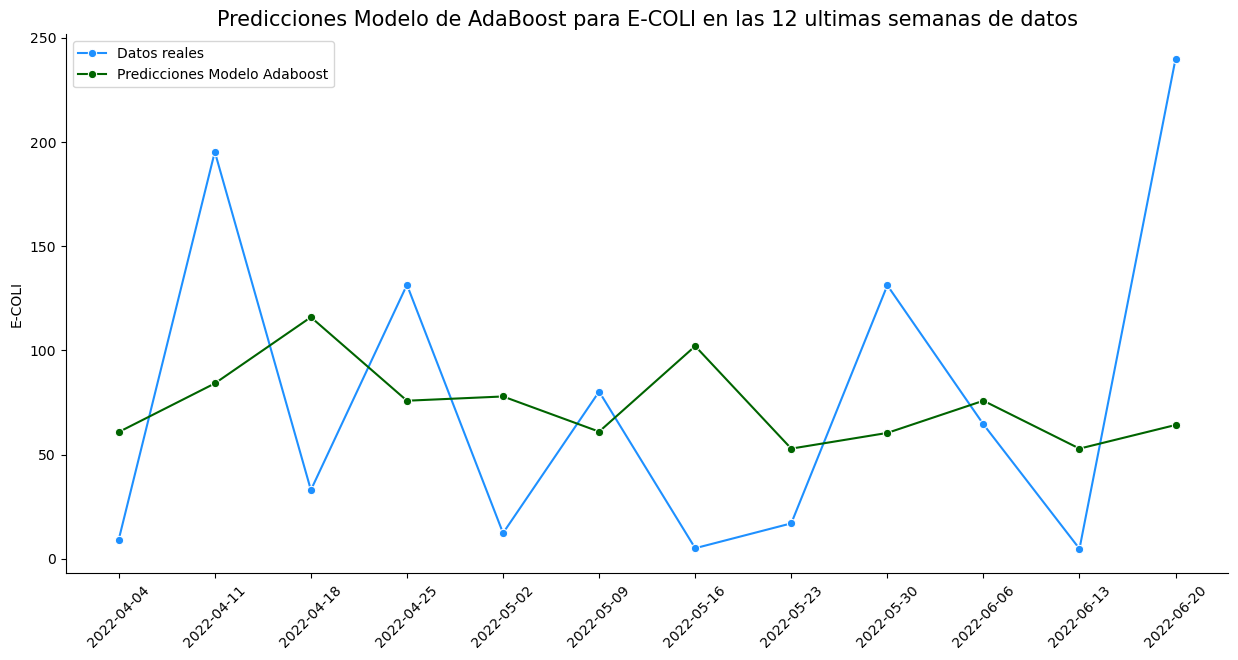

In [1181]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo de AdaBoost para E-COLI en las {test_size} ultimas semanas de datos', size = 15)
sn.lineplot(data = y_test_ecoli.reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = ada_ecoli_exogen.predict(x_test_ecoli), color = 'darkgreen', label = 'Predicciones Modelo Adaboost', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(Y_ecoli.index[-test_size:].date), rotation = 45)
sn.despine();

In [1182]:
print(f'MAE:{mean_absolute_error(y_test_ecoli, ada_ecoli_exogen.predict(x_test_ecoli))}')
print(f'MSE: {mean_squared_error(y_test_ecoli, ada_ecoli_exogen.predict(x_test_ecoli))}')

MAE:68.75344300508173
MSE: 6559.769746239585


## XGBoost

In [1183]:
xg_ecoli_exogen = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 100).fit(x_train_ecoli, y_train_ecoli)

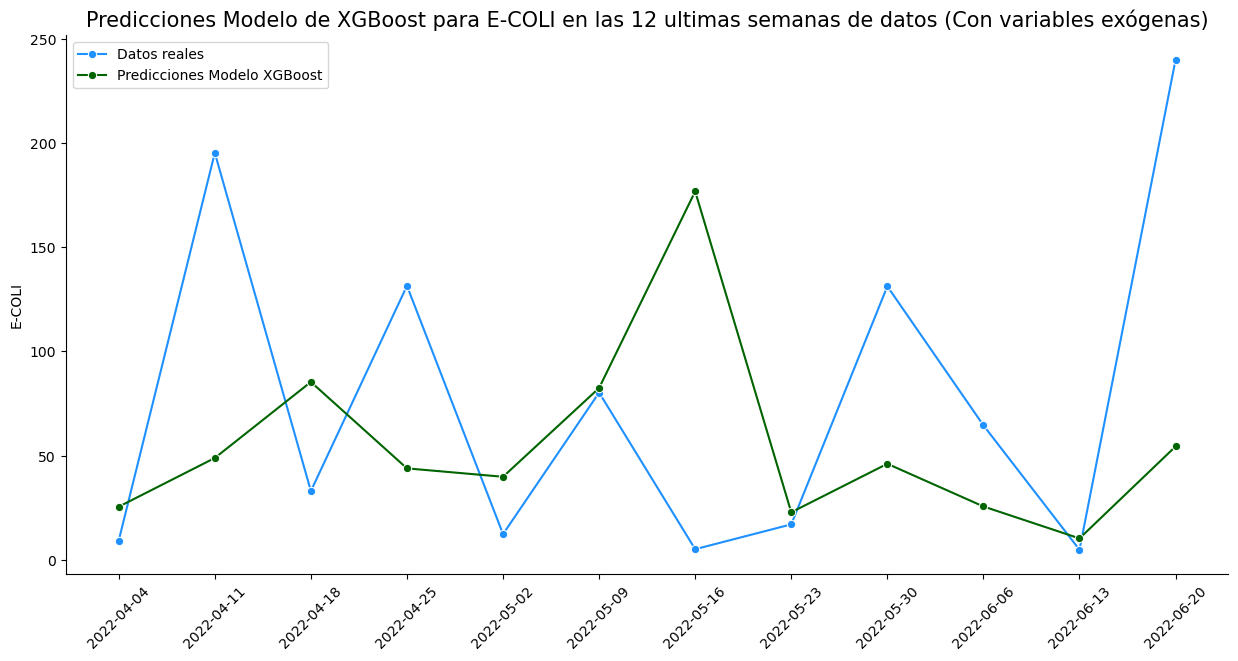

In [1184]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo de XGBoost para E-COLI en las {test_size} ultimas semanas de datos (Con variables exógenas)', size = 15)
sn.lineplot(data = y_test_ecoli.reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = xg_ecoli_exogen.predict(x_test_ecoli), color = 'darkgreen', label = 'Predicciones Modelo XGBoost', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(Y_ecoli.index[-test_size:].date), rotation = 45)
sn.despine();

In [1185]:
print(f'MAE:{mean_absolute_error(y_test_ecoli, xg_ecoli_exogen.predict(x_test_ecoli))}')
print(f'MSE: {mean_squared_error(y_test_ecoli, xg_ecoli_exogen.predict(x_test_ecoli))}')

MAE:68.76092242967515
MSE: 8806.893569249247


## SARIMAX

In [1186]:
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [1187]:
%%time
exog_series = data_exogena_padded.drop(columns = ['E-COLI'])
endog_series = data_exogena_padded['E-COLI']
rolling_predictions = []

for i in range(test_size):
    exog_train = exog_series[:-(test_size-i)]
    endog_train = endog_series[:-(test_size-i)]
    model = SARIMAX(endog = endog_train, exog = exog_train ,order = (ar_order, diff_order, ma_order))
    model_fit = model.fit(disp = False)
    pred = model_fit.forecast(exog = exog_train.iloc[-1, :])# + res.seasonal[-1:].values
    rolling_predictions.append(pred.values[0])#.append(np.sqrt(pred.variance.values[-1,:][0]))

CPU times: user 15.2 s, sys: 214 ms, total: 15.4 s
Wall time: 3.61 s


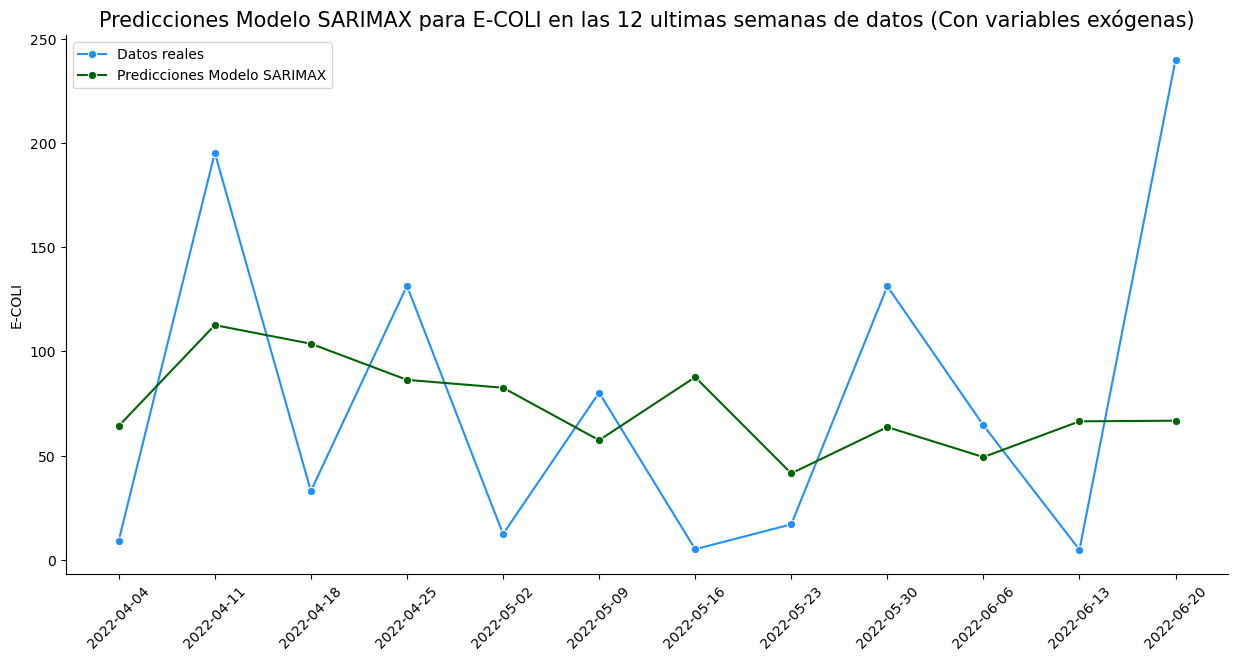

In [1188]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo SARIMAX para E-COLI en las {test_size} ultimas semanas de datos (Con variables exógenas)', size = 15)
sn.lineplot(data = y_test_ecoli.reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = rolling_predictions, color = 'darkgreen', label = 'Predicciones Modelo SARIMAX', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(Y_ecoli.index[-test_size:].date), rotation = 45)
sn.despine();

In [1189]:
print(f'MAE:{mean_absolute_error(y_test_ecoli, rolling_predictions)}')
print(f'MSE: {mean_squared_error(y_test_ecoli, rolling_predictions)}')

MAE:64.28334805390875
MSE: 5698.9030155827595


# Turbiedad

In [1190]:
X_turbiedad = buildLaggedFeatures(data_exogena_padded, lag=LAG).drop(columns = ['TURBIEDAD'])
Y_turbiedad = data_exogena_padded['TURBIEDAD'].iloc[LAG:]

std_exogen_turbiedad = StandardScaler()

x_train_turbiedad = X_turbiedad.iloc[:-test_size,:]
x_test_turbiedad = X_turbiedad.iloc[-test_size:,:]

x_train_turbiedad = std_exogen_turbiedad.fit_transform(x_train_turbiedad)
x_test_ecoli = std_exogen_turbiedad.transform(x_test_turbiedad)

y_train_turbiedad = Y_turbiedad.iloc[:-test_size]
y_test_turbiedad = Y_turbiedad.iloc[-test_size:]

## Regresión lineal - Regularizada con Ridge

In [1191]:
from sklearn.linear_model import RidgeCV

In [1192]:
linreg_ridge = RidgeCV(cv = 5).fit(x_train_turbiedad, y_train_turbiedad)

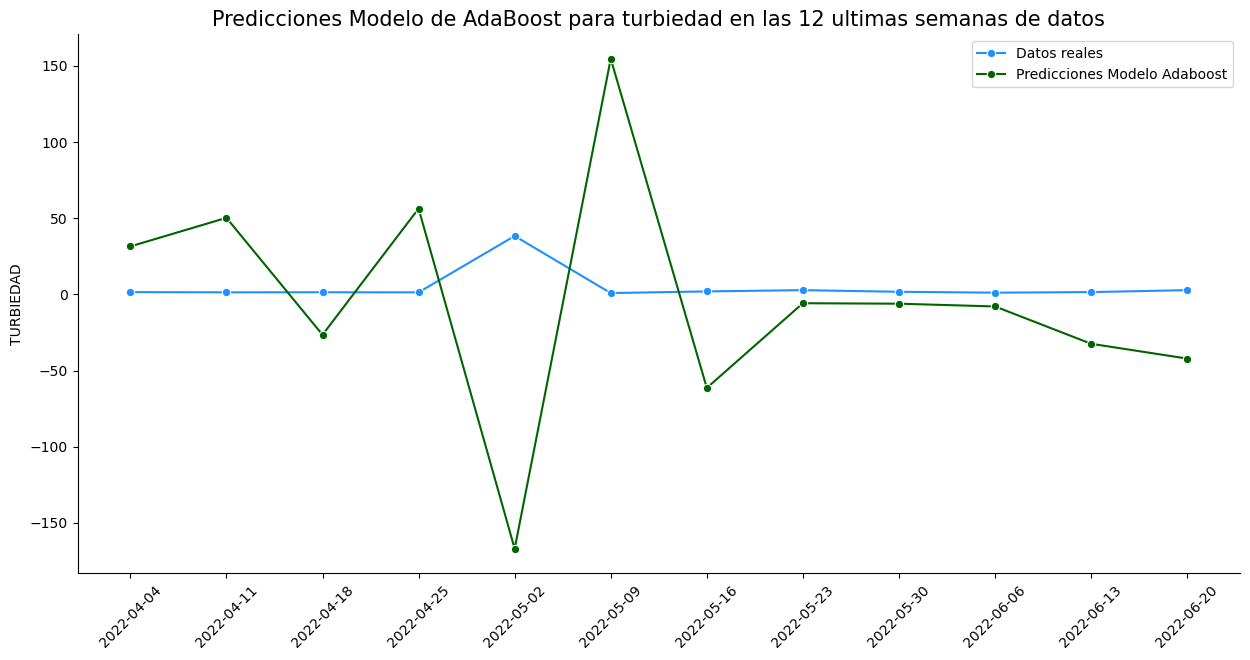

In [1193]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo de AdaBoost para turbiedad en las {test_size} ultimas semanas de datos', size = 15)
sn.lineplot(data = y_test_turbiedad.reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = linreg_ridge.predict(x_test_turbiedad), color = 'darkgreen', label = 'Predicciones Modelo Adaboost', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(Y_turbiedad.index[-test_size:].date), rotation = 45)
sn.despine();

In [1194]:
print(f'MAE:{mean_absolute_error(y_test_turbiedad, linreg_ridge.predict(x_test_turbiedad))}')
print(f'MSE: {mean_squared_error(y_test_turbiedad, linreg_ridge.predict(x_test_turbiedad))}')

MAE:57.380975677021375
MSE: 6692.234090754354


## AdaBoost

In [1195]:
ada_turbiedad_exogen = AdaBoostRegressor().fit(x_train_turbiedad, y_train_turbiedad)

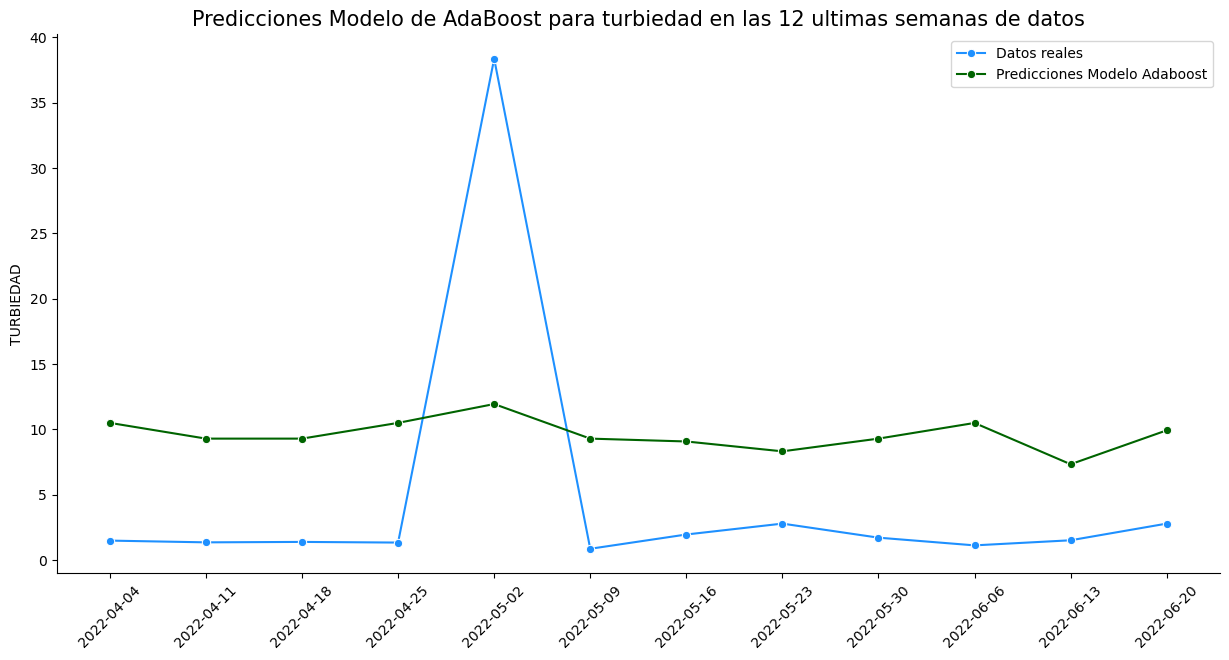

In [1196]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo de AdaBoost para turbiedad en las {test_size} ultimas semanas de datos', size = 15)
sn.lineplot(data = y_test_turbiedad.reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = ada_turbiedad_exogen.predict(x_test_turbiedad), color = 'darkgreen', label = 'Predicciones Modelo Adaboost', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(Y_turbiedad.index[-test_size:].date), rotation = 45)
sn.despine();

In [1197]:
print(f'MAE:{mean_absolute_error(y_test_turbiedad, ada_turbiedad_exogen.predict(x_test_turbiedad))}')
print(f'MSE: {mean_squared_error(y_test_turbiedad, ada_turbiedad_exogen.predict(x_test_turbiedad))}')

MAE:9.279115552942992
MSE: 114.11214759537619


## XGBoost - mejor

In [1198]:
xg_turbiedad_exogen = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 100).fit(x_train_turbiedad, y_train_turbiedad)

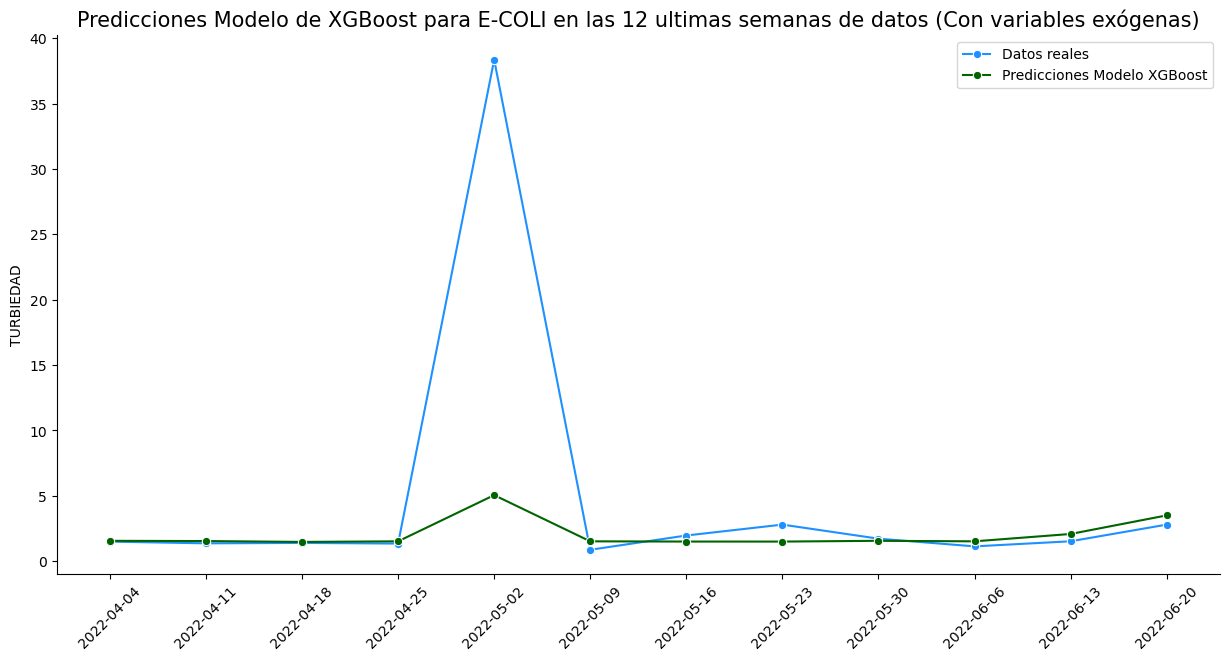

In [1199]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo de XGBoost para E-COLI en las {test_size} ultimas semanas de datos (Con variables exógenas)', size = 15)
sn.lineplot(data = y_test_turbiedad.reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = xg_turbiedad_exogen.predict(x_test_turbiedad), color = 'darkgreen', label = 'Predicciones Modelo XGBoost', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(Y_turbiedad.index[-test_size:].date), rotation = 45)
sn.despine();

In [1200]:
print(f'MAE:{mean_absolute_error(y_test_turbiedad, xg_turbiedad_exogen.predict(x_test_turbiedad))}')
print(f'MSE: {mean_squared_error(y_test_turbiedad, xg_turbiedad_exogen.predict(x_test_turbiedad))}')

MAE:3.1666184887999584
MSE: 92.66341297362312


## SARIMAX

In [1201]:
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [1202]:
%%time
exog_series = data_exogena_padded.drop(columns = ['TURBIEDAD'])
endog_series = data_exogena_padded['TURBIEDAD']
rolling_predictions = []

for i in range(test_size):
    exog_train = exog_series[:-(test_size-i)]
    endog_train = endog_series[:-(test_size-i)]
    model = SARIMAX(endog = endog_train, exog = exog_train ,order = (ar_order, diff_order, ma_order))
    model_fit = model.fit(disp = False)
    pred = model_fit.forecast(exog = exog_train.iloc[-1, :])# + res.seasonal[-1:].values
    rolling_predictions.append(pred.values[0])#.append(np.sqrt(pred.variance.values[-1,:][0]))

CPU times: user 13.3 s, sys: 180 ms, total: 13.5 s
Wall time: 2.67 s


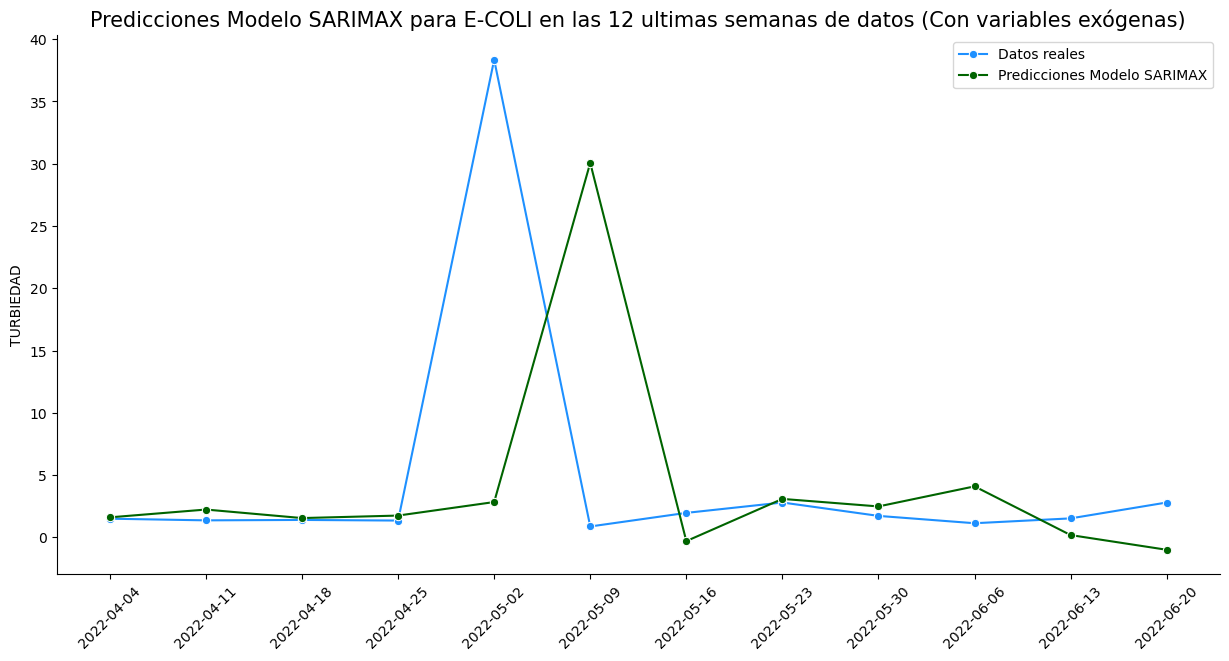

In [1203]:
plt.subplots(figsize = (15,7))
plt.title(f'Predicciones Modelo SARIMAX para E-COLI en las {test_size} ultimas semanas de datos (Con variables exógenas)', size = 15)
sn.lineplot(data = y_test_turbiedad.reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
sn.lineplot(data = rolling_predictions, color = 'darkgreen', label = 'Predicciones Modelo SARIMAX', marker = 'o')
plt.xticks(ticks = range(test_size), labels = list(Y_turbiedad.index[-test_size:].date), rotation = 45)
sn.despine();

In [1204]:
print(f'MAE:{mean_absolute_error(y_test_turbiedad, rolling_predictions)}')
print(f'MSE: {mean_squared_error(y_test_turbiedad, rolling_predictions)}')

MAE:6.470312778535686
MSE: 178.76289280119673


-------


# Información Localidad

- 82 Coyhaique
> - __MOP__
>> - Rio Simpson bajo junta coyhaique
>> - Rio Coyhaique 
> - __CR2__
>> - Escuela Agrícula (diaria)
>> - 
- 255 Puerto Chacabuco
> - __MOP__
>> Puerto Chacabuco
> - __CR2__
>> - Precipitaciones: No tiene
>> - Temperatura: No tiene
- 256 Puerto cisnes
> - __MOP__
>> - Puerto Cisnes
> - __CR2__
>> - Precipitaciones: Puerto Cisnes (diaria)
>> - Temperatura: No tiene
- 22 Balmaceda
>- __MOP__
>> - Rio blanco chico antes de junta oscuro
> - __CR2__:
>> - Aeropuerto Balmaceda
- 254 Puerto Aysen
> - __MOP__
>> - Pureto Aysen
>> - Rio Aysen en puerto aisen
> - __CR2__
>> - Puerto Aisen ad. (diaria)
- 62 Cochrane
> - __MOP__
>> - Rio Cochrane en Cochrane
> - __CR2__
>> - Cochrane
- 257 Puerto Ibañez
> - __MOP__
>> - Rio Ibañez en Desembocadura
> - __CR2__
>> - Rio Ibañez en desembocadura
- 55 Chile Chico
> - __MOP__
>> - Lago General carrera en puerto guadal
>> - Rio Jeimini en nacimineto
>> - Lago General carrera fachinal
>> - lago general carrera en desague
> - __CR2__
>> - Aerodromo Chile Chico



# E-COLI

In [418]:
import re

In [844]:
def preproc_data_weekly2(data, target = 'valor', date_col = 'fecha_muestra',attr_col = 'codigo_parametro', localidad_col = 'codigoLocalidad',
                        user_classes = ['COLOR VERD', 'CT', 'E-COLI', 'TURBIEDAD'],
                        mantain_columns = ['precipitacion', 'temperatura'],
                        drop_NaN_classes = True, use_lag = False, lag = 3):
    df = copy(data) #@
    df.dropna(subset = target, inplace = True)
    
    # columna entregada en date_col debe seguir formato yyyy-mm-dd
    df.fecha_muestra = pd.to_datetime(df[date_col], format = '%Y-%m-%d')
    
    # Shift de 7 dias para que las mediciones aparezcan como tomadas al principio de la correspondiente semana
    df['Date'] = pd.to_datetime(df[date_col]) - pd.to_timedelta(7, unit='d')
    
#    df.set_index('Date', inplace = True)
#    df = df.resample('W-MON').ffill()
    
    weekly = df.groupby([
        localidad_col, attr_col, pd.Grouper(key='Date', freq='W-MON')])[target]\
                                                                        .mean()\
                                                                        .reset_index()
                                                                       #.sort_values('Date')
    weekly_pivoted = pd.pivot_table(data = weekly, index = [localidad_col, 'Date'], columns = attr_col, values = target)[user_classes].reset_index()
    weekly_pivoted.columns.name =  None

    weekly_pivoted =  pd.concat([weekly_pivoted[weekly_pivoted[localidad_col] == localidad]\
                      .set_index('Date').resample('W-MON').ffill().reset_index()\
                      for localidad in weekly_pivoted[localidad_col].unique()], axis = 0, ignore_index = True).set_index([localidad_col, 'Date'])

    if len(mantain_columns) > 0:
        aux_df = df.groupby([localidad_col, pd.Grouper(key = 'Date', freq = 'W-MON')]).mean().reset_index()
        aux_df = pd.concat([aux_df[aux_df[localidad_col] == localidad]\
                      .set_index('Date').resample('W-MON').ffill().reset_index()\
                      for localidad in aux_df[localidad_col].unique()], axis = 0).set_index([localidad_col, 'Date'])[mantain_columns]
        return aux_df, weekly_pivoted
#        return weekly_pivoted.join(aux_df).reset_index().set_index('Date').resample('W-MON').ffill().reset_index()
    else:
        out_df = weekly_pivoted
        
    if drop_NaN_classes: # Para obtener una matriz de atributos siempre densa
        out_df.dropna(inplace = True)

    return out_df
    

In [516]:
pr18_files = glob('modeloRiesgoAmbiental/DATOS INTERNOS TOTAL LOCALIDADES/Historial PR18-2 Muestras/*.csv')
pr18 = pd.concat([pd.read_csv(file, index_col=0) for file in pr18_files], axis = 0)
pr18['fecha_muestra'] = pd.to_datetime(pr18['fecha_muestra'])

In [460]:
codigoLocalidad_dict = {'Coyhaique': 82, 'PuertoChacabuco': 255, 'PuertoCisnes': 256, 'Balmaceda': 22, 'PuertoAysen': 254, 'Cochrane': 62,
                        'PuertoIbanez': 257, 'ChileChico': 55}

In [ ]:
localidad_re = re.compile(r'/(\w+)_\w+_\w+\.xlsx')

In [1044]:
pr18_proc_Localidad = pd.pivot_table(data = pr18, index = ['codigoLocalidad', 'fecha_muestra'], columns = 'codigo_parametro', values = 'valor')[['COLOR VERD', 'CT', 'E-COLI', 'TURBIEDAD']].reset_index()

In [1045]:
pr18_proc_Localidad =  pd.concat([pr18_proc_Localidad[pr18_proc_Localidad['codigoLocalidad'] == localidad]\
                      .set_index('fecha_muestra').resample('W-MON').ffill().reset_index()\
                      for localidad in pr18_proc_Localidad['codigoLocalidad'].unique()], axis = 0, ignore_index = True).set_index(['codigoLocalidad', 'fecha_muestra'])

In [1046]:
weekly_precipitaciones_Localidad = weekly_precipitaciones.reset_index().groupby(by = ['codigoLocalidad', pd.Grouper(key = 'fecha_muestra', freq = 'W-MON')]).mean()\
.reset_index().groupby(by = ['codigoLocalidad', 'fecha_muestra']).mean()

weekly_temperaturas_Localidad = weekly_temperaturas.reset_index().groupby(by = ['codigoLocalidad', pd.Grouper(key = 'fecha_muestra', freq = 'W-MON')]).mean()\
.reset_index().groupby(by = ['codigoLocalidad', 'fecha_muestra']).mean()

In [1049]:
pr18_proc_Localidad.join(weekly_precipitaciones_Localidad).join(weekly_temperaturas_Localidad)

COLOR VERD    CT  E-COLI  TURBIEDAD  \
codigoLocalidad fecha_muestra                                        
55              2019-10-07            NaN   NaN     1.0       0.50   
                2019-10-14            NaN   NaN     1.0       0.50   
                2019-10-21            NaN   NaN     1.0       0.50   
                2019-10-28            NaN   NaN     1.0       0.50   
                2019-11-04            NaN   NaN     1.0       0.50   
...                                   ...   ...     ...        ...   
257             2022-05-23           10.0  79.0    79.0       0.55   
                2022-05-30           10.0  79.0    79.0       0.55   
                2022-06-06           10.0  79.0    79.0       0.55   
                2022-06-13           10.0  79.0    79.0       0.55   
                2022-06-20           10.0   1.8     1.8       0.85   

                               precipitacion  temperatura  
codigoLocalidad fecha_muestra                              
55              2019-10-07          0.000000     8.485714  
                2019-10-14          0.028571    10.971429  
                2019-10-21          0.333333     9.028571  
                2019-10-28          1.150000     9.620000  
                2019-11-04          0.000000    12.128571  
...                                      ...          ...  
257             2022-05-23          0.000000          NaN  
                2022-05-30          1.671429          NaN  
                2022-06-06          1.957143          NaN  
                2022-06-13          0.371429          NaN  
                2022-06-20          0.642857          NaN  

[842 rows x 6 columns]

<AxesSubplot:>

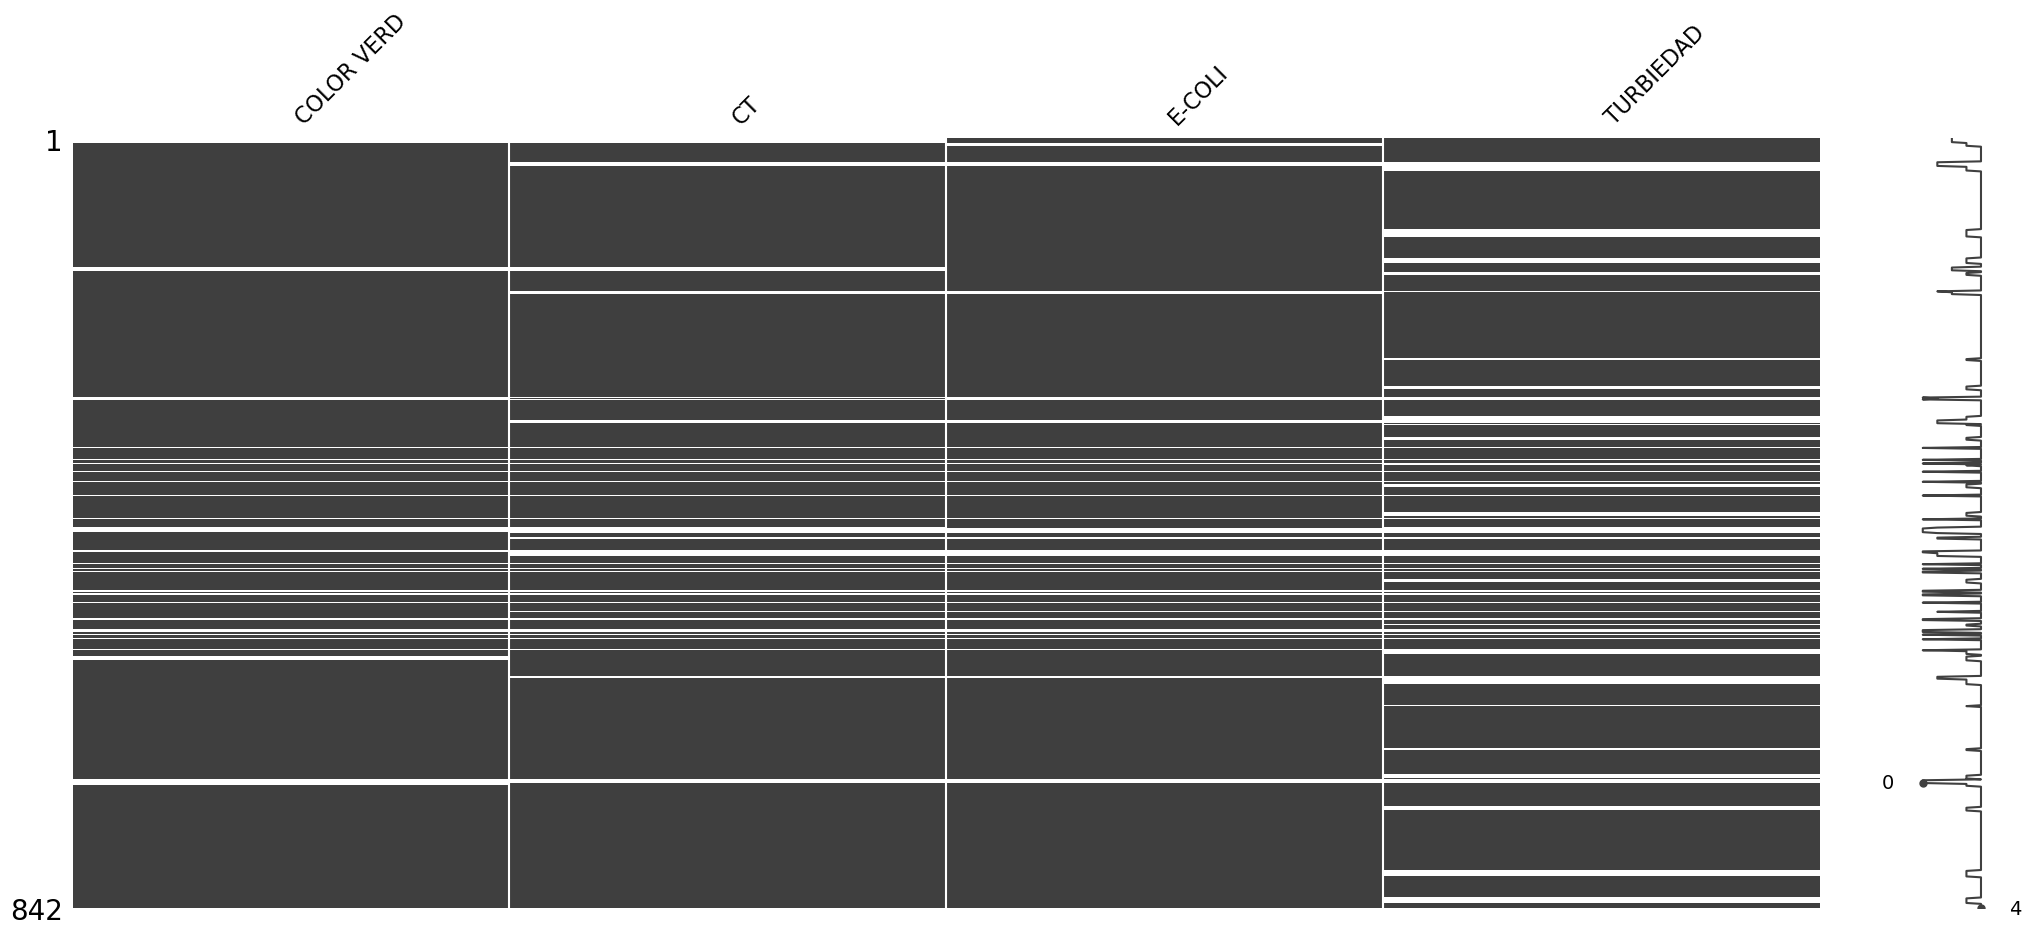

In [1048]:
missingno.matrix(pr18_proc_Localidad)

In [1065]:
model_list = [RidgeCV(cv=5), AdaBoostRegressor(),
              xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 100)]

# Chile Chico

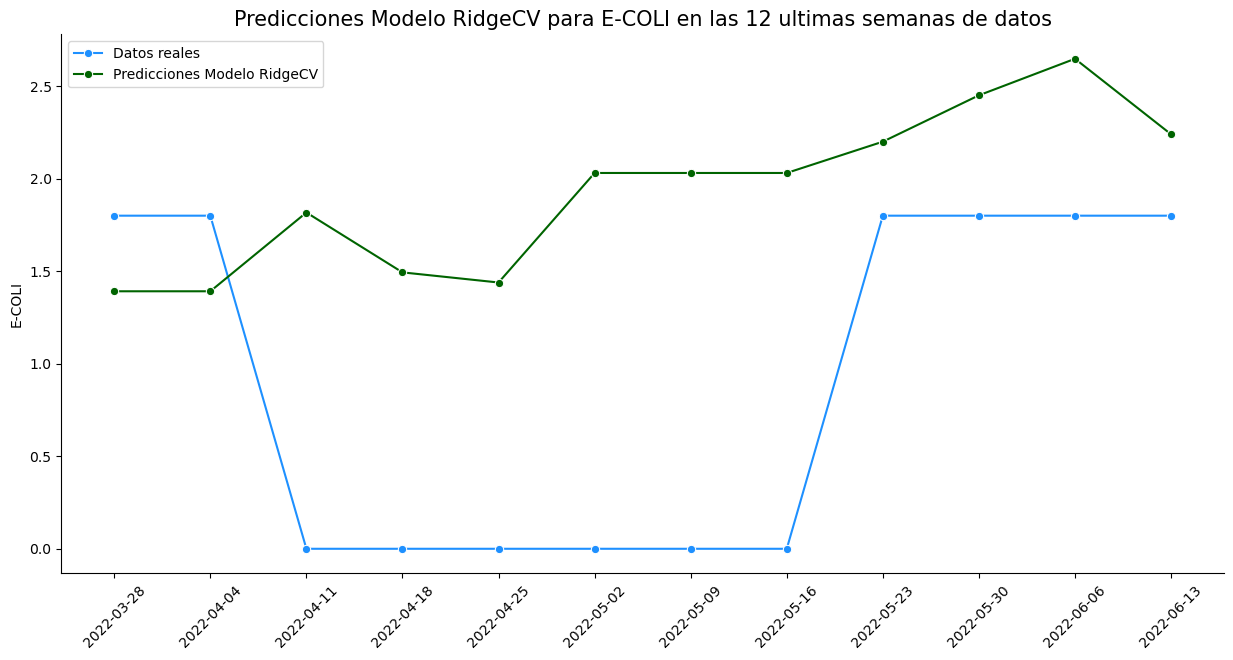

MAE:1.166439707213694
MSE: 1.8170950754852944





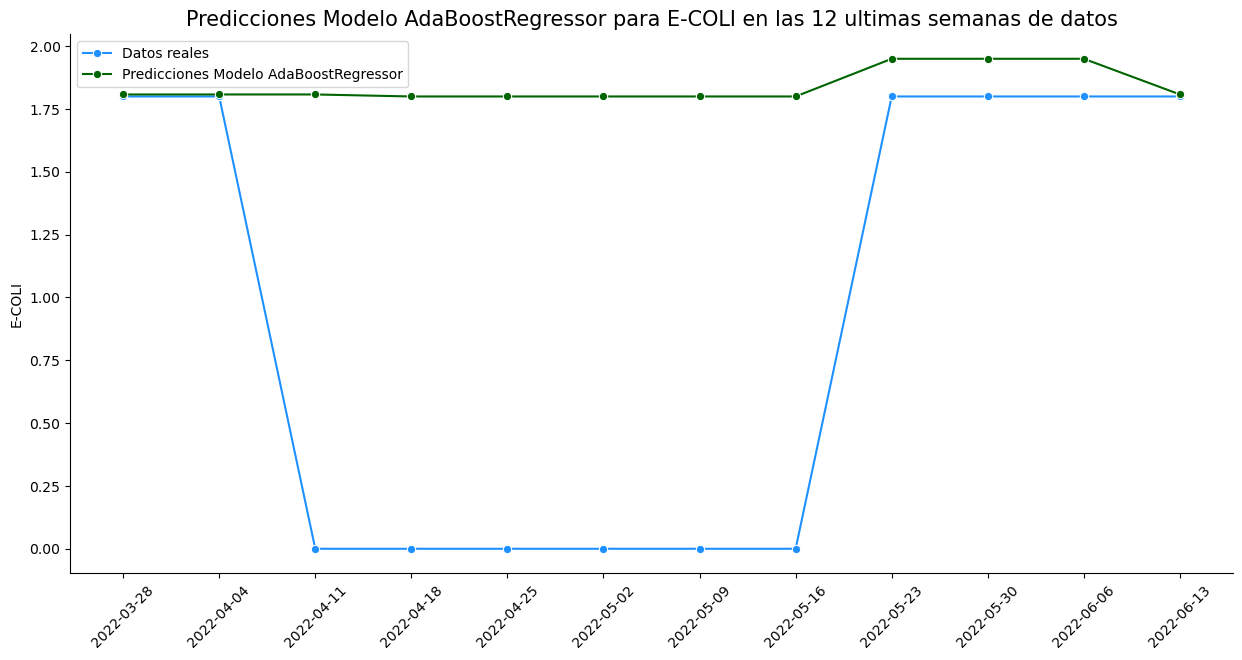

MAE:0.9401666666666659
MSE: 1.628046333333333





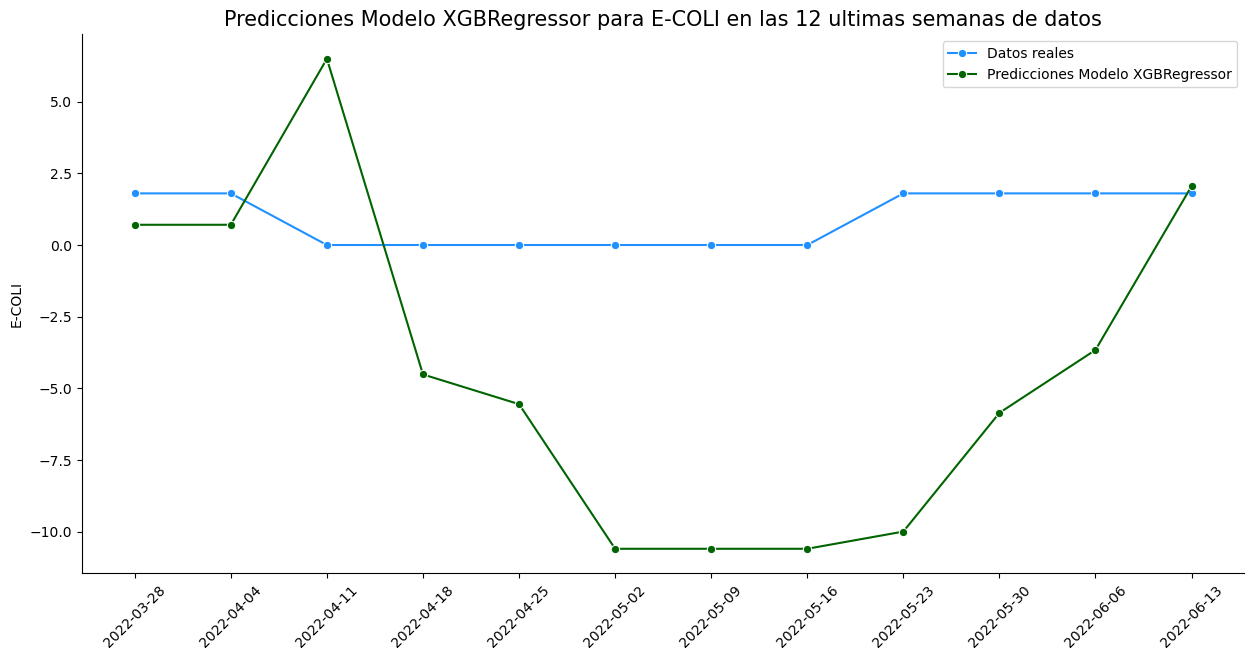

MAE:6.30571635166804
MSE: 54.969541643186794





# Cochrane

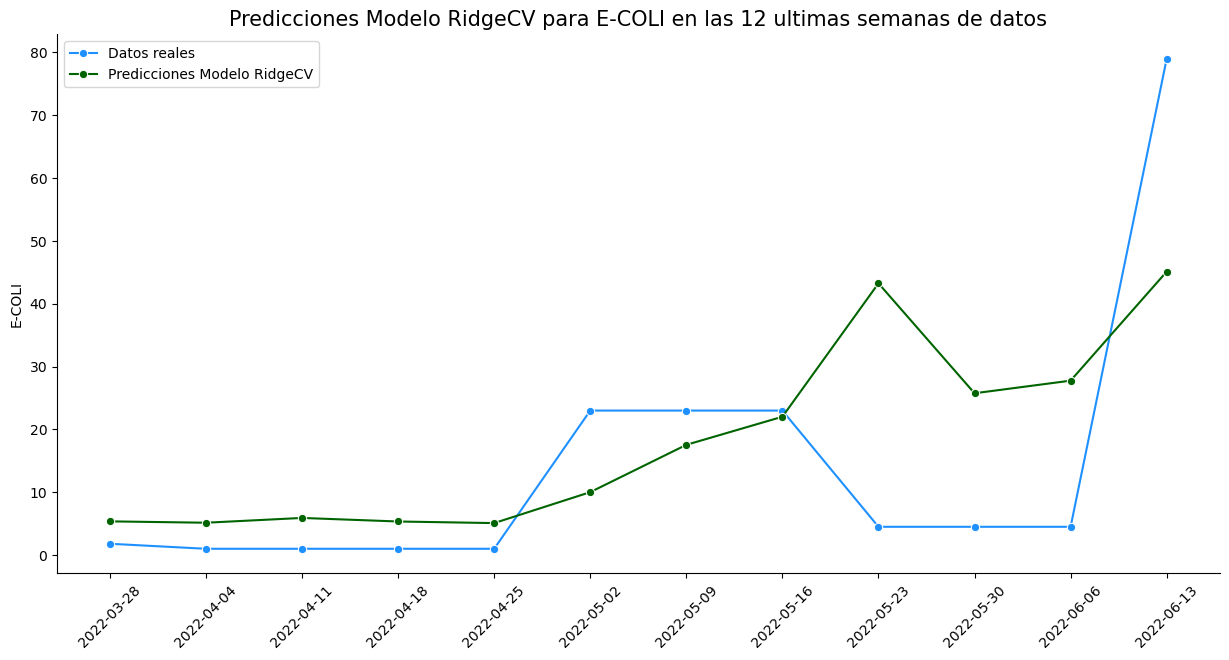

MAE:13.135449606532198
MSE: 327.6353701808239





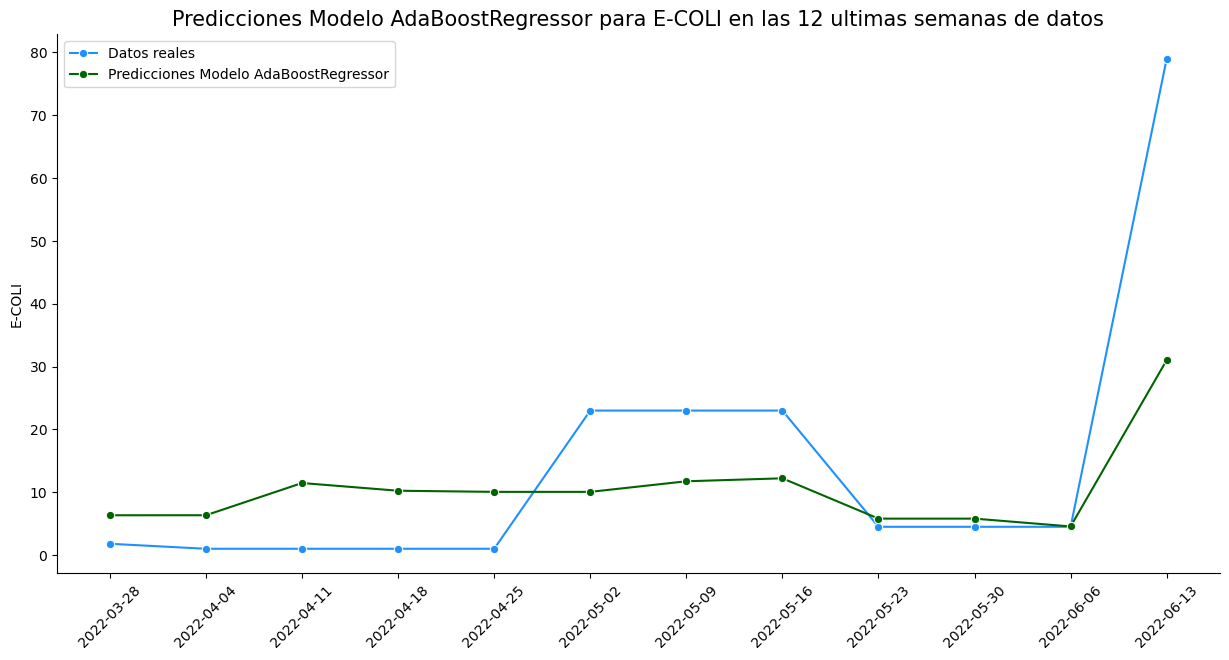

MAE:10.353519570200804
MSE: 253.3982845146546





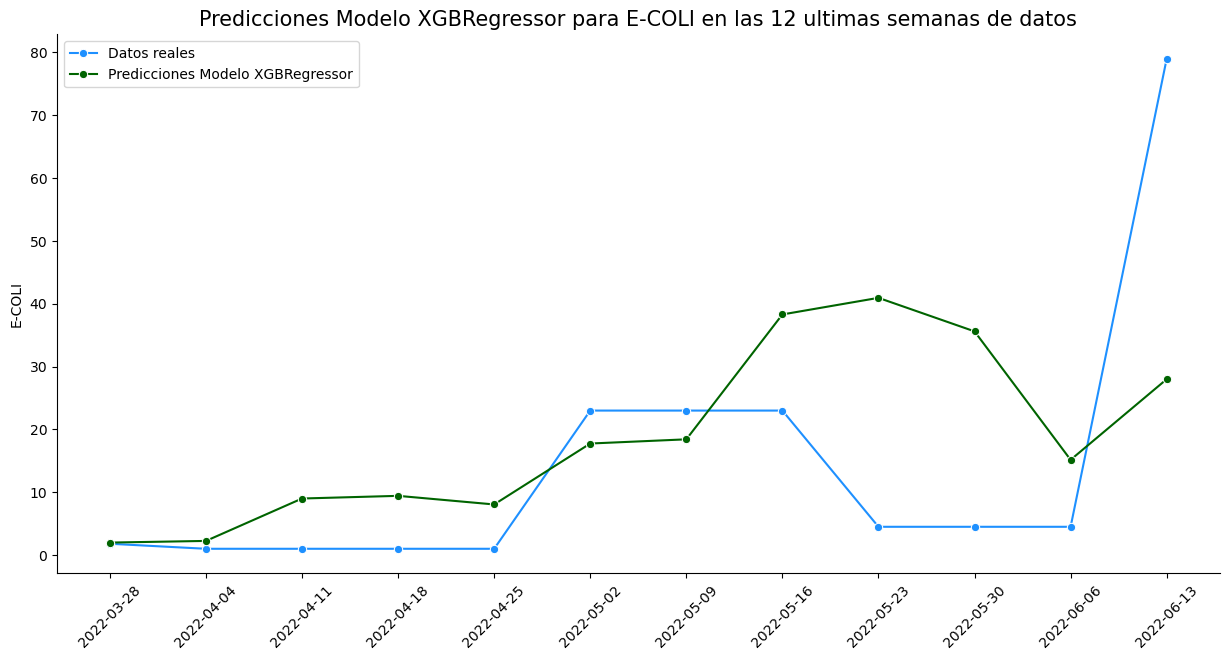

MAE:14.938091055552164
MSE: 456.648386415174





# Coyhaique

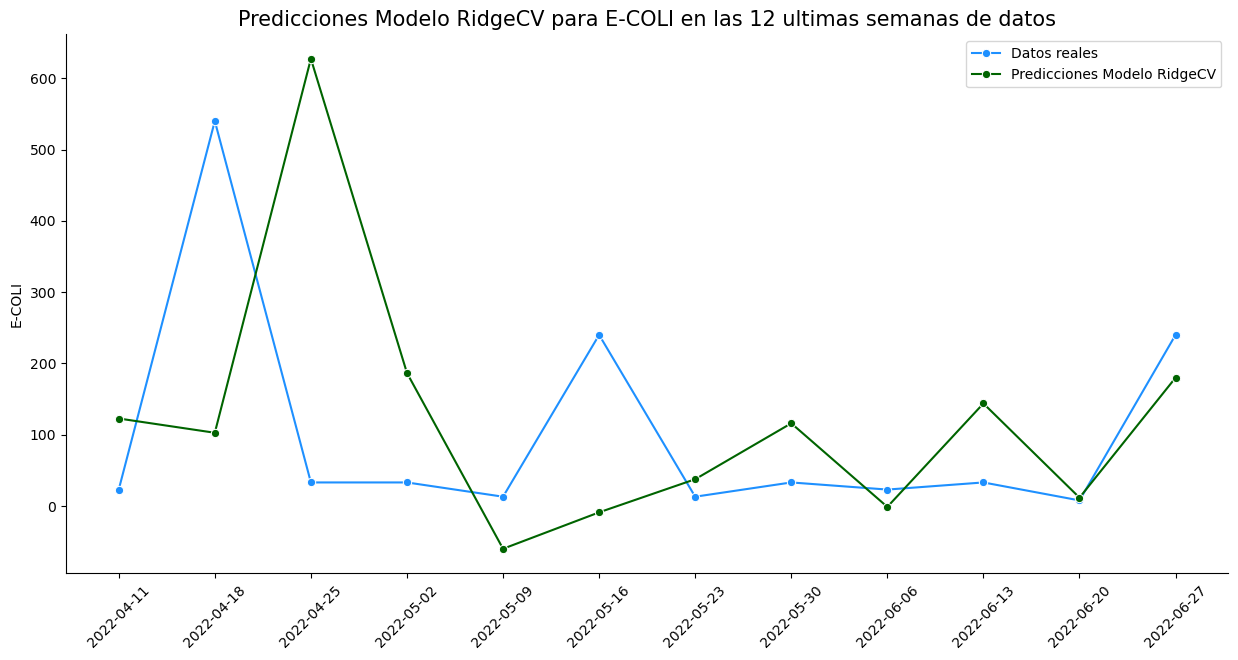

MAE:159.4505437770793
MSE: 55773.809910584154





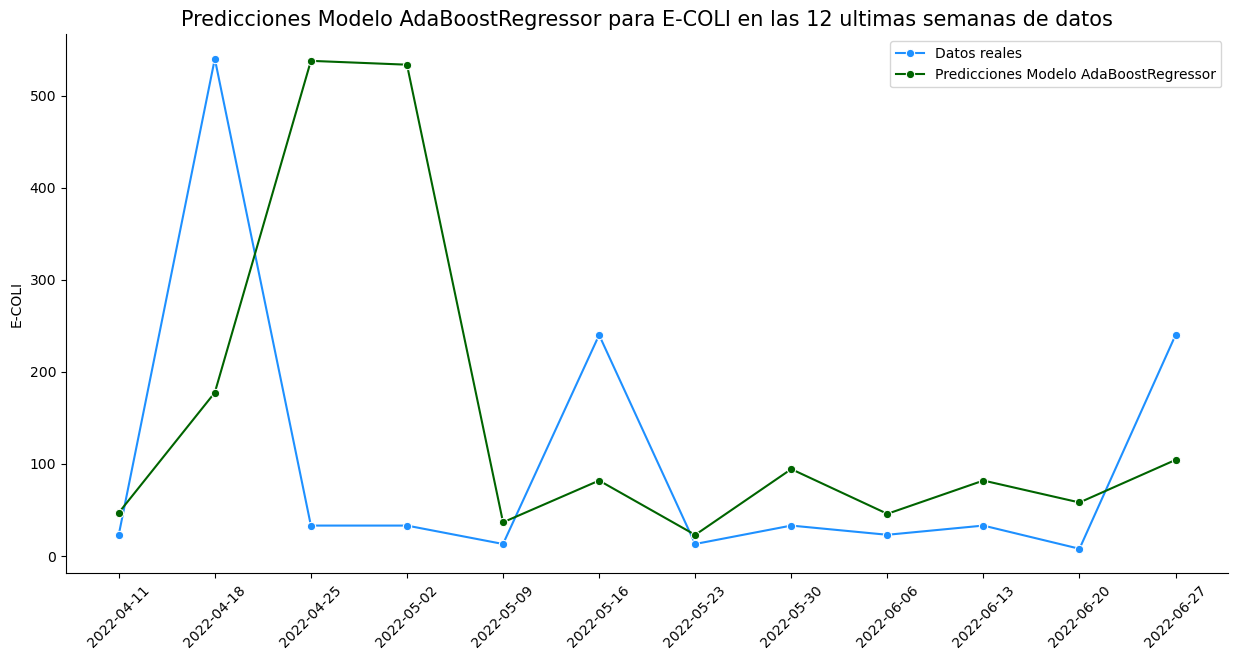

MAE:158.52316424488518
MSE: 57550.0248227623





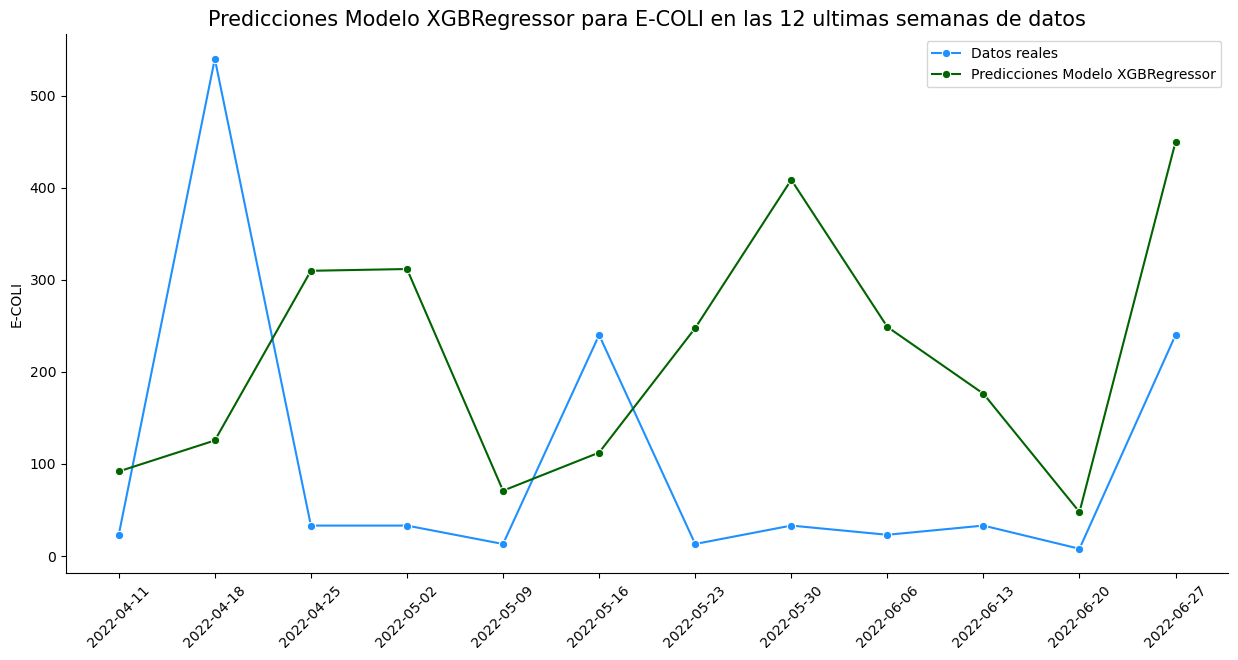

MAE:204.4255043029785
MSE: 55300.54428530854





# Puerto Cacabuco

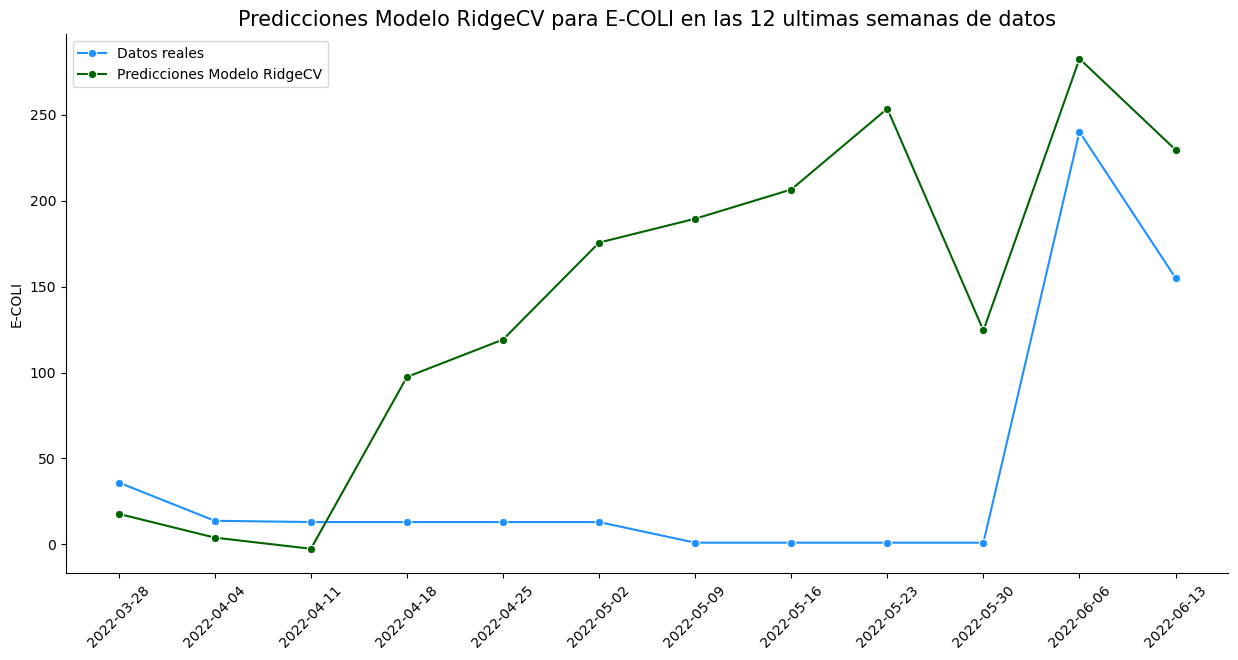

MAE:106.98229196793261
MSE: 17468.454356424616





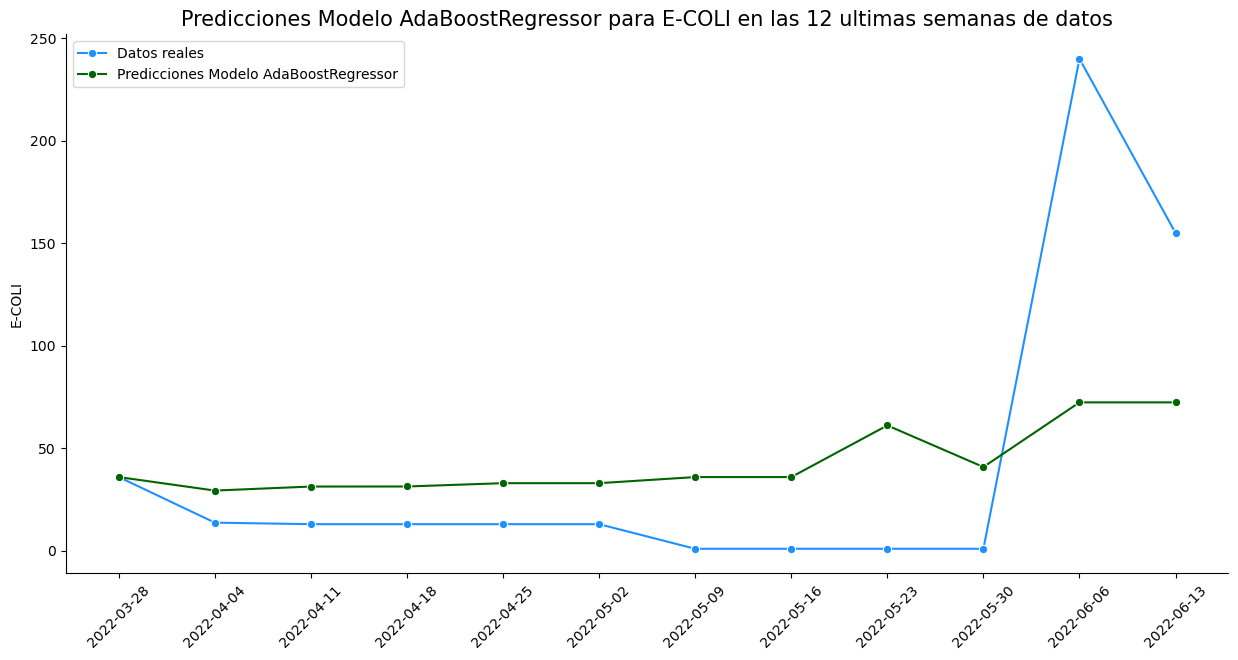

MAE:42.71654100973214
MSE: 3690.561679775712





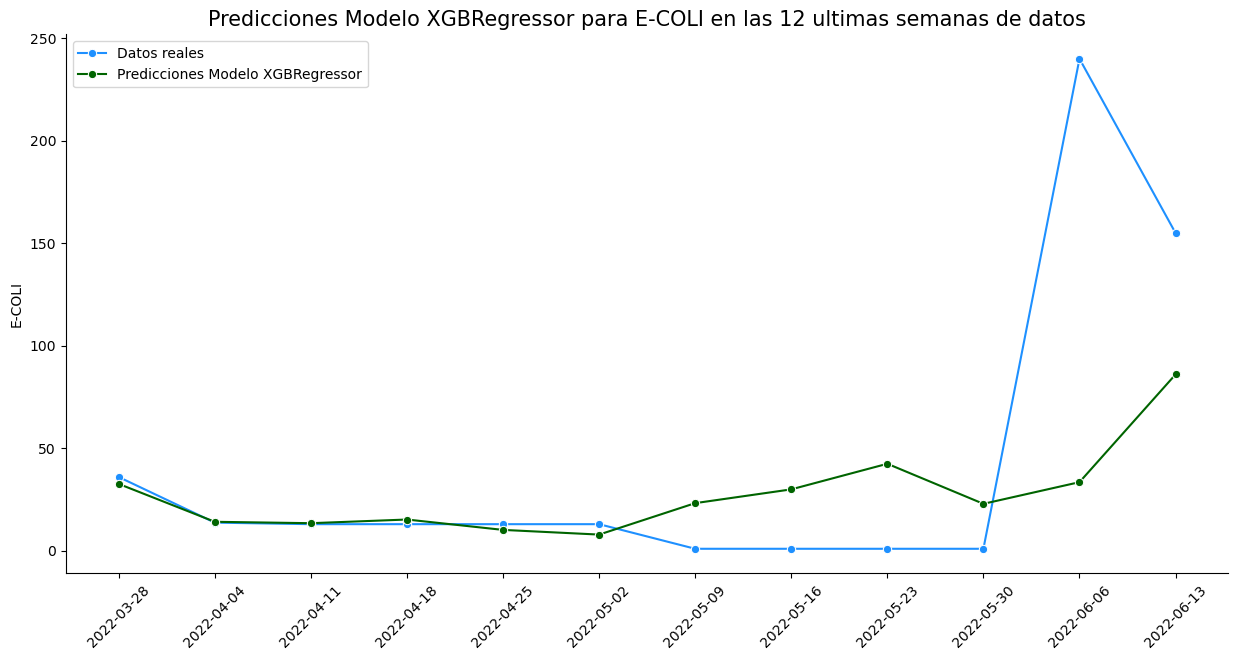

MAE:33.70689880847931
MSE: 4248.5312544281705





# Puerto Cisnes

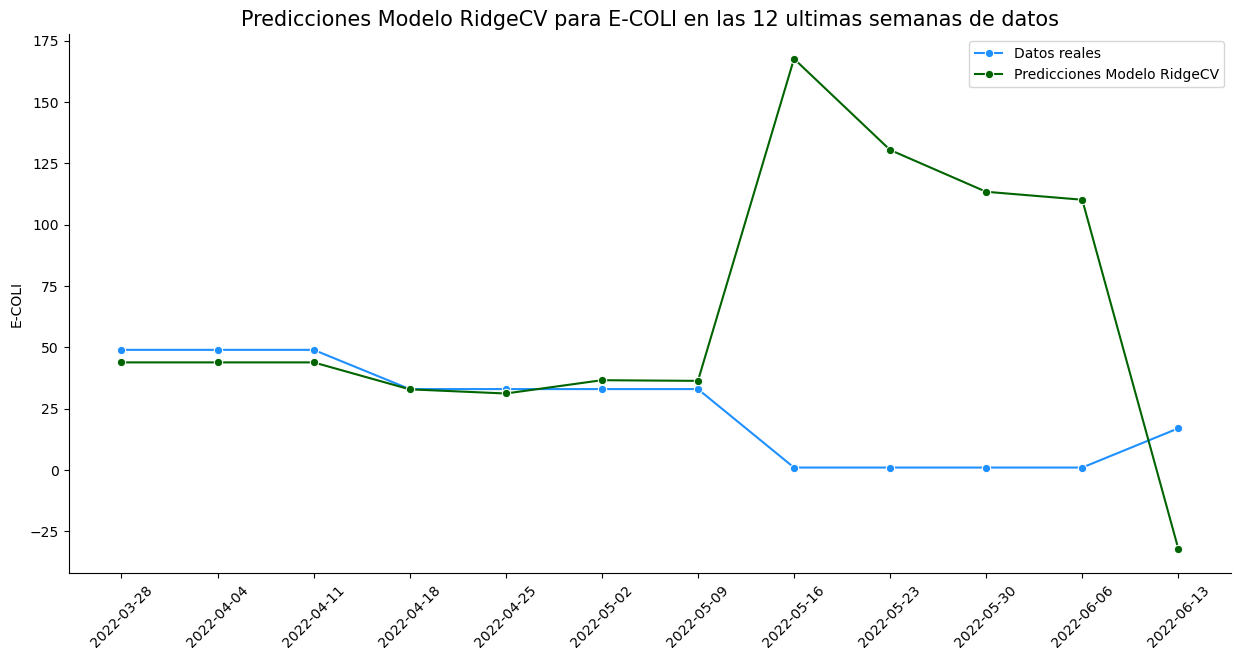

MAE:49.27025749494857
MSE: 5971.8825321611885





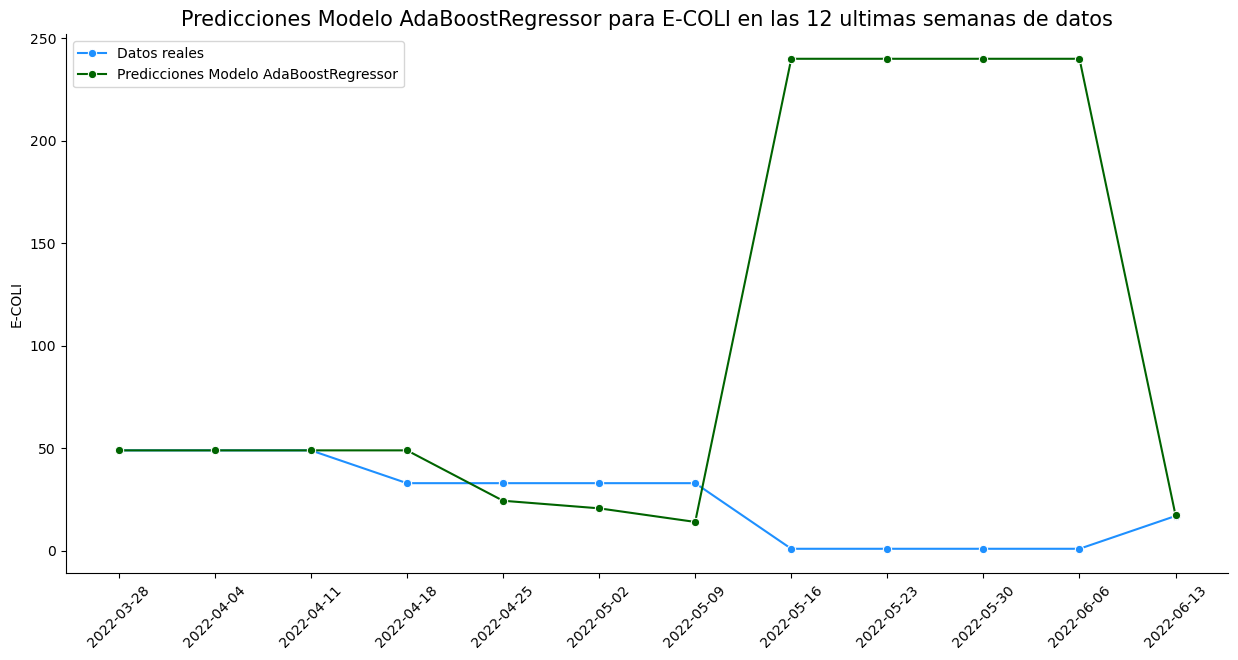

MAE:84.33641648224776
MSE: 19110.1300759353





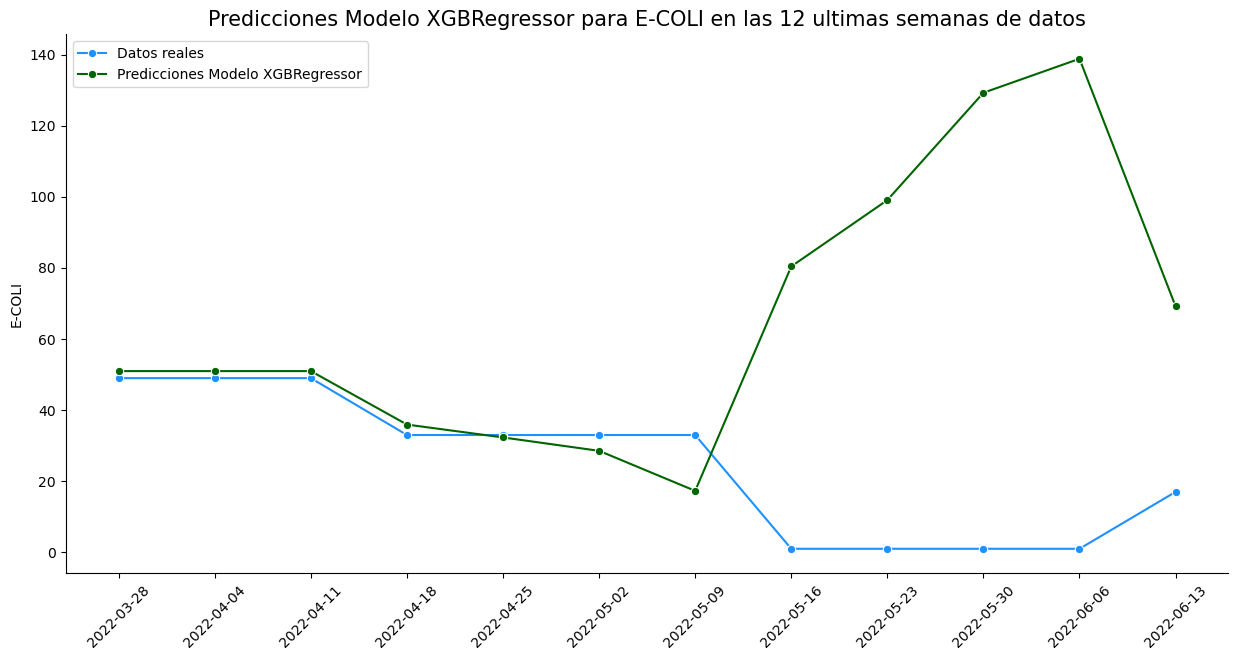

MAE:43.79183276494344
MSE: 4532.220650642026





# Puerto Ibañez

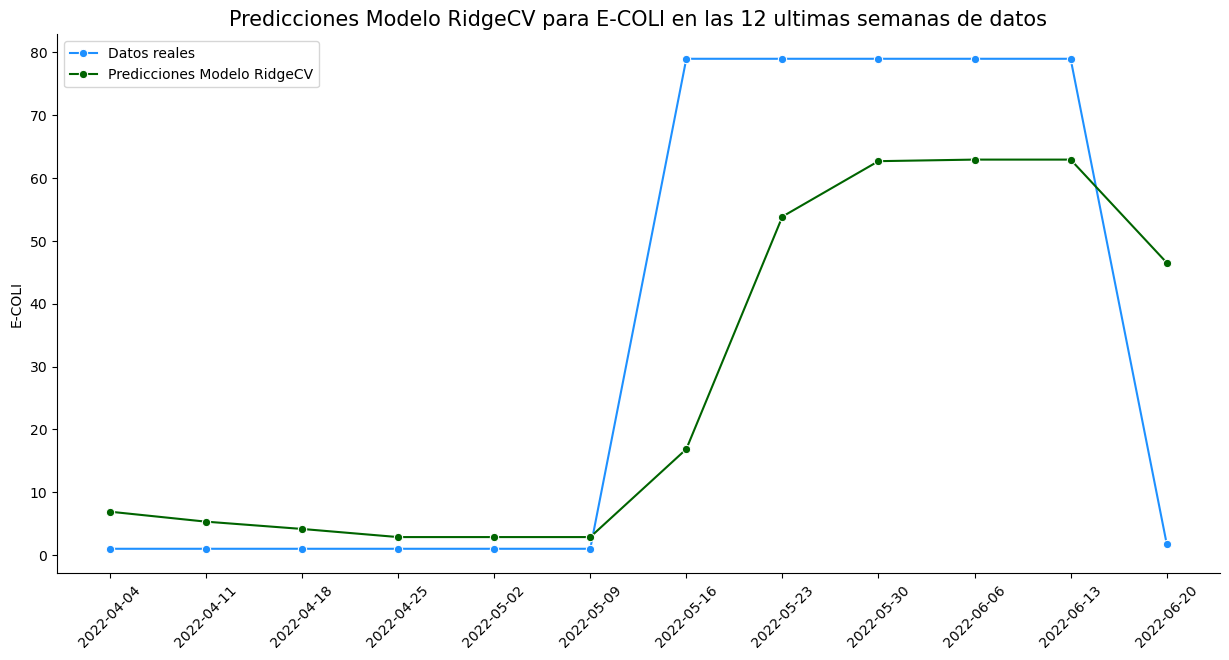

MAE:16.613669332337555
MSE: 612.370905932342





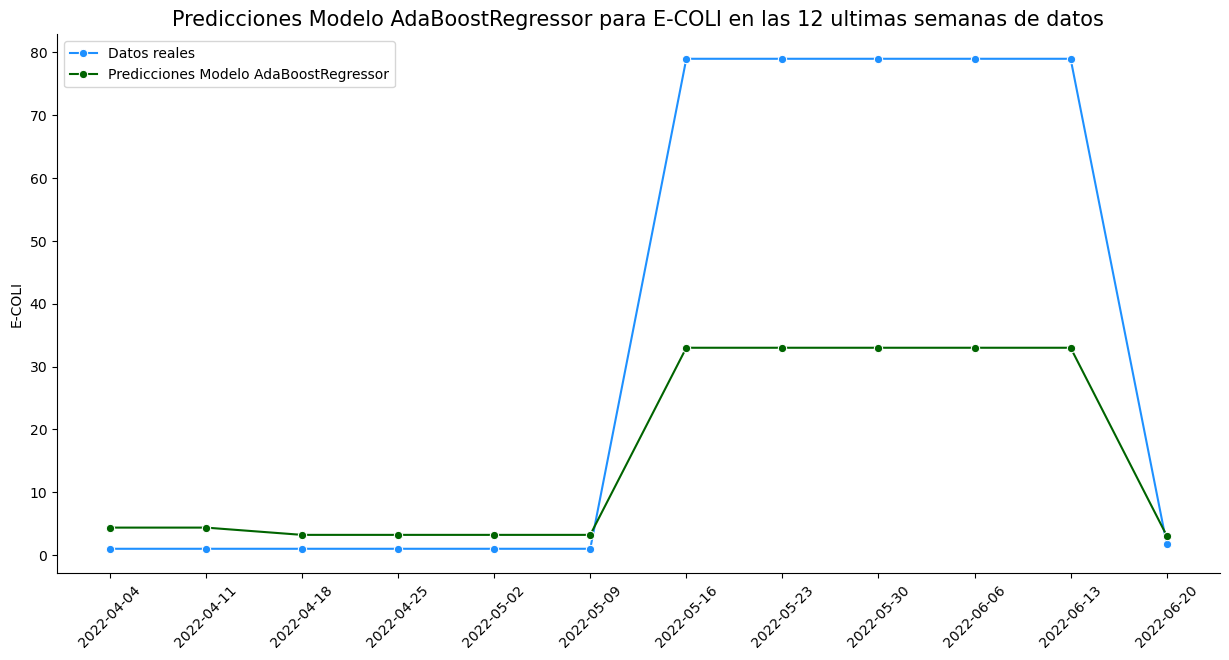

MAE:20.574793305101835
MSE: 885.3350752484652





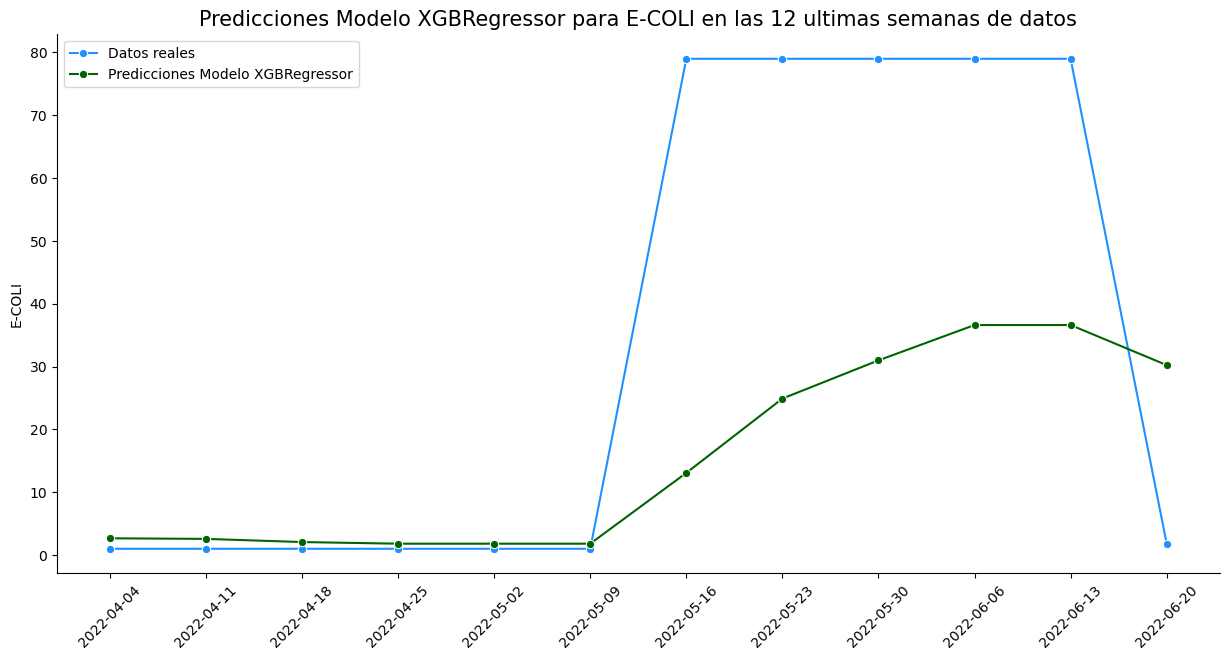

MAE:23.9975014090538
MSE: 1165.5198467566331





In [1205]:
for localidad in list(pr18_proc_Localidad.index.get_level_values(0).unique()):
    localidad_data = pr18_proc_Localidad.loc[localidad, :].fillna(method = 'ffill').dropna()
    lagged_features = buildLaggedFeatures(localidad_data, lag=LAG)
    
    X = lagged_features.drop(columns = ['E-COLI'])
    Y = lagged_features['E-COLI']
    
    x_train = X.iloc[:-test_size,:]
    x_test = X.iloc[-test_size:,:]

    std_exogen_localidad_ecoli = StandardScaler()
    
    x_train = std_exogen_localidad_ecoli.fit_transform(x_train)
    x_test = std_exogen_localidad_ecoli.transform(x_test)
    
    y_train = Y.iloc[:-test_size]
    y_test = Y.iloc[-test_size:]
    display(Markdown(f'# {localidades_dict[localidad]}'))
    for model in model_list:
        trained_model = model.fit(x_train, y_train)
        
        plt.subplots(figsize = (15,7))
        plt.title(f'Predicciones Modelo {type(model).__name__} para E-COLI en las {test_size} ultimas semanas de datos', size = 15)
        sn.lineplot(data = y_test.reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
        sn.lineplot(data = trained_model.predict(x_test), color = 'darkgreen',
                    label = f'Predicciones Modelo {type(model).__name__}', marker = 'o')
        plt.xticks(ticks = range(test_size), labels = list(Y.index[-test_size:].date), rotation = 45)
        sn.despine()
        plt.show()
        print(f'MAE:{mean_absolute_error(y_test, trained_model.predict(x_test))}')
        print(f'MSE: {mean_squared_error(y_test, trained_model.predict(x_test))}')
        print('\n'*2)

# Turbiedad

## Chile Chico

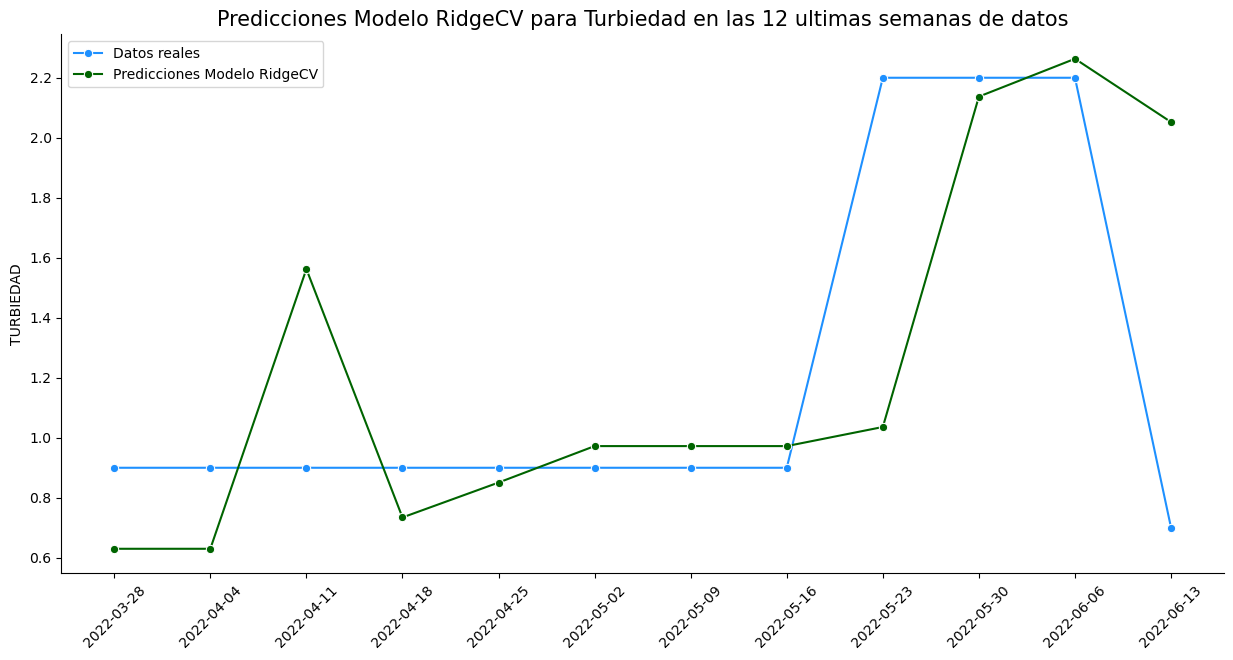

MAE:0.35635363849025414
MSE: 0.3184636554831313





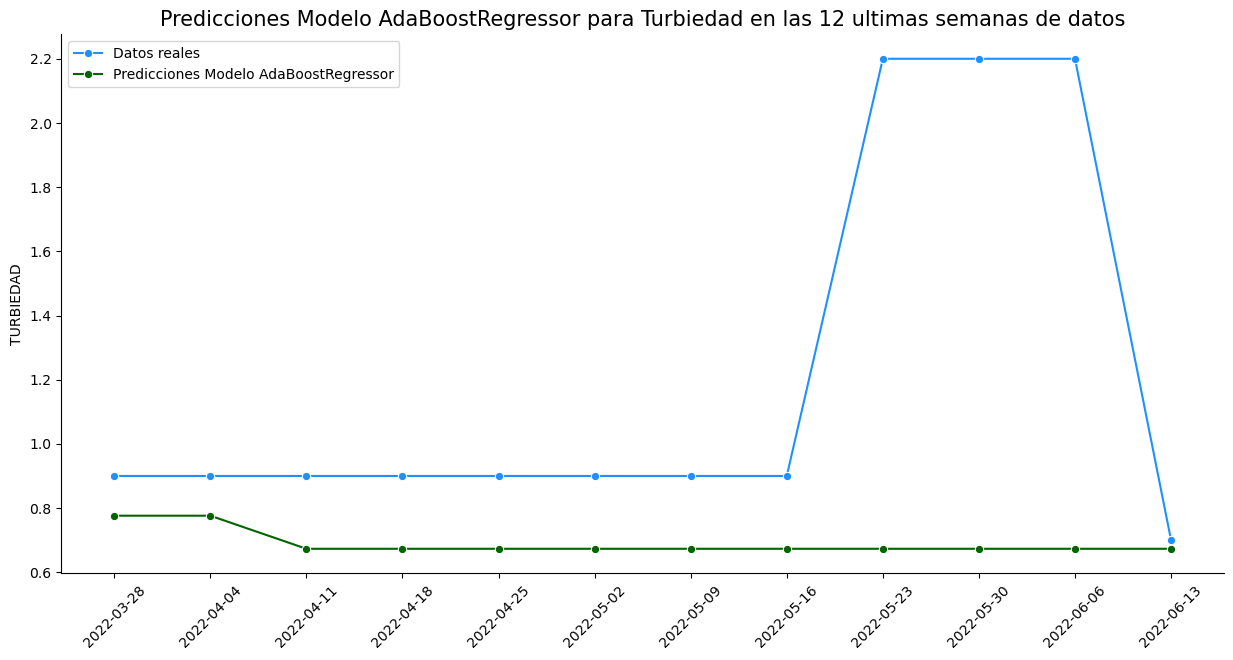

MAE:0.5180708180708181
MSE: 0.611235766167085





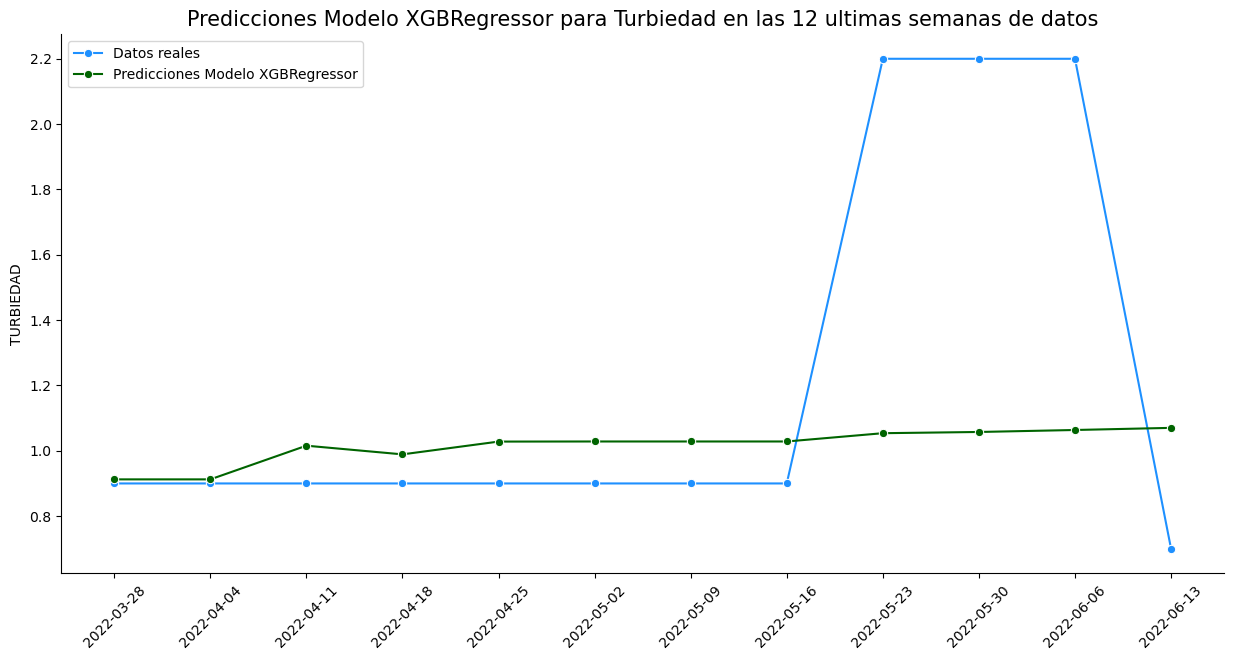

MAE:0.37818410098552707
MSE: 0.34456051129012105





## Cochrane

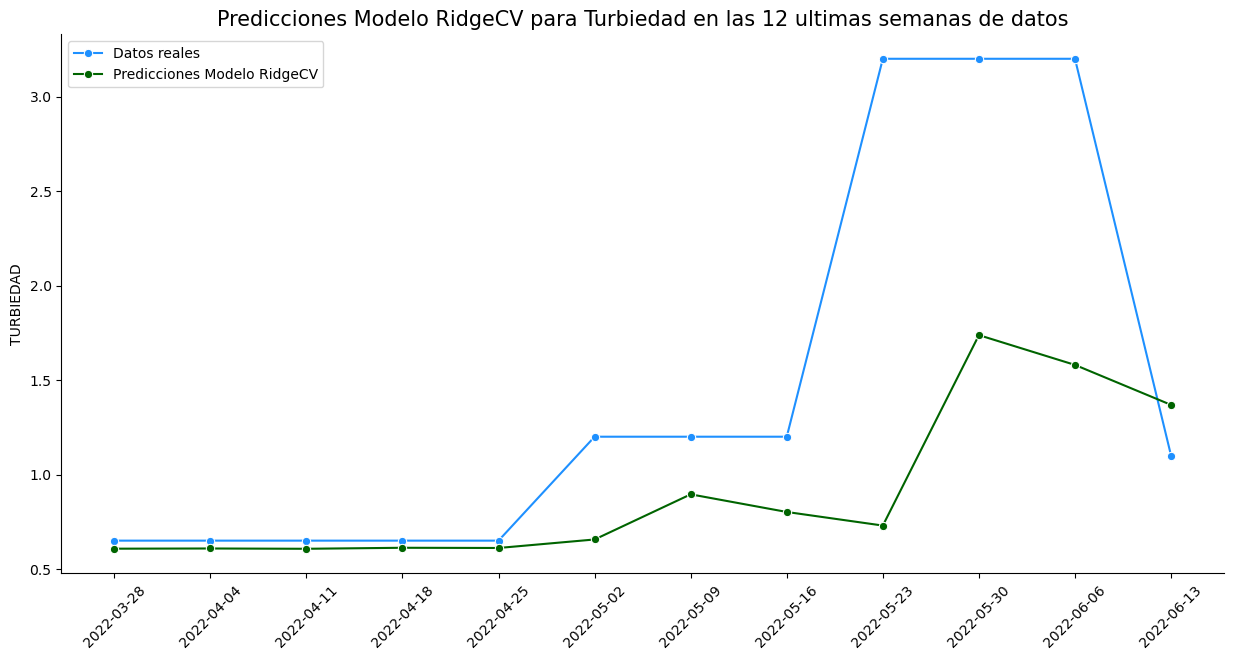

MAE:0.6060072905853695
MSE: 0.9577687576883732





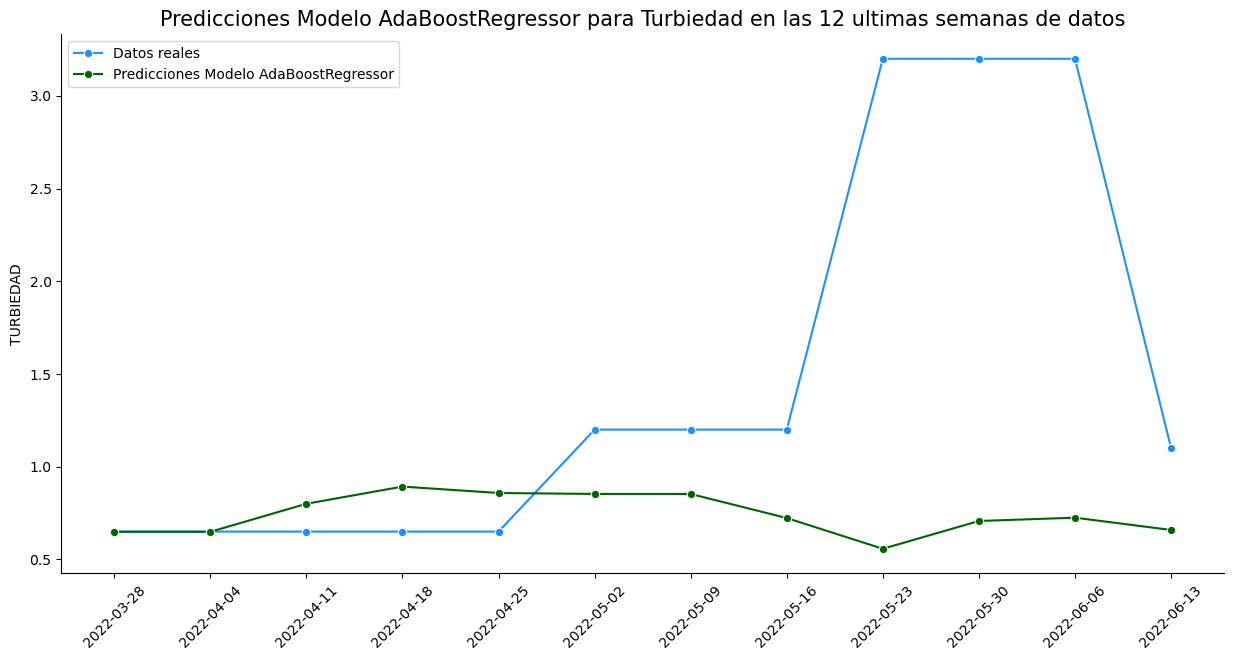

MAE:0.8188040804758483
MSE: 1.675958403379826





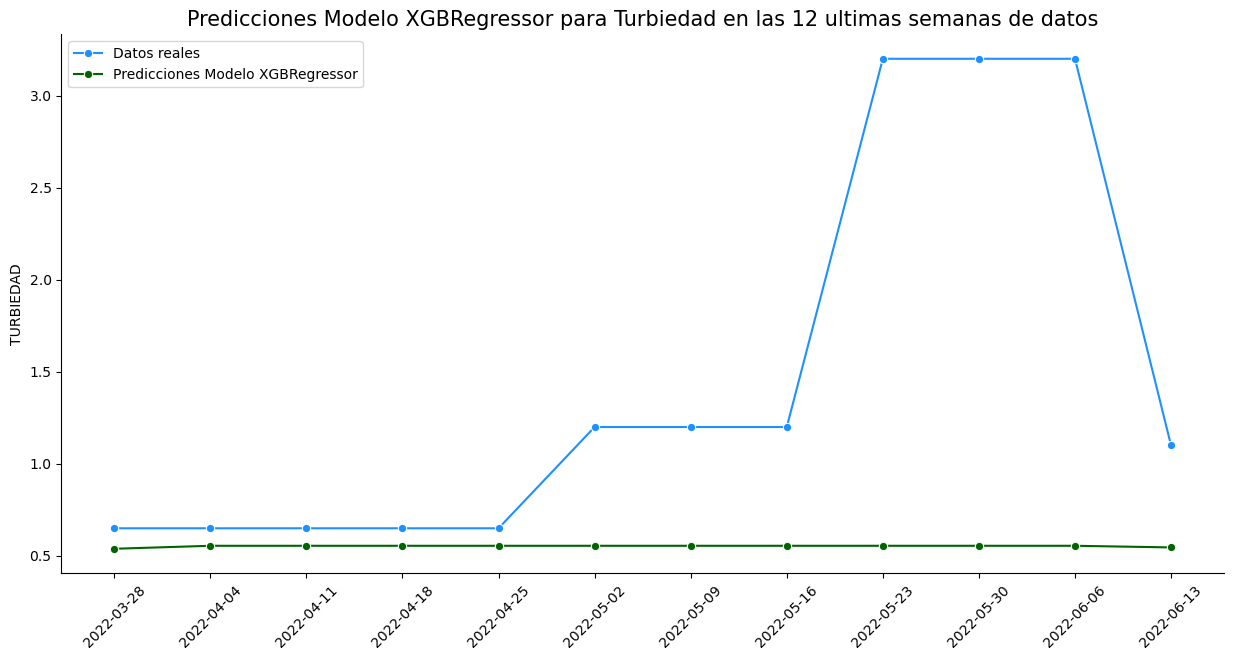

MAE:0.9096085965633393
MSE: 1.8826352373232222





## Coyhaique

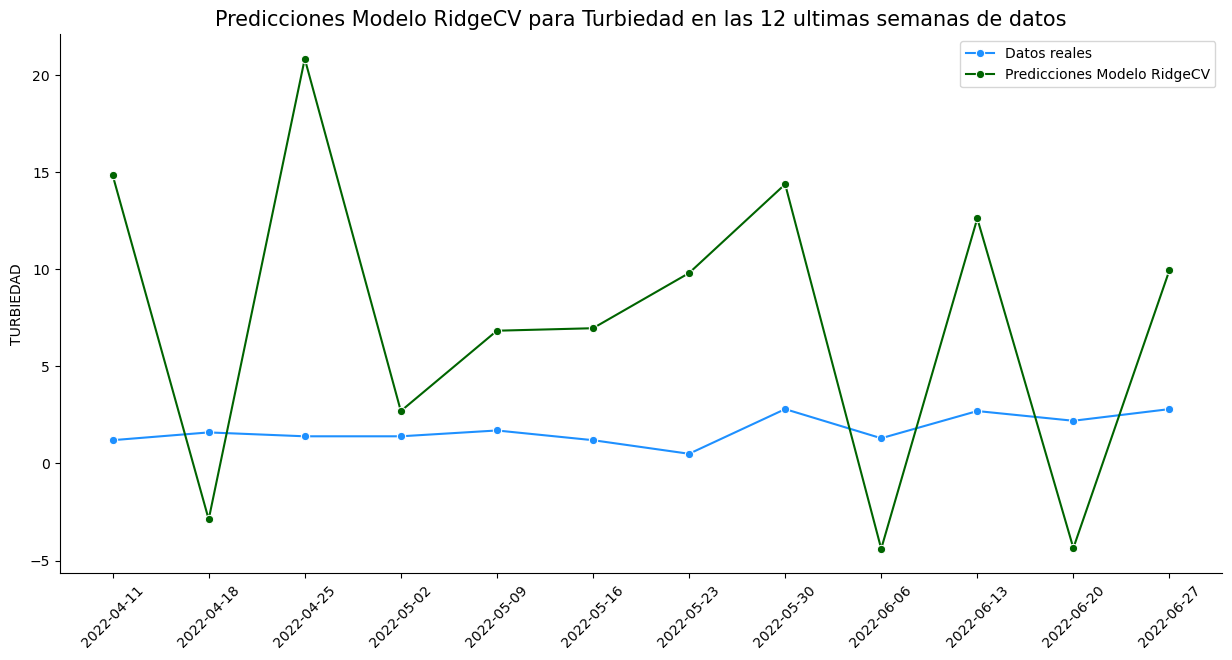

MAE:8.330223335274182
MSE: 90.91465519573494





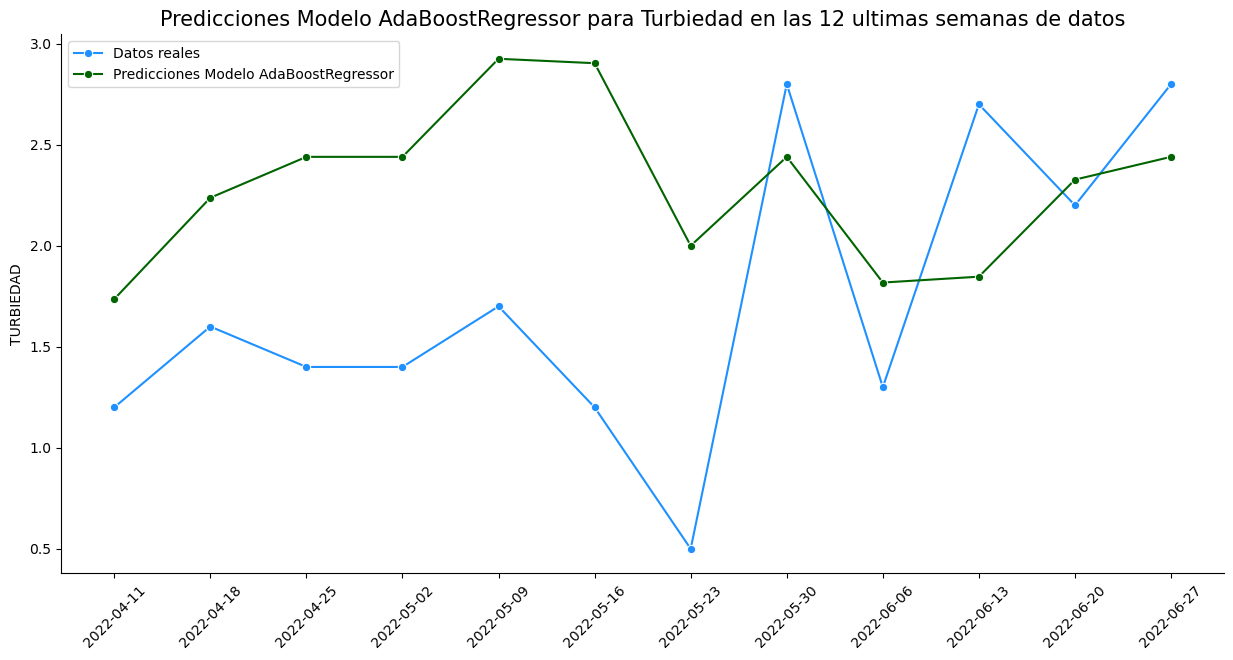

MAE:0.8250360981530661
MSE: 0.8984835430821305





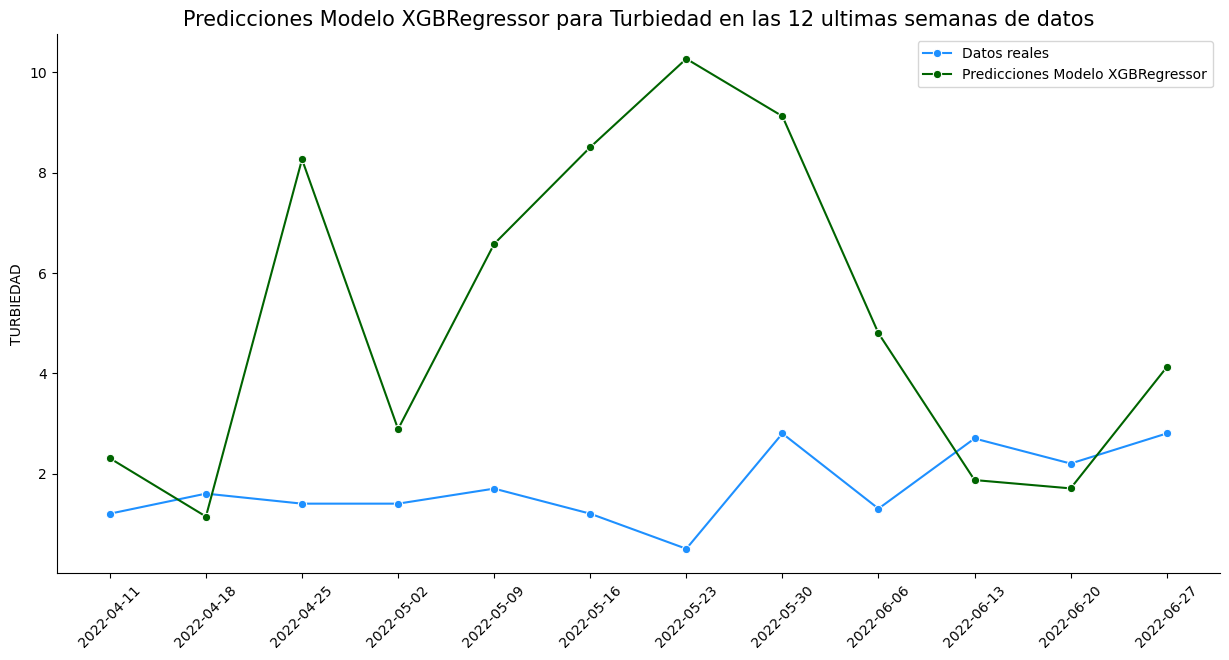

MAE:3.6958491365114856
MSE: 23.208955693761297





## Puerto Cacabuco

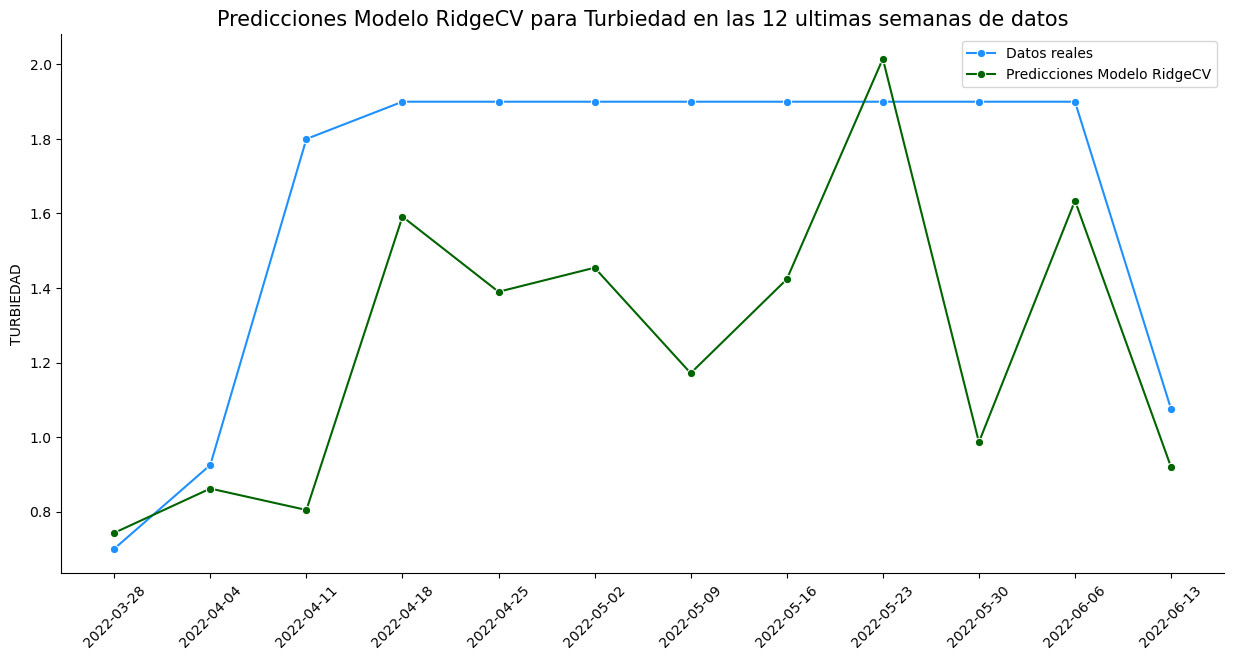

MAE:0.41850410484877115
MSE: 0.27108206054825174





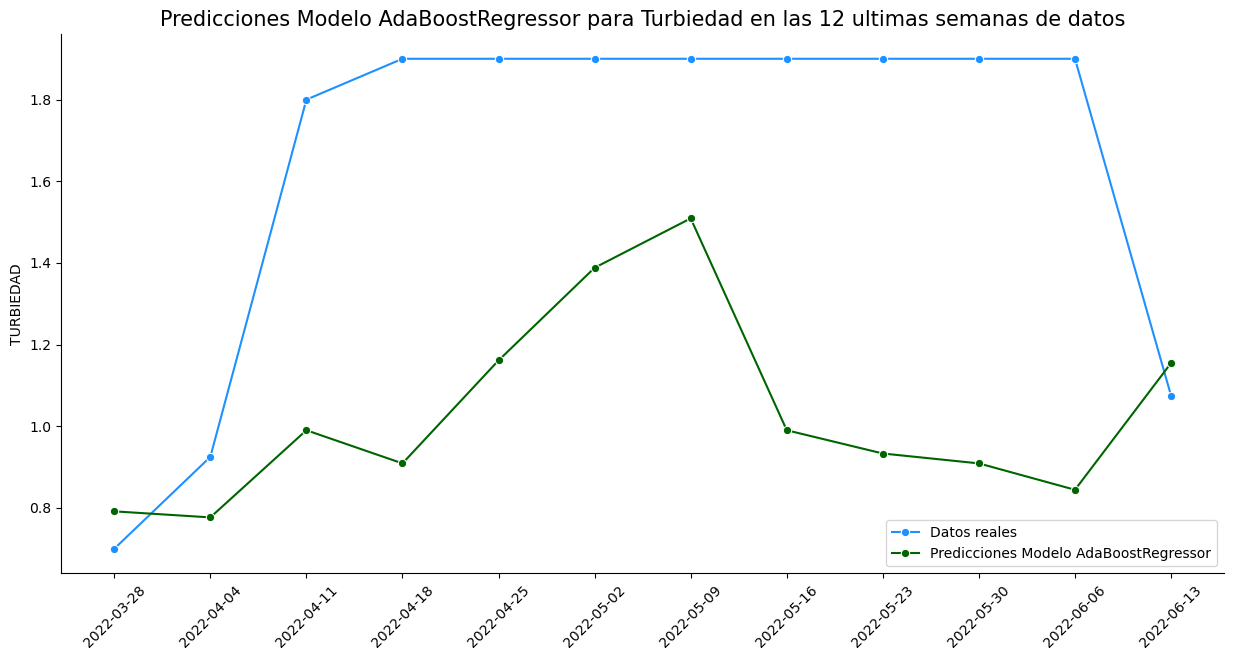

MAE:0.640372517737006
MSE: 0.5410616903200559





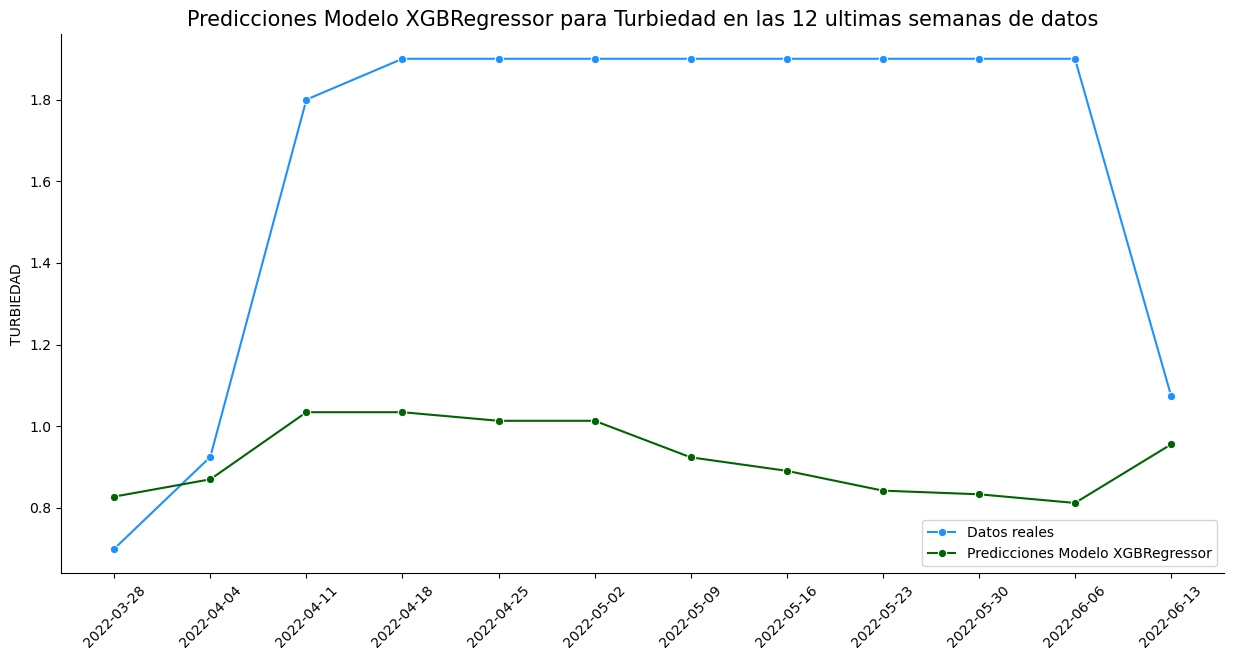

MAE:0.7419413814942041
MSE: 0.6959211697802828





## Puerto Cisnes

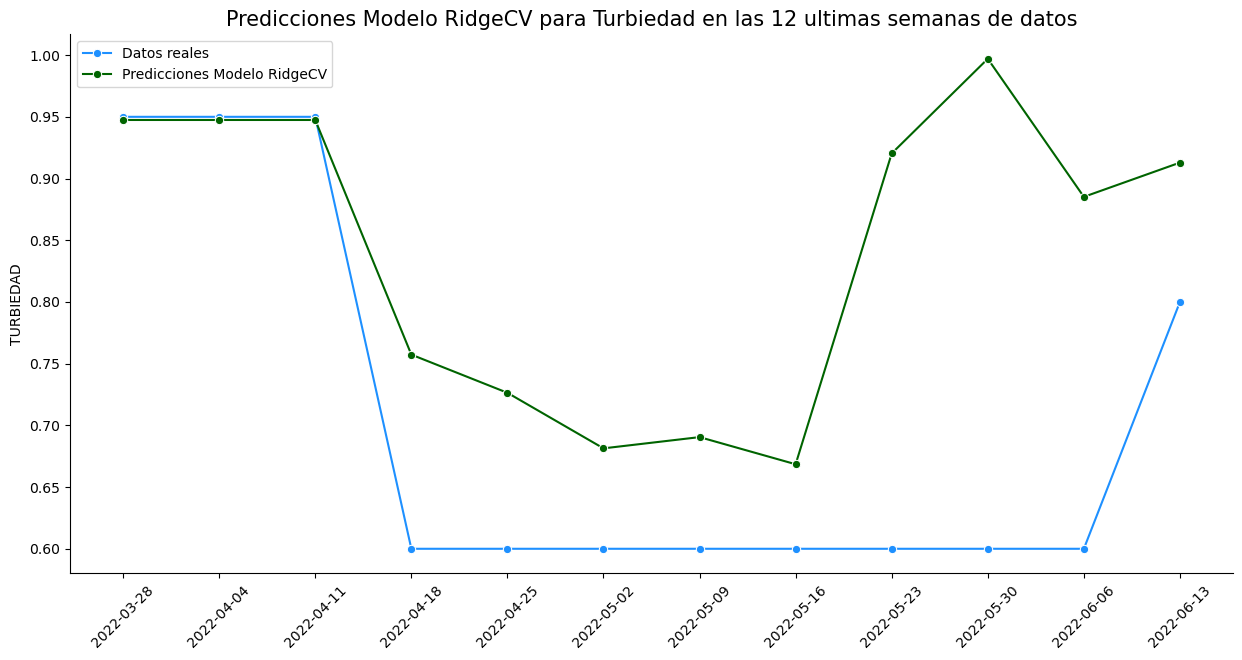

MAE:0.1372621259266775
MSE: 0.034545542009244916





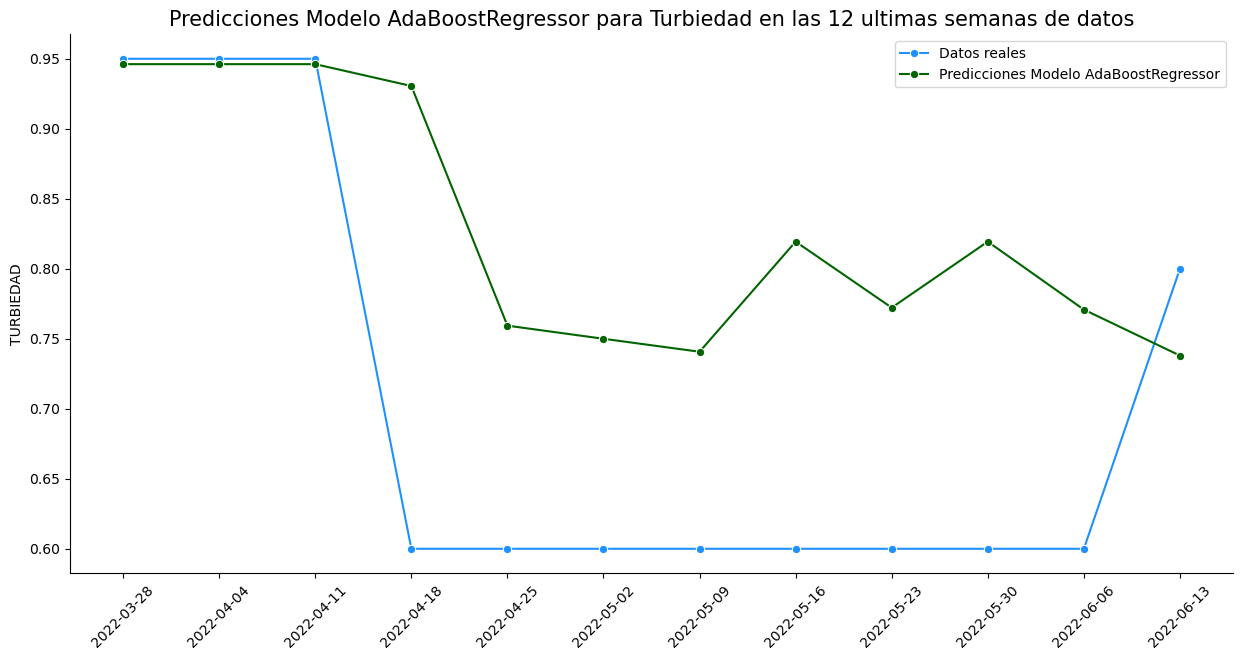

MAE:0.13633673529953297
MSE: 0.02799751637654034





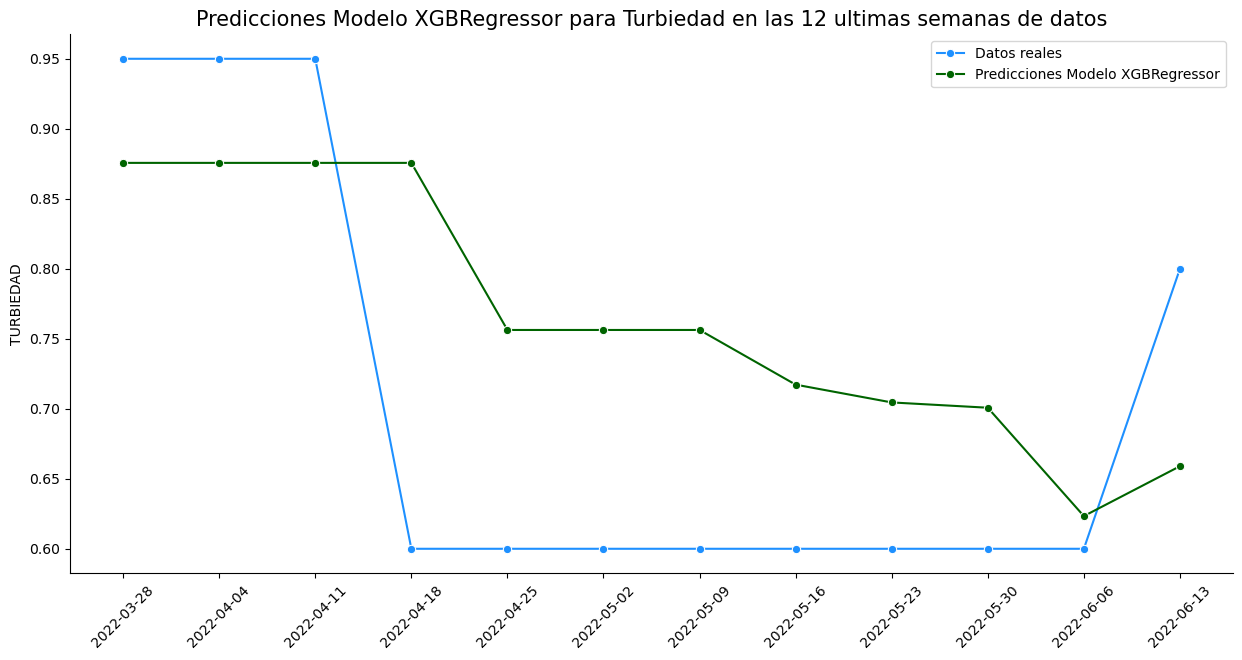

MAE:0.12120744884014129
MSE: 0.018425159291889072





## Puerto Ibañez

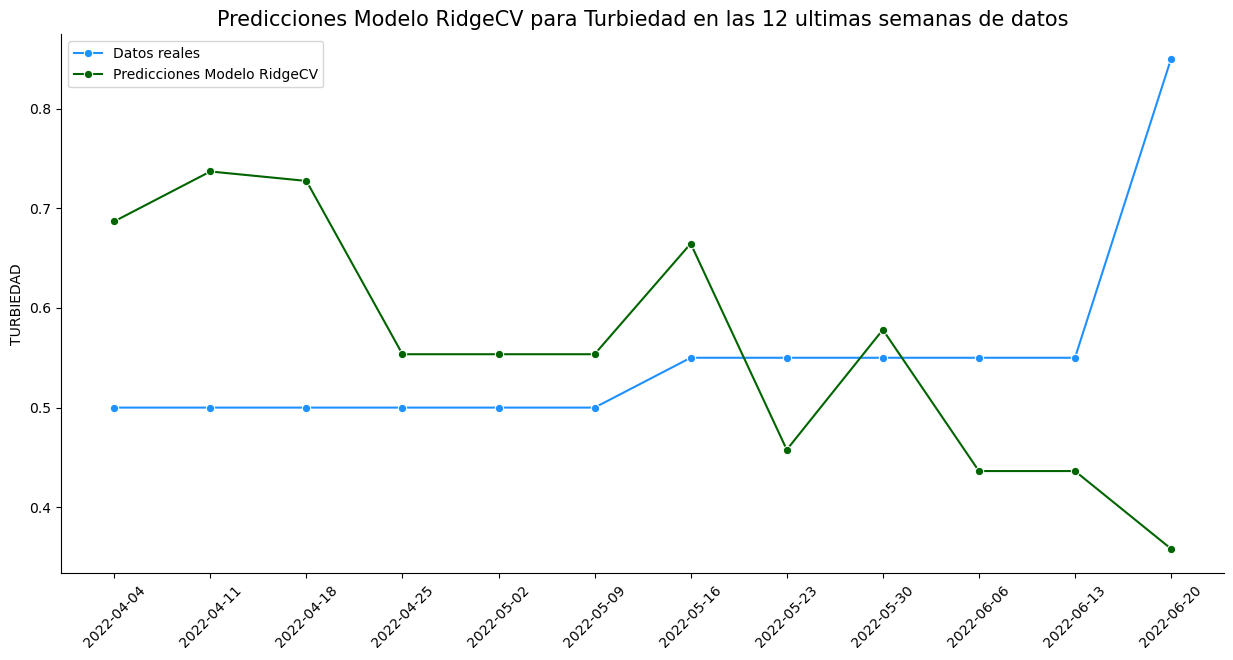

MAE:0.14715310194092238
MSE: 0.03678190817261096





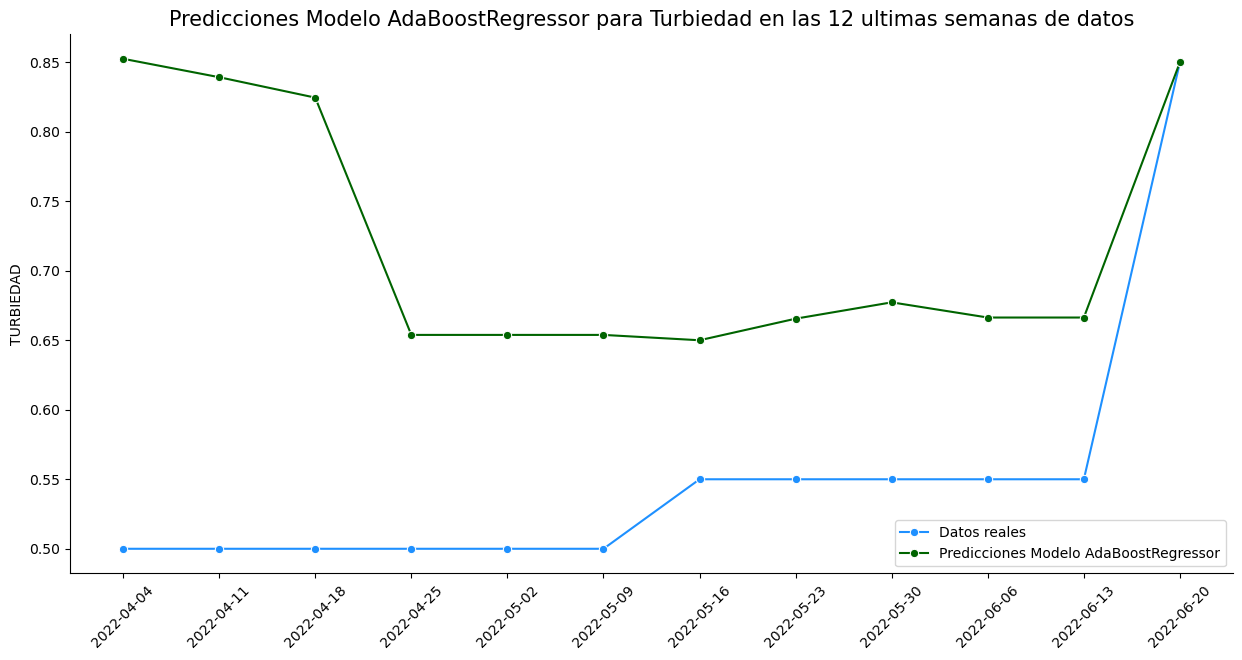

MAE:0.1711033311307384
MSE: 0.04018717108420996





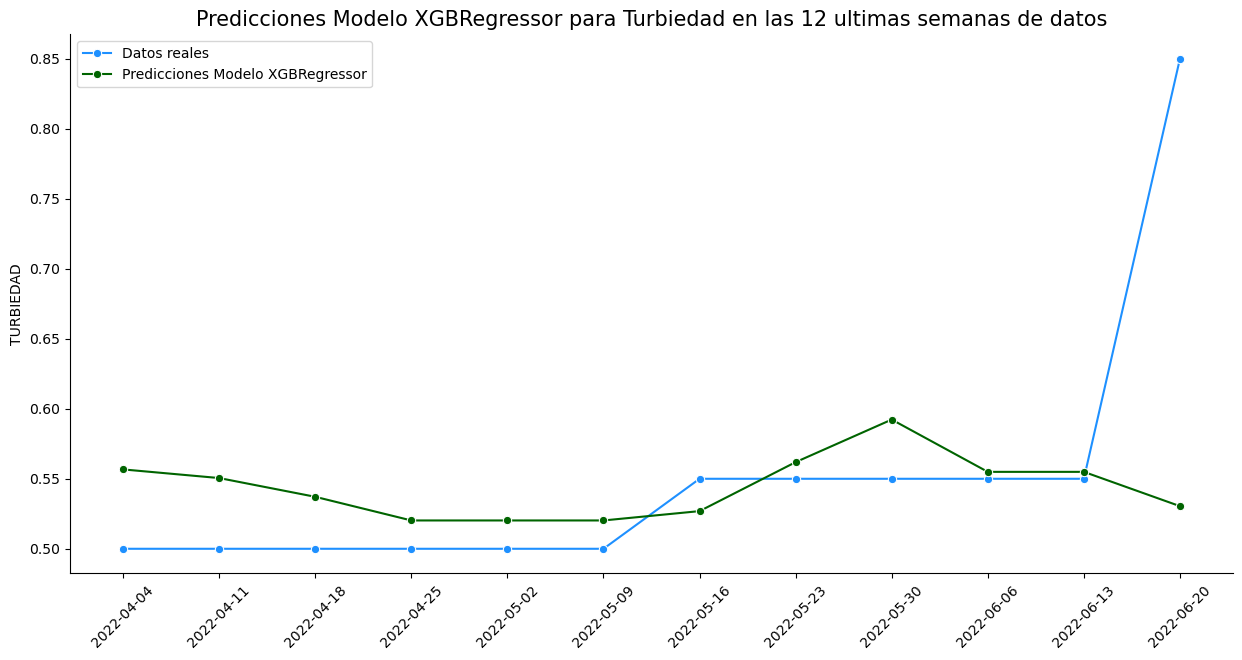

MAE:0.05097810029983519
MSE: 0.009416419930518363





In [1089]:
for localidad in list(pr18_proc_Localidad.index.get_level_values(0).unique()):
    localidad_data = pr18_proc_Localidad.loc[localidad, :].fillna(method = 'ffill').dropna()
    lagged_features = buildLaggedFeatures(localidad_data, lag=LAG)
    
    X = lagged_features.drop(columns = ['TURBIEDAD'])
    Y = lagged_features['TURBIEDAD']
    
    x_train = X.iloc[:-test_size,:]
    x_test = X.iloc[-test_size:,:]
    
    y_train = Y.iloc[:-test_size]
    y_test = Y.iloc[-test_size:]
    display(Markdown(f'## {localidades_dict[localidad]}'))
    for model in model_list:
        trained_model = model.fit(x_train, y_train)
        
        plt.subplots(figsize = (15,7))
        plt.title(f'Predicciones Modelo {type(model).__name__} para Turbiedad en las {test_size} ultimas semanas de datos', size = 15)
        sn.lineplot(data = y_test.reset_index(drop=True), label = 'Datos reales', color = 'dodgerblue', marker = 'o')
        sn.lineplot(data = trained_model.predict(x_test), color = 'darkgreen',
                    label = f'Predicciones Modelo {type(model).__name__}', marker = 'o')
        plt.xticks(ticks = range(test_size), labels = list(Y.index[-test_size:].date), rotation = 45)
        sn.despine()
        plt.show()
        print(f'MAE:{mean_absolute_error(y_test, trained_model.predict(x_test))}')
        print(f'MSE: {mean_squared_error(y_test, trained_model.predict(x_test))}')
        print('\n'*2)